Pruebas de clasificación no supervisada

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Librerias

In [ ]:
import numpy as np
from numpy import nan
import pandas as pd

import io

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.cm as cm

import os

import json


In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.neighbors import kneighbors_graph
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from scipy import cluster
from scipy.stats import chi2_contingency
import sklearn.neighbors
from scipy.spatial.distance import pdist, squareform
import collections


In [ ]:
pd.set_option("display.max_rows", 101)

# Montar google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

os.chdir("/content/drive/MyDrive/Astrofisica/Espectros")
#/content/drive/My Drive/Visualizacion
os.getcwd()

'/content/drive/MyDrive/Astrofisica/Espectros'

# Carga datos

## Carga de datos datos limpiados y filtrados de la muestra de subenanas de SDSS.

La siguiente fase será ya clustering. Vamos a guardar la matriz con los flujos por un lado y el de las longitudes de onda por otro. Así mismo guardaremos el resto de la información de las subenanas en csv.

In [ ]:
directorio = '../Espectros/datos_json/'
muestra_BD = np.load(directorio+'muestra_SubEM_tratada_1600.npz',allow_pickle=True)
muestra_BD.files


['flujos', 'long_onda', 'subclases', 'clase_metalicidad', 'datos', 'columnas']

In [ ]:
flujos_BD_SE, long_onda, subclases, clase_metalicidad, datos, columnas = [muestra_BD[f] for f in muestra_BD.files]

In [ ]:
df_enanas_sem = pd.DataFrame(data = datos, columns = columnas)
df_enanas_sem.tail(2)

SPECOBJID             ra             dec sn_median_r  \
3001  3331593700680689664  '07:52:53.40'  '+30:32:31.78'        7.05   
3002  3342950557106071552  '16:20:42.09'  '+17:48:21.76'        3.73   

             z     zerr zwarning   class subclass PLATE-MJD-FIBER  \
3001  0.000276  3.3e-05        0  'STAR'       M0  2959-54537-203   
3002 -0.000102  3.9e-05        0  'STAR'       M2  2969-54586-559   

     outlier_info outrango_info PLATEQUALITY extrapolado max_long_A  \
3001        False         False     marginal       False     9183.3   
3002        False         False         good       False     9206.6   

                         ID SP      CAH2      CAH3      TIO5 outlier_indices  \
3001  SDSS075253.4+303231.7  0  0.740018  0.853068  0.847223           False   
3002  SDSS162042.1+174821.7  2  0.521954   0.70433    0.9656           False   

     outrango_indices      EWHA   EWHAERR clase_metalicidad subclass_c  
3001            False -0.454342  0.261851               sdM         M0  
3002            False  0.855477  0.447256              usdM         M2

In [ ]:
flujos_BD_SE.shape

(3003, 1600)

In [ ]:
long_onda.shape

(1600,)

In [ ]:
del muestra_BD

## Carga de datos datos limpiados y filtrados de las enanas marrones del catálogo West del conjunto de trabajo

In [ ]:
directorio = '../Espectros/datos_json/'
muestra_BD = np.load(directorio+'muestra_EM_cat_West_5000_tratada.npz',allow_pickle=True)
muestra_BD.files


['flujos', 'long_onda', 'subclases', 'datos', 'columnas']

In [ ]:
flujos_BD_EM, long_onda_EM, subclases_EM, datos_EM, columnas_EM = [muestra_BD[f] for f in muestra_BD.files]

In [ ]:
df_enanas_marrones = pd.DataFrame(data = datos_EM, columns = columnas_EM)
df_enanas_marrones.head(2)

SPECOBJID             ra             dec sn_median_r        z  \
0  444845392081741824  '00:57:41.55'  '+00:31:25.50'       17.12  2.1e-05   
1  444877827674761216  '01:00:10.53'  '+00:37:39.20'        4.48 -1.9e-05   

      zerr zwarning   class subclass PLATE-MJD-FIBER outlier_info  \
0  1.2e-05        0  'STAR'       M2   395-51783-418        False   
1  5.4e-05        0  'STAR'       M3   395-51783-536        False   

  outrango_info PLATEQUALITY extrapolado max_long_A SpT clase_metalicidad  \
0         False         good       False     9200.3   2                dM   
1         False         good       False     9187.6   2                dM   

  subclass_c  
0         M2  
1         M2

In [ ]:
flujos_BD_EM.shape

(4855, 1600)

In [ ]:
long_onda_EM.shape

(1600,)

In [ ]:
del muestra_BD

# Creación de los dataset. Importante revisar límites

## Dataframe con los datos.

Concanaremos los dos datasets. Habrá que revisar los atributos

Eliminamos los atributos que no interesan

In [ ]:
eliminar = ['ID','SP', 'CAH2', 'CAH3', 'TIO5', 'EWHA', 'EWHAERR', 'outlier_indices',
       'outrango_indices']
df_sdm = df_enanas_sem.drop(columns=eliminar)
df_sdm.columns

Index(['SPECOBJID', 'ra', 'dec', 'sn_median_r', 'z', 'zerr', 'zwarning',
       'class', 'subclass', 'PLATE-MJD-FIBER', 'outlier_info', 'outrango_info',
       'PLATEQUALITY', 'extrapolado', 'max_long_A', 'clase_metalicidad',
       'subclass_c'],
      dtype='object')

In [ ]:
eliminar = ['SpT']
df_dm = df_enanas_marrones.drop(columns=eliminar)
df_dm.columns

Index(['SPECOBJID', 'ra', 'dec', 'sn_median_r', 'z', 'zerr', 'zwarning',
       'class', 'subclass', 'PLATE-MJD-FIBER', 'outlier_info', 'outrango_info',
       'PLATEQUALITY', 'extrapolado', 'max_long_A', 'clase_metalicidad',
       'subclass_c'],
      dtype='object')

Concatenamos los datasets empezando por el de las subenanas.

Creamos el dataset con las enanas y las subenanas.
Podemos seleccionar un subconjunto

In [ ]:
df_dm.shape

(4855, 17)

**SE ESTABLECEN LOS CORTES EN EL DATASET DE SUBENANAS**

In [ ]:
corte_sem = 1502 ; corte_sem_test = 1502 #SE DIVIDE MÁS O MENOS POR LA MITAD
#corte_sem = df_sdm.shape[0]; corte_sem_test = 0 #Usamos TODO conjunto de enanas en los dos datasets
#corte_sem = df_sdm.shape[0]; corte_sem_test = df_sdm.shape[0] #No usamos  el conjunto de enanas en el dataset de prueba

df_enanas = pd.concat([df_sdm.iloc[:corte_sem],df_dm],axis=0, ignore_index=True)

In [ ]:
df_enanas.head(3)
df_enanas.tail(3)

SPECOBJID             ra             dec sn_median_r  \
6354  3348467356799100928  '17:22:39.51'  '+30:30:38.38'        3.74   
6355  3348534152130488320  '17:18:24.95'  '+32:14:31.07'         1.6   
6356  3348583355275831296  '17:23:28.71'  '+31:12:07.32'       10.28   

             z     zerr zwarning   class subclass PLATE-MJD-FIBER  \
6354  -4.8e-05  2.9e-05        0  'STAR'       M4  2974-54592-149   
6355  -3.7e-05  1.9e-05        0  'STAR'       M7  2974-54592-392   
6356 -0.000115  1.8e-05        0  'STAR'       M0  2974-54592-571   

     outlier_info outrango_info PLATEQUALITY extrapolado max_long_A  \
6354        False         False         good       False     9181.2   
6355        False         False         good       False     9215.1   
6356        False         False         good       False     9208.7   

     clase_metalicidad subclass_c  
6354                dM         M5  
6355                dM         M8  
6356                dM         M0

In [ ]:
df_enanas.shape

(6357, 17)

## Espectros

Concatemos los flujos igualmente empezando por las subenanas.

In [ ]:
flujos_BD =np.concatenate([flujos_BD_SE[:corte_sem],flujos_BD_EM],axis=0)


In [ ]:
flujos_BD.shape

(6357, 1600)

## Revisión valores duplicados

Podría darse el caso de que tuviéramos espectros en el catálogo de West que estén en el catálogo de Savche...
En ese caso tendríamos objetos duplicados en el catálogo West que habrá que eliminar

In [ ]:
print(f"valores duplicados {df_enanas.shape[0]-(df_enanas.drop_duplicates(subset=['PLATE-MJD-FIBER',])).shape[0]}")

valores duplicados 88


In [ ]:
#print(f"valores duplicados {df_enanas.shape[0]-(df_enanas.drop_duplicates(subset=['SPECOBJID'])).shape[0]}")

In [ ]:
print(f"valores duplicados {df_enanas.shape[0]-(df_enanas.drop_duplicates(subset=['PLATE-MJD-FIBER'])).shape[0]}")

valores duplicados 88


Vemos que hay 210 repetidos. 

Eliminamos los del catálogo West. Como las subenanas están primero eliminamos duplicados quedándonos con la primera ocurrencia. 

In [ ]:
print(f'número de objetos antes de eliminar {df_enanas.shape[0]}')
df_enanas.drop_duplicates(subset=['PLATE-MJD-FIBER'], keep = 'first', inplace=True)
print(f'número de objetos después de eliminar {df_enanas.shape[0]}')

número de objetos antes de eliminar 6357
número de objetos después de eliminar 6269


Eliminamos también los espectros correspondientes

In [ ]:
flujos_BD= flujos_BD[df_enanas.index]

In [ ]:
flujos_BD.shape[0]

6269

Reseteamos los índices de df_enanas para que coincidan con los de flujos_DB.

**Esto es IMPORTANTE**

In [ ]:
df_enanas.reset_index(drop=True, inplace=True)
df_enanas.tail(2)

SPECOBJID             ra             dec sn_median_r  \
6267  3348534152130488320  '17:18:24.95'  '+32:14:31.07'         1.6   
6268  3348583355275831296  '17:23:28.71'  '+31:12:07.32'       10.28   

             z     zerr zwarning   class subclass PLATE-MJD-FIBER  \
6267  -3.7e-05  1.9e-05        0  'STAR'       M7  2974-54592-392   
6268 -0.000115  1.8e-05        0  'STAR'       M0  2974-54592-571   

     outlier_info outrango_info PLATEQUALITY extrapolado max_long_A  \
6267        False         False         good       False     9215.1   
6268        False         False         good       False     9208.7   

     clase_metalicidad subclass_c  
6267                dM         M8  
6268                dM         M0

## Revisión valores para las subclases y clases de metalicidad

In [ ]:
df_enanas.subclass.value_counts()

M2    1235
M3    1099
M0    1004
M4     682
M1     647
M6     476
K7     402
M5     355
M7     163
M8     120
M9      74
K5       8
Ca       3
         1
Name: subclass, dtype: int64

Vemos que hay dos sin subclase.

Hacemos los mismo para metalicidad

In [ ]:
df_enanas.clase_metalicidad.value_counts()

dM      4769
sdM     1075
esdM     321
usdM     104
Name: clase_metalicidad, dtype: int64

En el caso de la clase de metalicidad no hay problema. 

Eliminamos los objetos con la subclase vacía

In [ ]:
clase_nula = df_enanas.subclass == ''
clase_nula.sum()

1

In [ ]:
print(f'número de objetos antes de eliminar {df_enanas.shape[0]}')
df_enanas = df_enanas[~clase_nula]
print(f'número de objetos después de eliminar {df_enanas.shape[0]}')

número de objetos antes de eliminar 6269
número de objetos después de eliminar 6268


Repetimos para los espectros.

In [ ]:
print(f'número de objetos antes de eliminar {flujos_BD.shape[0]}')
flujos_BD= flujos_BD[df_enanas.index]
print(f'número de objetos después de eliminar {flujos_BD.shape[0]}')

número de objetos antes de eliminar 6269
número de objetos después de eliminar 6268


Reseteamos los índices de df_enanas para que coincidan con los de flujos_DB.

**Esto es IMPORTANTE**

In [ ]:
df_enanas.reset_index(drop=True, inplace=True)
df_enanas.tail(2)

SPECOBJID             ra             dec sn_median_r  \
6266  3348534152130488320  '17:18:24.95'  '+32:14:31.07'         1.6   
6267  3348583355275831296  '17:23:28.71'  '+31:12:07.32'       10.28   

             z     zerr zwarning   class subclass PLATE-MJD-FIBER  \
6266  -3.7e-05  1.9e-05        0  'STAR'       M7  2974-54592-392   
6267 -0.000115  1.8e-05        0  'STAR'       M0  2974-54592-571   

     outlier_info outrango_info PLATEQUALITY extrapolado max_long_A  \
6266        False         False         good       False     9215.1   
6267        False         False         good       False     9208.7   

     clase_metalicidad subclass_c  
6266                dM         M8  
6267                dM         M0

Veamos la tabla cruzada.

In [ ]:
pd.crosstab(df_enanas.clase_metalicidad,df_enanas.subclass)

subclass           Ca  K5   K7   M0   M1   M2   M3   M4   M5   M6   M7  M8  M9
clase_metalicidad                                                             
dM                  1   8  373  598  465  845  928  600  306  417  127  65  35
esdM                0   0    9  150   34   77   19   14    2    4    4   4   4
sdM                 2   0   19  180  143  298  149   66   47   55   32  49  35
usdM                0   0    1   76    5   15    3    2    0    0    0   2   0

# Análisis PCA

Para aplicar PCA es necesario estandarizar los flujos para cada longitud de onda. 

In [ ]:
sc_em = StandardScaler()
e_flujos_em = sc_em.fit_transform(flujos_BD)
e_flujos_em.shape


(7647, 1600)

In [ ]:
estimator_em = PCA(n_components = 0.96)
X_pca_em = estimator_em.fit_transform(e_flujos_em)
varianza_explicada_em = estimator_em.explained_variance_ratio_

In [ ]:
datos_con_outliers = X_pca_em[:,:45]
datos_con_outliers.shape

(7647, 45)

In [ ]:
varianza_explicada_em.shape

(314,)

In [ ]:
#Liberamos memoria.
#del flujos_BD

In [ ]:
varianza_explicada_em[:50]

array([0.66814006, 0.06565604, 0.03545362, 0.00707392, 0.00661835,
       0.00504159, 0.00417717, 0.00362777, 0.00339699, 0.00277952,
       0.00261263, 0.00215231, 0.00198581, 0.0019512 , 0.00178998,
       0.00170192, 0.00165951, 0.00161745, 0.0015517 , 0.00148913,
       0.00144911, 0.00138848, 0.0013805 , 0.00135319, 0.00133504,
       0.00132134, 0.00130574, 0.0013001 , 0.00125164, 0.00122435,
       0.00122076, 0.00119486, 0.00118212, 0.00115452, 0.00113102,
       0.00110333, 0.00107827, 0.00107488, 0.0010567 , 0.00104399,
       0.00101913, 0.00101078, 0.00099656, 0.00099068, 0.00098928,
       0.0009771 , 0.00096311, 0.00095492, 0.00093189, 0.00092987])

In [ ]:
varianza_acumulada_em = np.cumsum(varianza_explicada_em)
varianza_acumulada_em[:50]

array([0.66814006, 0.7337961 , 0.76924972, 0.77632364, 0.78294198,
       0.78798358, 0.79216074, 0.79578851, 0.7991855 , 0.80196502,
       0.80457765, 0.80672996, 0.80871577, 0.81066697, 0.81245695,
       0.81415887, 0.81581839, 0.81743583, 0.81898754, 0.82047667,
       0.82192577, 0.82331425, 0.82469475, 0.82604793, 0.82738297,
       0.82870431, 0.83001005, 0.83131014, 0.83256179, 0.83378613,
       0.83500689, 0.83620175, 0.83738387, 0.83853839, 0.83966941,
       0.84077273, 0.841851  , 0.84292589, 0.84398258, 0.84502657,
       0.8460457 , 0.84705648, 0.84805304, 0.84904372, 0.850033  ,
       0.8510101 , 0.85197321, 0.85292813, 0.85386002, 0.85478989])

In [ ]:
np.where(varianza_acumulada_em<0.90)[0].shape


(115,)

Podemos ver la desviación típica para las nuevas coordenadas.

In [ ]:
np.std(X_pca_em[:,:20],axis=0)

array([32.69593394, 10.24937345,  7.53165284,  3.36426385,  3.25412914,
        2.84016662,  2.5852407 ,  2.40923835,  2.33134873,  2.1088443 ,
        2.04455751,  1.85571861,  1.78249724,  1.76689428,  1.69232788,
        1.65017417,  1.62948456,  1.60869947,  1.57566663,  1.54357053])

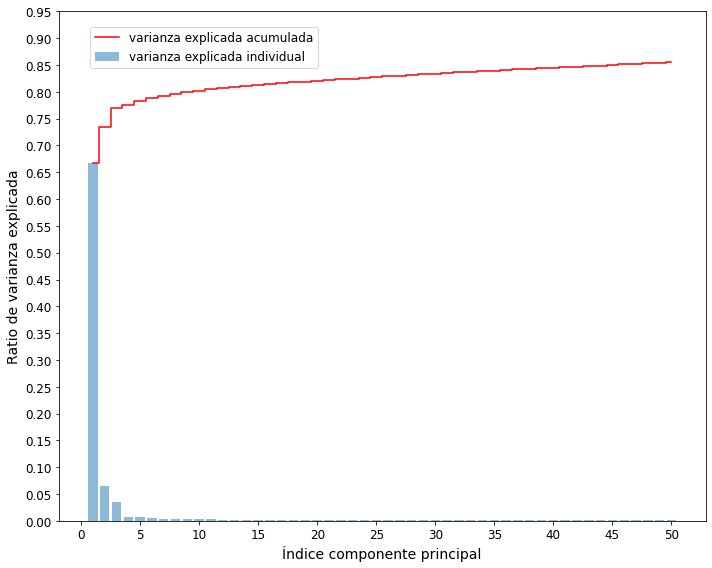

In [ ]:
indice = 50
ax=plt.figure(figsize=(10,8))
plt.bar(range(1, indice+1), varianza_explicada_em[:indice], alpha=0.5, align='center',
        label='varianza explicada individual')
plt.step(range(1, indice+1), varianza_acumulada_em[:indice], where='mid',c='r', label='varianza explicada acumulada')
plt.ylabel('Ratio de varianza explicada',fontsize=14)
plt.xlabel('Índice componente principal',fontsize=14)
plt.yticks((np.arange(0, 1, step=0.05)),size=12)
plt.xticks((np.arange(0, indice+1, step=5)),size=12)

ax.legend(loc='best', bbox_to_anchor=(0, 0.45, 0.45, 0.5),prop={"size":12})

plt.tight_layout()

plt.show()

Codificamos las subclases y las clases de metalicidad con **LabelEncoder**. Vamos a tratar por separado de momento la subclase espectral y la clase de metalicidad.

<br>
<br>

# Detectar espectros atípicos con enlace 'single'

## Cálculo de la matriz de distancia

Calculamos la matriz de distancia con métrica euclídea. Lo haremos sobre las características seleccionadas.
 

In [ ]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matdist= dist.pairwise(datos_con_outliers)

El método anterior tiene algunos problemas. Es mejor usar los siguiente

In [ ]:
distancia = pdist(datos_con_outliers,metric ='euclidean') # genera una matriz plana con la parte superior triangular de la matriz de distancia. 
#Esta matriz plana es la entrada óptima para el algoritmo
matrizdistancia = squareform(distancia)

In [ ]:
distancia.shape

(19640778,)

In [ ]:
'''
#consume mucha memoria y no se ve información clara
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(matdist,vmin=0, vmax=0.1,ax=ax)
'''

## Enlace "single"

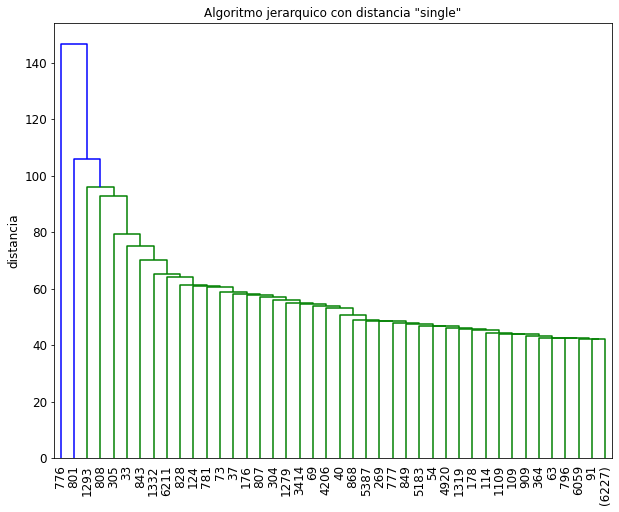

In [ ]:
clusters_s = cluster.hierarchy.linkage(distancia, method = 'single')
f, ax = plt.subplots(figsize=(10, 8))
cluster.hierarchy.dendrogram(clusters_s, p=40, truncate_mode='level' ,ax=ax)
ax.set_title('Algoritmo jerarquico con distancia "single"')
ax.set_ylabel('distancia',size=12)
ax.tick_params(labelsize=12)
plt.show()

#### Valores atípicos.

El enlace simple es util para detectar outliers. 

In [ ]:
n_cluster = []
#dist = np.arange(20,40,1) #PCA 10
dist = np.arange(40,90,1) #PCA 45
dist = np.arange(55,100,1) #PCA 45 50% de enanas marrones
#dist = np.arange(0.5,2,0.1) #norm
for i in dist: 

  dic_cluster = collections.Counter(cluster.hierarchy.fcluster(clusters_s, i , criterion = 'distance'))
  n_cluster=n_cluster+[len(dic_cluster)]

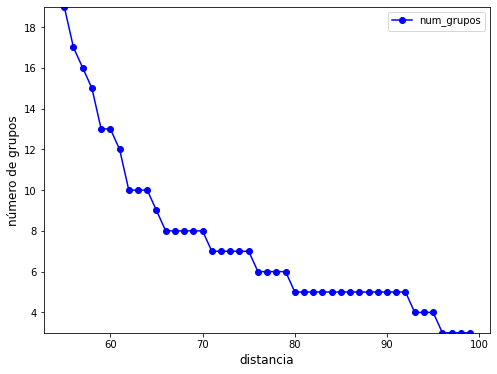

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(dist, n_cluster , marker='o',c='b', label='num_grupos')

ax.set_ylabel('número de grupos',size = 12)
ax.set_xlabel('distancia',size = 12)

ax.set_ylim(min(n_cluster),max(n_cluster))
ax.legend(loc='best')

#ax.set_title('Silhouette vs clusters para enlace "ward"')
plt.show()


Recuperamos las etiquetas.

In [ ]:
#dist = 1.1 #norm
#dist = 53 #PCA 45
#dist = 34 # std
dist = 60 # #PCA 45 50% de enanas marrones
etiquetas = cluster.hierarchy.fcluster(clusters_s, dist , criterion = 'distance')
etiquetas

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
val_atipicos_single = etiquetas
val_atipicos_single

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
collections.Counter(etiquetas)

Counter({1: 6256,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1})

Añadimos una columna al dataset. Serán outliers aquellos elementos que no pertenezcan a la clase 1. 

In [ ]:
df_enanas['hierarchy_outlier'] = etiquetas


Guardamos los índices de los valores atípicos

In [ ]:
indices_out_single = df_enanas['hierarchy_outlier']!=1
indices_out_single = df_enanas.index[indices_out_single]
indices_out_single


Int64Index([33, 124, 305, 776, 781, 801, 808, 828, 843, 1293, 1332, 6211], dtype='int64')

In [ ]:
df_enanas.loc[indices_out_single]

#  Eliminar valores atípicos. 

Tenemos los siguientes valores atípicos calculados

In [ ]:
indices_out_single =[] #para pruebas sin quitar atipicos

In [ ]:
# 50% de subenanas
indices_out_single = [33, 124, 305, 776, 781, 801, 808, 828, 843, 1293, 1332, 6211]

In [ ]:
#esto es con todo el subconjunto de subenanas 45 PCA
indices_out_single = [33, 305, 776, 801, 808, 843, 1293, 1332, 1769, 2597, 2681, 2702, 7593]


Se recalculan las etiquetas que nos indicaráN si es outlier. 0 si outlier

In [ ]:
list_single_etiquetas = [0 if x in indices_out_single else 1 for x in df_enanas.index]
indices_tipicos = np.asarray(list_single_etiquetas) ==1

Eliminamos los espectros atípicos de los dataset.

In [ ]:
print(f"total espectros: {len(list_single_etiquetas)}")
print(f"Espectros no atípicos: {indices_tipicos.sum()}")
df_enanas_sin_out=df_enanas[indices_tipicos] #datos enanas
df_enanas_sin_out.reset_index(drop=True, inplace=True)
indices_out_single

total espectros: 6268
Espectros no atípicos: 6256


[33, 124, 305, 776, 781, 801, 808, 828, 843, 1293, 1332, 6211]

Codificamos las subclases y las clases de metalicidad con **LabelEncoder**. Vamos a tratar por separado de momento la subclase espectral y la clase de metalicidad.

In [ ]:

# Label encoding with sklearn's LabelEncoder
cod_clase_metalicidad_em = LabelEncoder()
cod_subclases_em = LabelEncoder()
cod_subclases = cod_subclases_em.fit_transform(df_enanas_sin_out['subclass'])
cod_metalicidad = cod_clase_metalicidad_em.fit_transform(df_enanas_sin_out['clase_metalicidad'])

In [ ]:
# reverse mapping
cod_subclases_em.inverse_transform(cod_subclases)

array(['M8', 'M2', 'M8', ..., 'M4', 'M7', 'M0'], dtype=object)

In [ ]:
cod_clase_metalicidad_em.inverse_transform(cod_metalicidad)

array(['sdM', 'sdM', 'sdM', ..., 'dM', 'dM', 'dM'], dtype=object)

# Análisis PCA sin outliers

Volvemos a ejecutar PCA sin outliers

In [ ]:
flujos_BD[indices_tipicos].shape

(6256, 1600)

In [ ]:
sc_em = StandardScaler()
e_flujos_em_sin_out = sc_em.fit_transform(flujos_BD[indices_tipicos])
e_flujos_em_sin_out.shape

(6256, 1600)

In [ ]:
estimator_em = PCA(n_components = 0.96)
X_pca_em = estimator_em.fit_transform(e_flujos_em_sin_out)
varianza_explicada_em = estimator_em.explained_variance_ratio_

In [ ]:
varianza_explicada_em.shape

(245,)

In [ ]:
#Liberamos memoria.
#del flujos_BD

In [ ]:
varianza_explicada_em[:50]

array([0.69598874, 0.06454824, 0.03304699, 0.00649037, 0.0063411 ,
       0.00453261, 0.00331823, 0.00325841, 0.00301242, 0.00289791,
       0.00241468, 0.00212588, 0.00198277, 0.00193433, 0.00182728,
       0.00173435, 0.00172172, 0.00166719, 0.00161197, 0.00153842,
       0.00147282, 0.00144125, 0.00137457, 0.00136595, 0.00134626,
       0.00132935, 0.00132041, 0.00128305, 0.00125809, 0.0012324 ,
       0.00120931, 0.00118566, 0.00117969, 0.00115782, 0.00113602,
       0.00111539, 0.00110315, 0.00108115, 0.00107104, 0.0010566 ,
       0.00103113, 0.00102421, 0.00100506, 0.00098972, 0.00097757,
       0.00097521, 0.00096622, 0.00095114, 0.0009404 , 0.00092423])

In [ ]:
varianza_acumulada_em = np.cumsum(varianza_explicada_em)
varianza_acumulada_em[:50]

array([0.69598874, 0.76053697, 0.79358397, 0.80007433, 0.80641543,
       0.81094804, 0.81426626, 0.81752467, 0.82053709, 0.823435  ,
       0.82584967, 0.82797555, 0.82995832, 0.83189265, 0.83371993,
       0.83545428, 0.837176  , 0.83884319, 0.84045516, 0.84199359,
       0.84346641, 0.84490765, 0.84628223, 0.84764818, 0.84899444,
       0.85032379, 0.8516442 , 0.85292725, 0.85418534, 0.85541774,
       0.85662705, 0.85781271, 0.8589924 , 0.86015021, 0.86128623,
       0.86240163, 0.86350478, 0.86458593, 0.86565697, 0.86671357,
       0.8677447 , 0.86876891, 0.86977397, 0.87076369, 0.87174126,
       0.87271647, 0.87368269, 0.87463383, 0.87557423, 0.87649845])

In [ ]:
np.where(varianza_acumulada_em<0.90)[0].shape


(80,)

Podemos ver la desviación típica para las nuevas coordenadas.

In [ ]:
np.std(X_pca_em[:,:20],axis=0)

array([33.37037579, 10.16253795,  7.27153269,  3.2225126 ,  3.1852409 ,
        2.69298535,  2.30416149,  2.2832977 ,  2.19541987,  2.15328961,
        1.96557445,  1.84429099,  1.78113084,  1.75924055,  1.70986879,
        1.66581879,  1.65974354,  1.6332519 ,  1.60597506,  1.56890895])

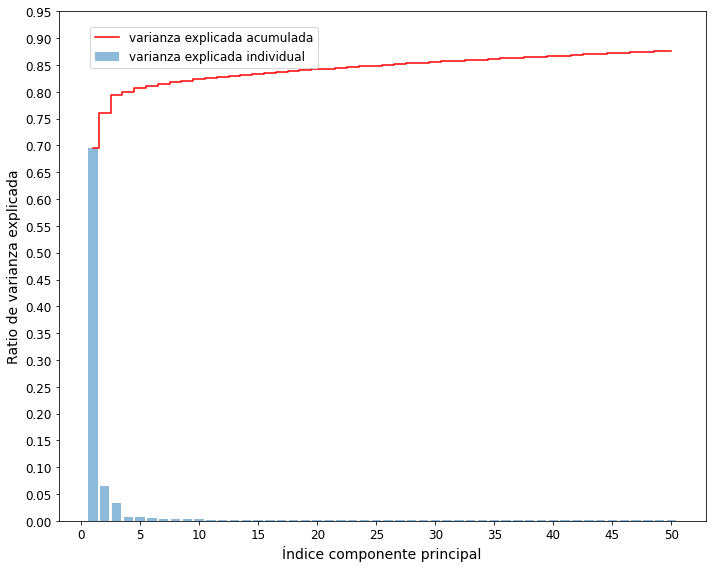

In [ ]:
indice = 50
ax=plt.figure(figsize=(10,8))
plt.bar(range(1, indice+1), varianza_explicada_em[:indice], alpha=0.5, align='center',
        label='varianza explicada individual')
plt.step(range(1, indice+1), varianza_acumulada_em[:indice], where='mid',c='r', label='varianza explicada acumulada')
plt.ylabel('Ratio de varianza explicada',fontsize=14)
plt.xlabel('Índice componente principal',fontsize=14)
plt.yticks((np.arange(0, 1, step=0.05)),size=12)
plt.xticks((np.arange(0, indice+1, step=5)),size=12)

ax.legend(loc='best', bbox_to_anchor=(0, 0.45, 0.45, 0.5),prop={"size":12})

plt.tight_layout()

plt.show()

<br>
<br>

#### Creación dataset con componentes PCA

Creamos un dataset con las primeras componentes pca y las subclases y metalicidad sin outliers

In [ ]:

n_comp_pca = 240

df_enanas_pca_sin_out = pd.DataFrame(data=X_pca_em[:,:n_comp_pca])
df_enanas_pca_sin_out['subclase']=df_enanas_sin_out.subclass
df_enanas_pca_sin_out['clase_metalicidad']=df_enanas_sin_out.clase_metalicidad
print(df_enanas_pca_sin_out.shape)
df_enanas_pca_sin_out.head(3)


(6256, 242)


0          1          2         3         4         5         6  \
0  70.978135  13.612368 -16.691582  4.513305 -3.044741 -4.386577 -4.122600   
1  -5.408627   0.617804  12.706369  1.250485 -2.526692 -4.864409  1.210590   
2  76.772529  30.713957 -11.479997  5.976142  3.472740  7.452680  1.436459   

          7          8         9        10        11        12        13  \
0  4.066228 -10.253098  3.172336  6.534061 -4.899613  3.691630  6.238291   
1  3.191431   1.445076  1.368169 -3.217992 -0.033158 -1.710745 -0.659535   
2  6.101172  -2.214774  9.438690  4.982756  0.229479 -3.755829 -0.834140   

         14  ...       227       228       229       230       231       232  \
0 -2.455896  ... -2.718802  2.094710 -0.993631 -1.093007 -1.848229  0.603942   
1  0.239845  ... -0.444138 -0.160863 -0.524025  0.074496  0.895404  0.194673   
2 -3.055742  ...  0.334225 -0.050458 -2.270213  0.575853  1.259307  1.522782   

        233       234       235       236       237       238       239  \
0 -0.421891  1.110822  1.447102  1.007228 -0.482308  1.091860  0.385400   
1  0.231559 -0.306906 -0.346929 -0.248491 -0.368060  0.401198 -0.628057   
2 -1.285965 -2.467547  0.299578  0.014359  1.484640  0.781160  1.582719   

   subclase  clase_metalicidad  
0        M8                sdM  
1        M2                sdM  
2        M8                sdM  

[3 rows x 242 columns]

### Centroides  subclases

In [ ]:
df_clases_enanas = df_enanas_pca_sin_out.groupby('subclase').mean()
df_clases_enanas

0          1          2         3          4         5    \
subclase                                                                   
Ca       -47.462058   4.257044  -3.969765  0.026729 -10.009214  9.419294   
K5       -63.987705  16.125782 -12.091961 -0.875649   2.347827 -1.551965   
K7       -53.161140  10.219444  -7.767913 -0.225530  -0.142628 -0.676937   
M0       -35.274376   5.646713  -0.052656  0.177030  -1.940706 -0.036118   
M1       -21.845123   0.248769   0.701163  0.221535  -0.148600  0.715002   
M2        -7.441317  -2.242921   4.273362  0.190760   0.510665 -0.323700   
M3         4.866200  -6.787540   1.794734 -0.052187   1.243323  0.254363   
M4        18.794078  -8.480777   0.367879 -0.271729   0.951642  0.447085   
M5        39.438939  -4.964778  -0.371086 -0.285867   0.476266 -0.734127   
M6        50.112476  -0.888106  -2.853604 -0.484225  -0.461492 -0.168735   
M7        64.615850  11.324808  -7.590479 -0.460902  -0.679691 -0.929743   
M8        74.859630  25.406448 -11.710732  0.334800  -2.099699 -0.190485   
M9        83.477616  49.800363  -8.838715  2.259755  -1.919978  2.371681   

               6         7         8         9         10        11   \
subclase                                                               
Ca        0.516354  1.474601 -2.611232 -2.815338 -4.016811 -3.744454   
K5        0.180000 -2.613411 -0.779574 -2.834495  0.731275 -1.533103   
K7       -0.216526  0.108723 -0.664329 -1.895205  0.209664 -0.608415   
M0        0.437277  0.747745 -0.367193 -0.332121 -0.165249 -0.163107   
M1       -0.056772 -0.224901  0.297162  0.469400  0.308904  0.297146   
M2        0.049310 -0.121919  0.557261  0.965719 -0.139397  0.473719   
M3       -0.353506 -0.652198  0.388361  0.713969  0.028526  0.302221   
M4       -0.331844 -0.608910 -0.095600 -0.102610  0.098826 -0.314821   
M5        0.124282  0.337873 -0.841016 -1.667710  0.033945 -0.678057   
M6        0.139799  0.693135 -1.002962 -2.161624 -0.344364 -0.769879   
M7        0.465392  1.746964 -0.823012 -0.898483  0.312369 -0.240188   
M8        0.726275  1.181100  1.100448  2.492812  0.703359  0.392000   
M9       -0.516776 -3.279546  2.826102  5.862167 -0.282933  2.055550   

               12        13        14   ...       225       226       227  \
subclase                                ...                                 
Ca       -2.899464  1.005241 -0.523382  ... -0.482034 -0.246194 -0.272353   
K5       -1.213765 -1.330302 -1.192486  ...  0.171694  0.076132 -0.054807   
K7        0.341520 -0.341894 -0.037898  ...  0.002817  0.052201  0.021126   
M0        0.006541 -0.011249 -0.123267  ... -0.000467 -0.007306 -0.002776   
M1        0.052254  0.116924  0.068339  ... -0.014046 -0.009056 -0.007998   
M2       -0.128496  0.100799  0.091472  ... -0.001798 -0.028903 -0.033054   
M3       -0.106822  0.150507  0.087930  ...  0.020153 -0.001454  0.042322   
M4       -0.085169  0.025860  0.064675  ...  0.004686  0.033182  0.024981   
M5        0.154124 -0.252011 -0.126084  ... -0.031140  0.104183 -0.075061   
M6        0.190753 -0.267975 -0.152795  ... -0.015662 -0.031156 -0.013802   
M7        0.072486 -0.346124 -0.900209  ... -0.093321 -0.134276  0.070810   
M8       -0.133317 -0.196217  0.024760  ...  0.146464  0.015687  0.003482   
M9        0.494426  1.030375  1.681045  ...  0.030002  0.071351 -0.009856   

               228       229       230       231       232       233  \
subclase                                                               
Ca       -0.027353  1.040008 -0.812375 -0.294388 -0.876682  0.133478   
K5       -0.150076  0.053644  0.399494  0.493071 -0.035349  0.173199   
K7        0.021482  0.003874  0.078302  0.005144  0.009409 -0.007907   
M0       -0.017551  0.008548 -0.022598 -0.015444  0.030779  0.002671   
M1        0.016270  0.013794 -0.037451 -0.007191 -0.058881 -0.000599   
M2        0.004354 -0.005369 -0.024635 -0.002863 -0.023990  0.004136   
M3       -0.003848 -0.034460  0.025657  0.021827 -0.003216 -0.

In [ ]:
color_g = cm.get_cmap('gnuplot2',len(df_clases_enanas)+1)

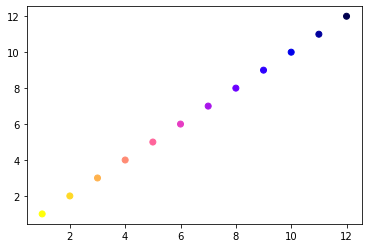

In [ ]:
x = np.arange(1,len(df_clases_enanas))
newcolors=color_g(x[::-1])
mapa_color=ListedColormap(newcolors)
plt.scatter(x,x,cmap= mapa_color, c=x)

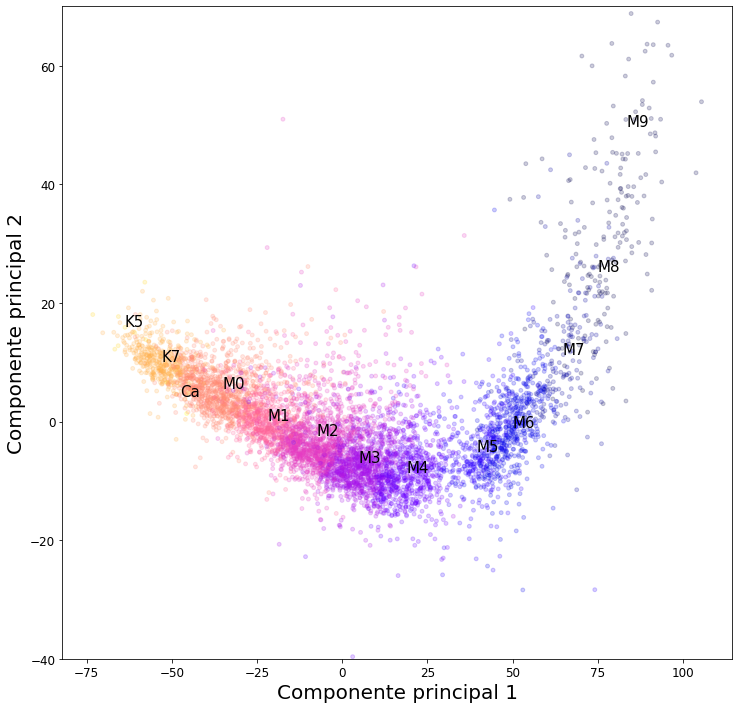

In [ ]:
comp =0
comp_aux =1
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(X_pca_em[:,comp], X_pca_em[:,comp_aux] , cmap=mapa_color,s=15,c=cod_subclases,alpha=0.2)

for clase in df_clases_enanas.index:
  if clase not in ['T2','L9']:
    ax.text(df_clases_enanas.loc[clase][comp], df_clases_enanas.loc[clase][comp_aux], clase,size=15,c='black') 

ax.set_xlabel('Componente principal '+str(comp+1),fontsize=20)
ax.set_ylabel('Componente principal '+str(comp_aux+1),fontsize=20)
#ax.set_xlim(-75,75)
ax.set_ylim(-40,70)
#ax.set_ylim(-30,40)

ax.tick_params(labelsize=12)

plt.show()


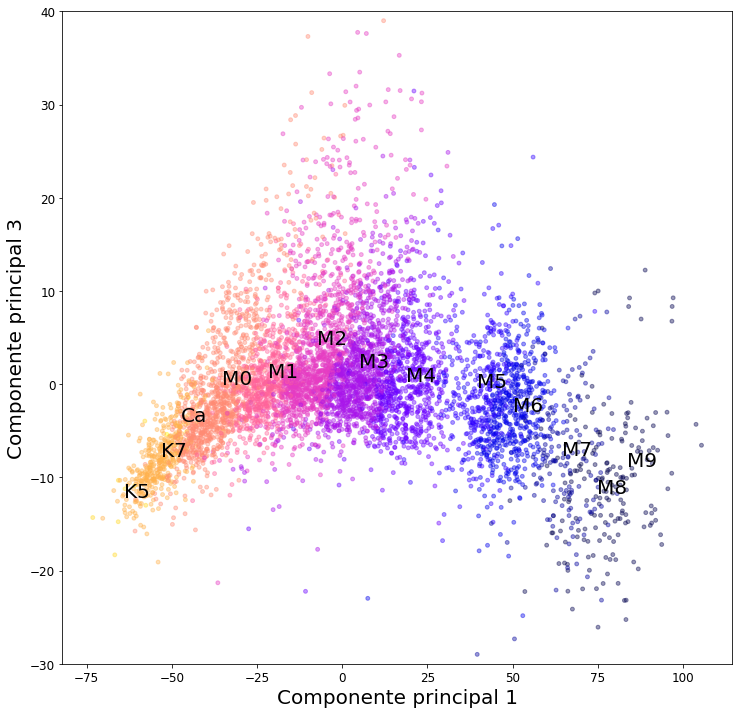

In [ ]:
comp =0
comp_aux =2
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(X_pca_em[:,comp], X_pca_em[:,comp_aux] , cmap=mapa_color,s=15,c=cod_subclases,alpha=0.4)

for clase in df_clases_enanas.index:
  if clase not in ['T2','L9','L0']:
    ax.text(df_clases_enanas.loc[clase][comp], df_clases_enanas.loc[clase][comp_aux], clase,size=20,c='black') 

ax.set_xlabel('Componente principal '+str(comp+1),fontsize=20)
ax.set_ylabel('Componente principal '+str(comp_aux+1),fontsize=20)
#ax.set_xlim(-75,75)
#ax.set_ylim(-30,65)
ax.set_ylim(-30,40)

ax.tick_params(labelsize=12)

plt.show()


Veamos tres componentes

(-20.0, 10.0)

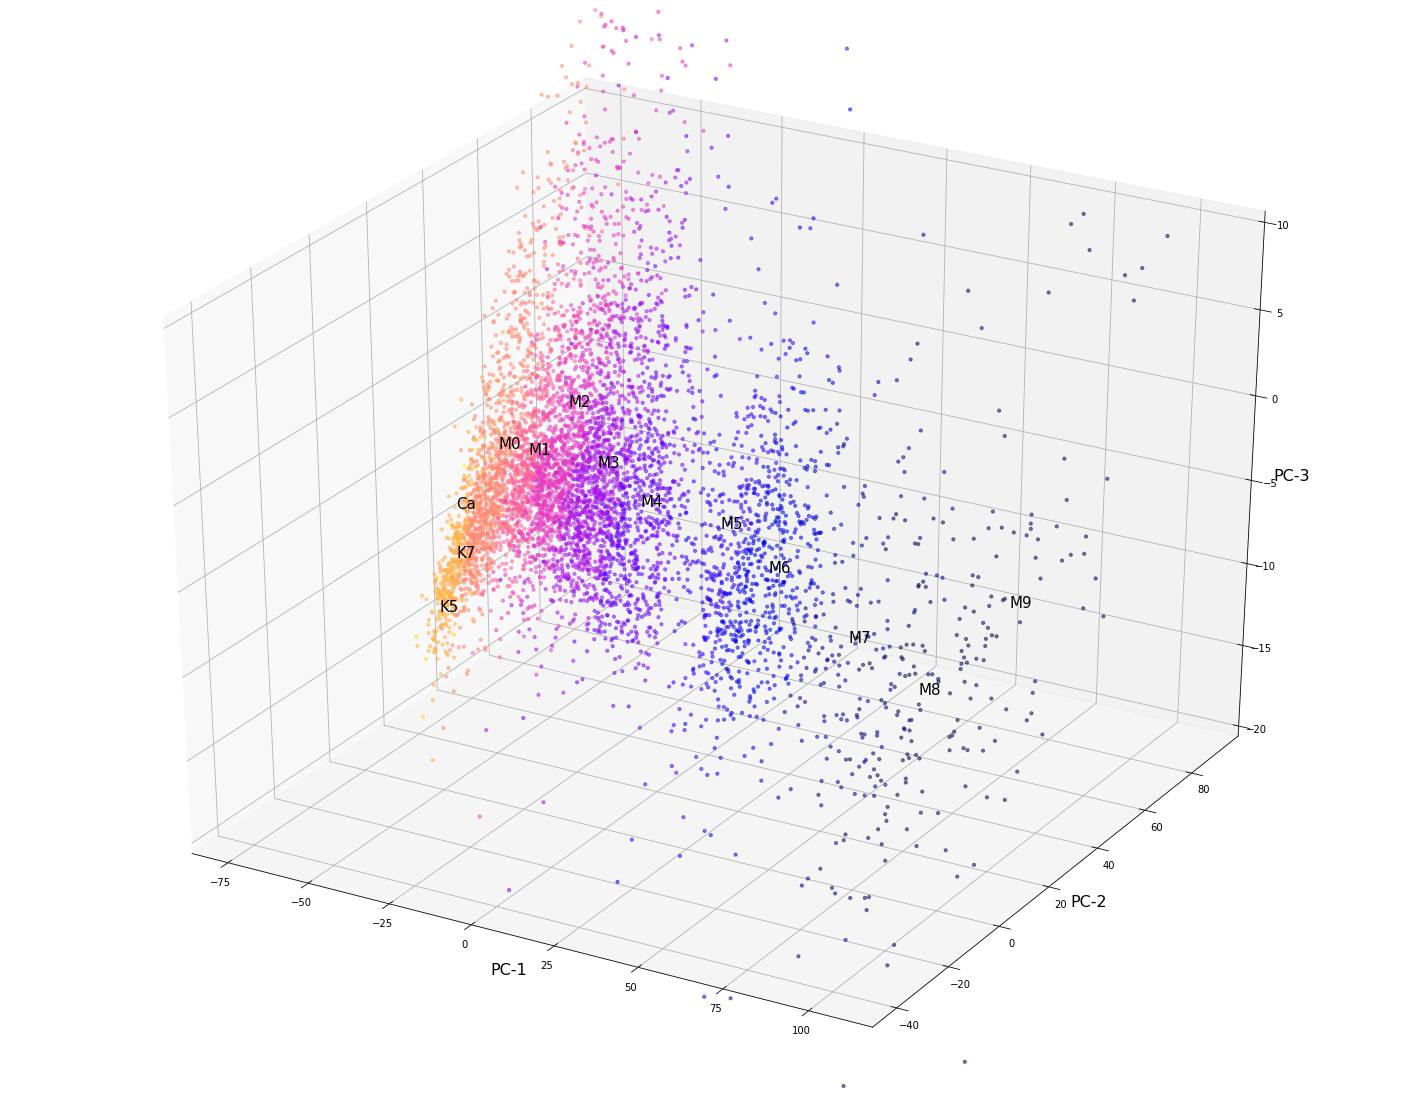

In [ ]:
labels=cod_subclases

fig=plt.figure(figsize = (25, 20))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(X_pca_em[:,0], X_pca_em[:,1],X_pca_em[:,2],cmap=mapa_color ,s=10,c=labels,alpha=0.5)
for clase in df_clases_enanas.index:
    if clase not in ['T2','L9']:
      ax.text(df_clases_enanas.loc[clase][0], df_clases_enanas.loc[clase][1],df_clases_enanas.loc[clase][2],\
            clase,size=15) 
ax.set_xlabel('PC-1',fontsize=16)
ax.set_ylabel('PC-2',fontsize=16)
ax.set_zlabel('PC-3',fontsize=16)
#ax.set_xlim3d(-75,75)
#ax.set_ylim3d( -50, 30)
ax.set_zlim3d(-20, 10)
#plt.show()

### Centroides clases de metalicidad

In [ ]:
df_clase_m_enanas = df_enanas_pca_sin_out.groupby('clase_metalicidad').mean()
df_clase_m_enanas

0         1         2         3         4    \
clase_metalicidad                                                      
dM                  0.559263 -1.241753 -1.472370 -0.300788  0.429382   
esdM              -13.844242  5.528620  8.687684  0.983375 -2.938657   
sdM                 3.859106  3.196956  3.213219  0.945901 -0.706084   
usdM              -22.896198  7.213301  7.957675  1.075632 -3.451717   

                        5         6         7         8         9         10   \
clase_metalicidad                                                               
dM                 0.221939 -0.229917 -0.038487  0.112200 -0.327486 -0.118953   
esdM              -0.950199  1.258385  1.086654 -0.501707  0.913471 -0.462890   
sdM               -0.578404  0.411137 -0.363466 -0.275998  1.083122  0.760583   
usdM              -1.333312  2.472743  2.170502 -0.777157  1.105295 -0.935520   

                        11        12        13        14   ...       225  \
clase_metalicidad                                          ...             
dM                 0.259633  0.097997  0.029942  0.079485  ...  0.004805   
esdM              -0.860615 -0.274447 -0.176988 -0.335187  ...  0.023545   
sdM               -0.828237 -0.285659 -0.075797 -0.209653  ... -0.027354   
usdM              -0.771787 -0.721924 -0.053610 -0.467462  ... -0.011614   

                        226       227       228       229       230       231  \
clase_metalicidad                                                               
dM                 0.005363  0.005641  0.022003  0.006524 -0.000252 -0.000682   
esdM              -0.012557  0.010934 -0.041505  0.022841 -0.020573 -0.013290   
sdM               -0.023573 -0.039947 -0.074218 -0.041396  0.010368  0.003464   
usdM               0.034421  0.117826 -0.120185  0.055854 -0.031905  0.036342   

                        232       233       234       235       236       237  \
clase_metalicidad                                                               
dM                 0.003537  0.004952 -0.007010  0.001529 -0.003395  0.003573   
esdM               0.019244 -0.116206  0.070049 -0.013260  0.043806 -0.004060   
sdM               -0.037239  0.005737  0.010666  0.018414 -0.012475 -0.028190   
usdM               0.161087  0.069491 -0.002319 -0.218477  0.149675  0.137845   

                        238       239  
clase_metalicidad                      
dM                -0.004931 -0.005248  
esdM              -0.050591 -0.011995  
sdM                0.036780  0.017603  
usdM               0.003387  0.096610  

[4 rows x 240 columns]

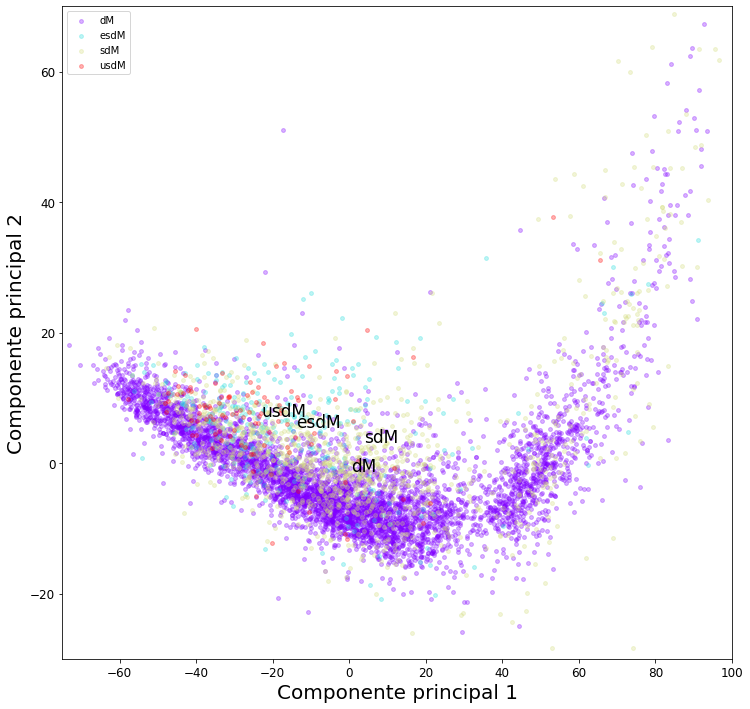

In [ ]:
comp =0
comp_aux =1
fig, ax = plt.subplots(figsize=(12,12))
#ax.scatter(X_pca_em[:,comp], X_pca_em[:,comp_aux] , label = y_m, cmap='gnuplot2',s=15,c=y_m,alpha=0.4)
colors = cm.rainbow(np.linspace(0, 1, len(df_clase_m_enanas.index)))

#['sdM', 'usdM', 'esdM', 'u', 'd']
lista_m = ['sdM', 'usdM', 'esdM', 'dM']
    
for color , clase in zip(colors,df_clase_m_enanas.index):
 
  indices = df_enanas_pca_sin_out.clase_metalicidad==clase
  #ax.scatter(X_pca_em[indices,comp], X_pca_em[indices,comp_aux] , label = clase, cmap='viridis',s=15,c= colores[indices]/5,alpha=0.4)
  if clase in lista_m:
    ax.text(df_clase_m_enanas.loc[clase][comp], df_clase_m_enanas.loc[clase][comp_aux], clase,size=17,c='black') 
    ax.scatter(X_pca_em[indices,comp], X_pca_em[indices,comp_aux] , label = clase, s=15,color=color, alpha=0.3)
ax.set_xlabel('Componente principal '+str(comp+1),fontsize=20)
ax.set_ylabel('Componente principal '+str(comp_aux+1),fontsize=20)
ax.set_xlim(-75,100)
ax.set_ylim(-30,70)
#ax.set_ylim(-30,40)

ax.tick_params(labelsize=12)
plt.legend()


Estas componentes no discriminan entre usdM, esdM y sdM ya que se superponen 

Veamos tres componentes

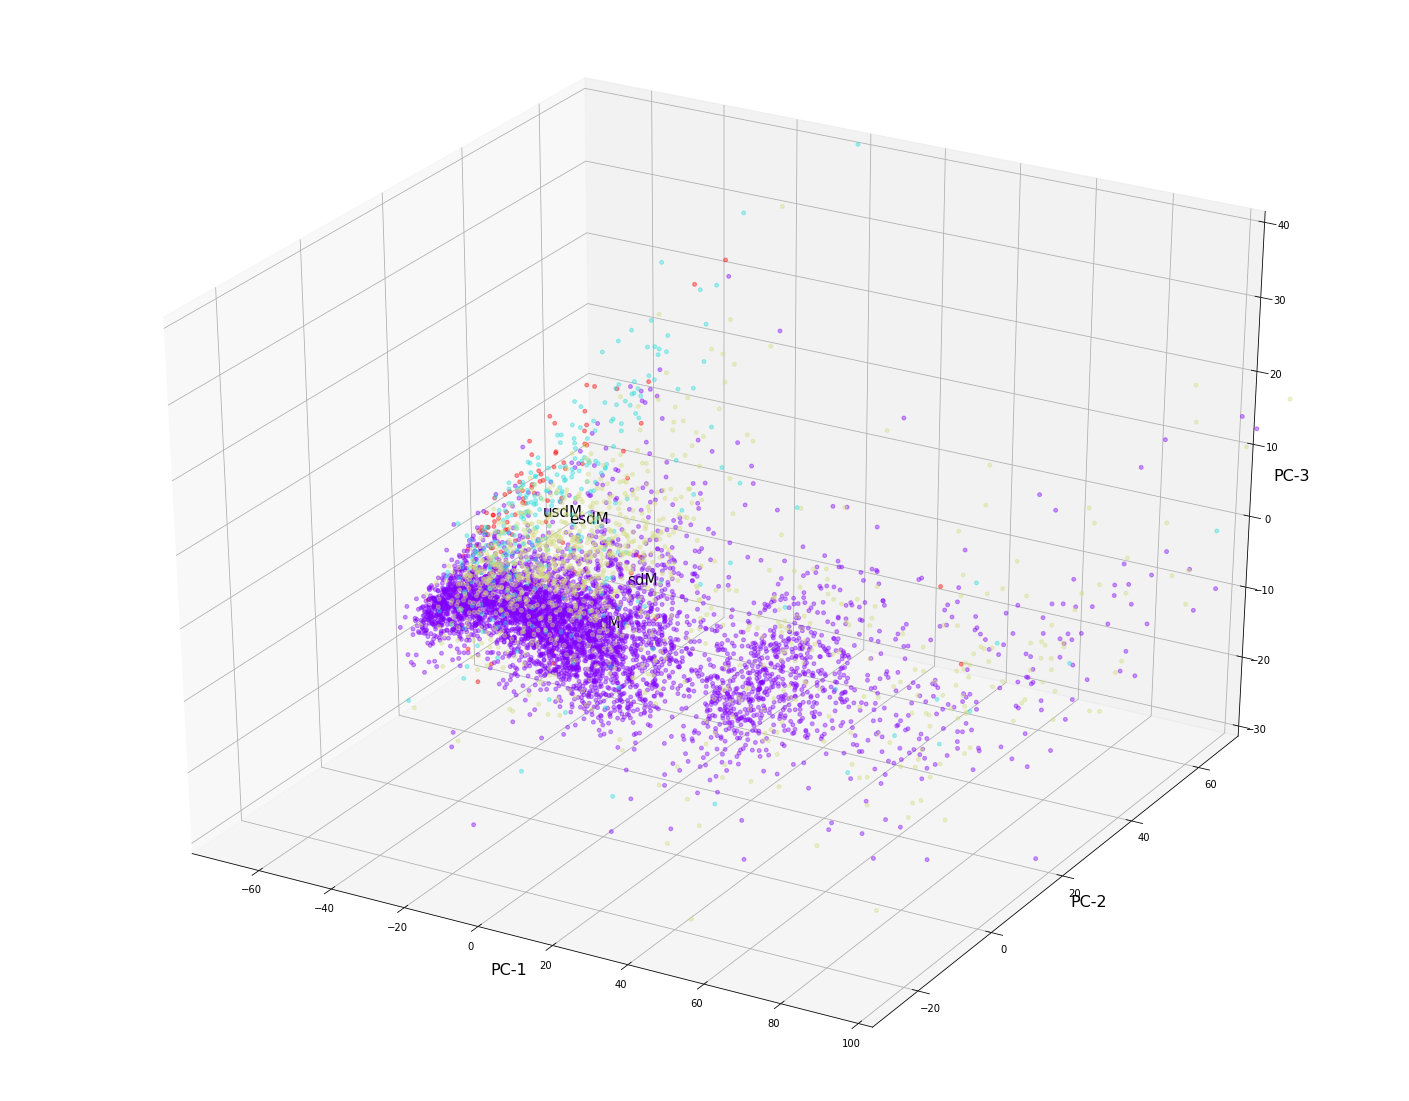

In [ ]:


fig=plt.figure(figsize = (25, 20))
ax = fig.add_subplot(1,1,1, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(df_clase_m_enanas.index)))

    
for color , clase in zip(colors,df_clase_m_enanas.index):
    indices = df_enanas_pca_sin_out.clase_metalicidad==clase

    ax.scatter(X_pca_em[indices,0], X_pca_em[indices,1] ,  X_pca_em[indices,2], label = clase, s=15,color=color, alpha=0.4)
    ax.text(df_clase_m_enanas.loc[clase][0], df_clase_m_enanas.loc[clase][1],df_clase_m_enanas.loc[clase][2],\
            clase,size=15) 
ax.set_xlabel('PC-1',fontsize=16)
ax.set_ylabel('PC-2',fontsize=16)
ax.set_zlabel('PC-3',fontsize=16)
ax.set_xlim(-75,100)
ax.set_ylim(-30,70)
ax.set_zlim(-30,40)
plt.show()

### Valores atípicos.

Analizamos si hay valores atípicos para cada componente principal de las seleccionadass.

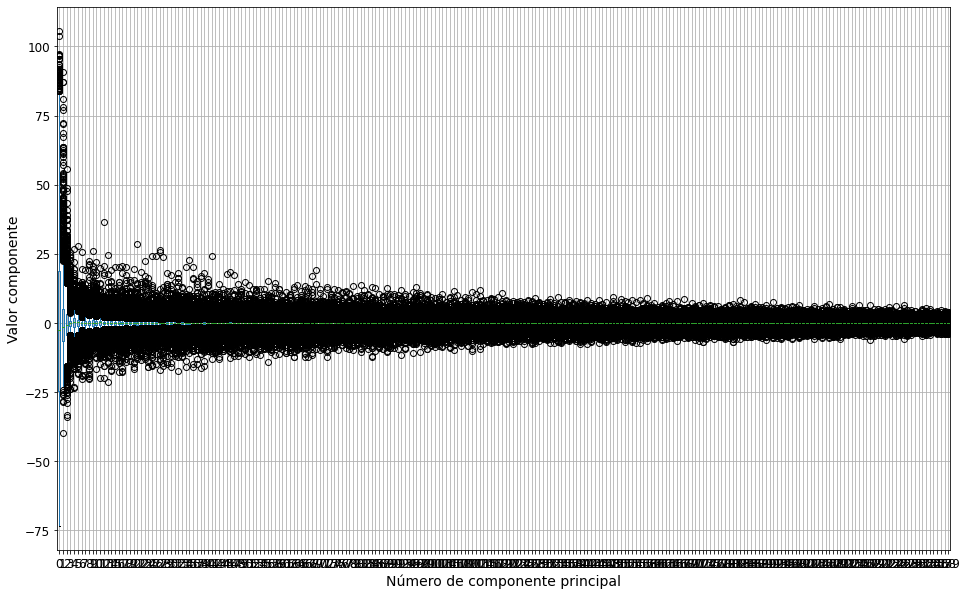

In [ ]:
ax = df_enanas_pca_sin_out.iloc[:,:n_comp_pca].boxplot(figsize=(16,10))
ax.set_xlabel('Número de componente principal',size=14)
ax.set_ylabel('Valor componente',size=14)
ax.tick_params(labelsize=12)

Si no eliminamos los valores atípicos tendremos problemas cuando normalicemos los parámetros. 

Creamos una función para identificar outliers.

In [ ]:
def obtener_outliers(dataframe, n = 3, verbose=True): # 
  '''
  : param: dataframe. El dataframe sobre cuyos valores se estimarán los outliers
  : param: n: margen para considerar un valor outlier
  : return: indices con valor true para las tuplas con outliers
  '''

  mediana = dataframe.median()
  cuartiles = dataframe.quantile([0.25 ,0.75])
  IQR = cuartiles.loc[0.75] - cuartiles.loc[0.25]
  inf = cuartiles.loc[0.25]-IQR*n
  sup = cuartiles.loc[0.25]+IQR*n

  if verbose:
    print('mediana: \n', mediana, '\n')
    print('cuartiles: \n',cuartiles)
    print('IRQ : \n', IQR)
    print('limite inferior para outlier: \n', inf)
    print('limite superior para outlier: \n', sup)
  #return dataframe[(dataframe > inf) & (dataframe < sup)], 
  return ((dataframe < inf) | (dataframe > sup)).any(axis=1)


Nos centramos en las componentes principales más relevantes. Esto se hace para no perder demasidos datos y para conservar información relevante en las componentes principales menos significativas ya que podrían tener información sobre la metalicidad.  

In [ ]:
indices_outliers = obtener_outliers(df_enanas_pca_sin_out.iloc[:,:n_comp_pca],3,verbose = False)
#indices_outliers

In [ ]:
print(f'número de tuplas con outliers {indices_outliers.sum()}')

número de tuplas con outliers 2993


#### Tratamiento valores atípicos

En vez de eliminar los datos añadiremos un atributo que nos indicará si es outlier o no.

In [ ]:
'''
No se usa porque no es util
df_enanas.pca_outlier = indices_outliers
df_enanas_pca.pca_outlier = indices_outliers
'''

'\nNo se usa porque no es util\ndf_enanas.pca_outlier = indices_outliers\ndf_enanas_pca.pca_outlier = indices_outliers\n'

# Preparación de las variables.

Podemos usar las componentes PCA tal cuales, podemos estandarizarlas, normalizarlas y también usar la varianza esplicada de cada componente principal como peso para calcular la distancia. 

Las componentes PCA tienen información de la variabilidad reflejando la importacia de la misma. Es por esto por lo que en principio no vamos ni a estandarizar ni normalizar los datos.

### Escalado de los datos.

In [ ]:
n_comp_pca_clustering = 1 #número de componentes que se usará para hacer clustering

data = df_enanas_pca_sin_out.drop(columns=['subclase','clase_metalicidad']).iloc[:,:n_comp_pca_clustering].values
datos_pca = df_enanas_pca_sin_out.drop(columns=['subclase','clase_metalicidad']).iloc[:,:n_comp_pca].values #guardamos las componentes PCA para representación. 
#sc_pca = StandardScaler()
sc_pca = MinMaxScaler()

sc_pca.fit(data)
#datos = sc_pca.transform(data) #aplicamos la transformación a todos los datos.
datos = data #probamos sin estandarizar



In [ ]:
datos.shape

(6256, 1)

In [ ]:
datos.max()

105.44935991353788

# CLASIFICACIÓN NO SUPERVISADA

## AGREGACIÓN JERÁRQUICA

### Recálculo matriz distancia

In [ ]:
distancia = pdist(datos,metric ='euclidean') # genera una matriz plana con la parte superior triangular de la matriz de distancia. 
#Esta matriz plana es la entrada óptima para el algoritmo
matrizdistancia = squareform(distancia)

In [ ]:
datos.shape

(7634, 115)

### Selección del número de grupos para cada enlace 'ward' y 'complete'

##### Dendrogramas enlace ward y completo

In [ ]:
from scipy import cluster
clusters_w = cluster.hierarchy.linkage(distancia, method = 'ward')
clusters_c = cluster.hierarchy.linkage(distancia, method = 'complete')
f, ax = plt.subplots(1,2,figsize=(18, 8))
cluster.hierarchy.dendrogram(clusters_c, p=5, truncate_mode='level', ax=ax[1])
cluster.hierarchy.dendrogram(clusters_w,p=5,truncate_mode='level', ax=ax[0])

ax[0].set_title('Algoritmo jerarquico con distancia "ward"')
ax[0].set_ylabel('distancia',size=12)
ax[0].tick_params(labelsize=12)
ax[1].set_title('Algoritmo jerarquico con distancia "complete"')
ax[1].tick_params(labelsize=12)
plt.show()

##### Enlace ward

In [ ]:
from scipy import cluster
clusters_w = cluster.hierarchy.linkage(distancia, method = 'ward')



In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
cluster.hierarchy.dendrogram(clusters_w,p=5,truncate_mode='level', ax=ax)
ax.set_title('Algoritmo jerarquico con distancia "ward"')
ax.set_ylabel('distancia',size=12)
ax.tick_params(labelsize=12)
plt.show()

In [ ]:
silu = [] #lista con los coeficientes
n_cluster =[] #lista con los números de cluster.
inicio = 0.3 #depende de las distancias que veamos en el dendrograma 2 nor
final =6 # 7.5 norm
paso =0.2 #0.1 norma
var_cluster = clusters_w  #usamos el obtenido con ward
intervalo= np.arange(inicio, final, paso)

for i in intervalo:
    labels = cluster.hierarchy.fcluster(var_cluster, i , criterion = 'distance')
    silu.append(metrics.silhouette_score(datos, labels))
    n_cluster.append(len(set(labels)) - (1 if -1 in labels else 0))
        

In [ ]:
silu_2 = [] #lista con los coeficientes
n_cluster_2 =[] #lista con los números de cluster.
inicio = 1.4
final =3.8
paso =0.025
var_cluster = clusters_w  #usamos el obtenido con ward
intervalo_2= np.arange(inicio, final, paso)

for i in intervalo_2:
    labels = cluster.hierarchy.fcluster(var_cluster, i , criterion = 'distance')
    silu_2.append(metrics.silhouette_score(datos, labels))
    n_cluster_2.append(len(set(labels)) - (1 if -1 in labels else 0))
        

In [ ]:


fig, ax = plt.subplots(1,2,figsize=(22,10))

ax2 = [ax[0].twinx(),ax[1].twinx()] # ax2 and ax1 will have common x axis and different y axis
ax[0].plot(intervalo, silu , marker='o',label='coef silueta')
ax[1].plot(intervalo_2, silu_2 , marker='o',label='coef silueta')
ax2[0].plot(intervalo, n_cluster , marker='o',c='r', label='nº grupos')
ax2[1].plot(intervalo_2, n_cluster_2 , marker='o',c='r', label='nº grupos')
ax[0].set_ylabel('Coeficiente silueta',size=25)
ax2[1].set_ylabel('Nº grupos', size=25)
ax[0].set_xlabel('Distancia', size=25)

ax[0].set_ylim(min(silu),max(silu)+0.015)
#ax2[0].set_ylim(min(n_cluster),max(n_cluster)+10)
ax[0].legend(loc='upper center',fontsize=18)
ax2[0].legend(loc='upper right',fontsize=18)
ax[0].tick_params(labelsize=20)
ax2[0].tick_params(labelsize=20)

ax[1].set_xlabel('Distancia', size=25)
ax[1].set_ylim(min(silu_2),max(silu_2)+0.005)
#ax2[1].set_ylim(min(n_cluster_2),max(n_cluster_2)+200)
ax[1].legend(loc='upper center',fontsize=18)
ax2[1].legend(loc='upper right',fontsize=18)
ax[1].tick_params(labelsize=20,pad= 10)
ax2[1].tick_params(labelsize=20)

plt.tight_layout(pad=1, w_pad=4, h_pad=1.0)
plt.show()



Diagrama de silueta.

In [ ]:
from sklearn.metrics import silhouette_samples #Nos devuelve el coeficiente silueta de cada muestra
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(15, 12))

#for k, distancia in enumerate([30,40,50,60]):
#for k, distancia in enumerate([135,155,175,195]):
for k, distancia in enumerate([2,2.5,3,3.5]):
#for k, distancia in enumerate([0.9,1,1.4,1.6]):
    plt.subplot(2, 2, k+1)
    etiquetas_w = cluster.hierarchy.fcluster(clusters_w, distancia , criterion = 'distance')
    silhouette_coefficients = silhouette_samples(datos, etiquetas_w)
    n_clusters_ = len(set(etiquetas_w))
    print(n_clusters_)
    padding = datos.shape[0] // 30
    pos = padding
    ticks = []
    for i in range(n_clusters_):
        coeffs = silhouette_coefficients[etiquetas_w == i+1]
        coeffs.sort()

        color = mpl.cm.Spectral((i+1) / n_clusters_)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.9)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(1,n_clusters_+1)))
    if k in (0, 2):
        plt.ylabel("Grupo")
    
    plt.gca().set_xticks([-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8])
    #if k in (2, 3):
      #plt.gca().set_xticks([-1,-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel("Coeficiente silueta")
    #else:
        #plt.tick_params(labelbottom=False)
    plt.xlim(-0.8,0.8)
    plt.axvline(x=metrics.silhouette_score(datos, etiquetas_w), color="red", linestyle="--")
    plt.title("$distancia ={}$".format(distancia, fontsize=16))

#save_fig("silhouette_analysis_plot")
plt.show()


###### Ejecución

Seleccionamos un valor de distancia de 550 y 520

In [ ]:
from scipy import cluster
#etiquetas_w = cluster.hierarchy.fcluster(clusters_w, 200 , criterion = 'distance') #PLC 5
#etiquetas_w = cluster.hierarchy.fcluster(clusters_w, 520 , criterion = 'distance') #PLC 10
#etiquetas_w = cluster.hierarchy.fcluster(clusters_w, 28 , criterion = 'distance') #Std 5PCA 27 ; 45 37
#etiquetas_w = cluster.hierarchy.fcluster(clusters_w, 2 , criterion = 'distance') #Norm 1.3 5PC
etiquetas_w = cluster.hierarchy.fcluster(clusters_w, 2.5 , criterion = 'distance')

In [ ]:
print(f"coeficiente silueta {metrics.silhouette_score(datos, etiquetas_w)}")

In [ ]:
#Esto es si usa sklearn en vez de scipy
cluster_a = AgglomerativeClustering(n_clusters=16, affinity='euclidean', linkage='ward')
cluster_a.fit_predict(datos)


Podemos ver el número de cluster y el coeficiente silhouette

In [ ]:
n_clusters_ = len(set(etiquetas_w))
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(datos, etiquetas_w))

In [ ]:
collections.Counter(etiquetas_w)

Añadimos las etiquetas al dataset

In [ ]:
df_enanas_sin_out['hierarchy_ward'] = etiquetas_w
df_enanas_pca_sin_out['hierarchy_ward'] = etiquetas_w

### Análisis resultado

Distribución de subclases por grupos

In [ ]:
frecuencias = pd.crosstab(df_enanas_sin_out['hierarchy_ward'], df_enanas_sin_out['subclass']) 
frecuencias_subclase = frecuencias.copy()
frecuencias.drop(columns=['Ca'],inplace=True)
#frecuencias.drop(columns=['BR','L0','Ca'],inplace=True)
#frecuencias

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs = pd.crosstab(df_enanas_sin_out['hierarchy_ward'],df_enanas_sin_out['clase_metalicidad']) 
frec_cluster_metal_obs=frec_cluster_metal_obs[['dM','sdM','esdM','usdM']]
frec_cluster_metal_obs

Ordenamos los índices -etiquetas grupo- por la posición de la subclase con mayor número de elementos para cada grupo y por la clase de metalicidad más numerosa en el cluster

In [ ]:
k=list(zip(frecuencias.index,np.argmax(frecuencias.values, axis=1),
           np.argmax(frec_cluster_metal_obs.values, axis=1)))
k.sort(key=lambda x: x[2])
k.sort(key=lambda x: x[1])

Extraemos los grupos ordenados según el criterio anterior

In [ ]:
grupos = [x[0] for x in k]
grupos

Se crea un diccionario para renombrar las clases

In [ ]:
new_grupos = dict(zip(grupos, np.arange(1,len(grupos)+1))) 
new_grupos

In [ ]:
df_enanas_sin_out['hierarchy_ward'].replace(new_grupos,inplace=True)
df_enanas_pca_sin_out['hierarchy_ward'].replace(new_grupos,inplace=True)

#### Calculamos para cada grupo los espectro esperados por metalicidad.

En frecuencias_metal tenemos las metalicidades por subclase observadas

In [ ]:
frecuencias_metal = pd.crosstab(df_enanas_sin_out['clase_metalicidad'],df_enanas_sin_out['subclass']) 
#frecuencias_metal.drop(columns=['L0','BR','Ca'],inplace=True)
#frecuencias_metal.reset_index(inplace=True)
frecuencias_metal

Calculamos para cada metalicidad la fracción por subclase

In [ ]:
frac_metal=frecuencias_metal.T.apply(lambda x: x/x.sum(),axis=1)
frac_metal.T

#### Tabla ordenada de composición de cada clúster. Subclases y clase de metalicidad

Calculamos por cada grupo el número de objetos por subclase esperado si la distribución fuera aleatoria. Para ello multiplicamos para cada cluster el número de enanas de cada subclase por  la fracción de cada metalicidad en la subclase y sumamos para cada metalicidad

In [ ]:
frecuencias = pd.crosstab(df_enanas_sin_out['hierarchy_ward'], df_enanas_sin_out['subclass']) 
frecuencias_subclase = frecuencias.copy()
#calculamos las frecuencias esperadas
frec_cluster_metal = pd.DataFrame(data=np.dot(frac_metal.T.values,frecuencias_subclase.T.values),
                                  columns=frecuencias_subclase.index,
                                  index=frecuencias_metal.index).astype(int).T
frec_cluster_metal = frec_cluster_metal[['dM','sdM','esdM','usdM']]

frec_cluster_metal.rename(columns= lambda x: 'f_'+x, inplace=True)
frecuencias.drop(columns=['Ca'],inplace=True)
frec_cluster_metal_obs = pd.crosstab(df_enanas_sin_out['hierarchy_ward'],df_enanas_sin_out['clase_metalicidad']) 
frec_cluster_metal_obs=frec_cluster_metal_obs[['dM','sdM','esdM','usdM']]
df_distribucion = pd.concat([frecuencias,frec_cluster_metal_obs,frec_cluster_metal],axis=1)
df_distribucion


Para tener una referencia calculamos la entropia de las subclases, las subenanas y las frencuencia esperada de subenanas.

###### Entropía

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

In [ ]:
from scipy.stats import entropy
columns = ['dM','sdM','esdM','usdM']
columns_f = ['f_'+x for x in columns]
n_subclases = len(set(df_distribucion.columns)-set(columns)-set(columns_f))
entropia_subclases = entropy(df_distribucion.drop(columns=columns+columns_f).values)#.sum()/n_subclases
entropia_grupos = entropy(df_distribucion.drop(columns=columns+columns_f).values.T)

In [ ]:
print(f"entropia subclases {entropia_subclases.sum()/len(set(df_distribucion.columns)-set(columns+columns_f))}")
print(f"entropia grupos {entropia_grupos.sum()/len(df_distribucion.index)}")

In [ ]:
entropia_subclases.shape

In [ ]:
entropia_grupos.shape

In [ ]:
entropy(df_distribucion[columns].values.T).sum() #entropía distribución observada

In [ ]:
np.nan_to_num(entropy(df_distribucion[columns_f].values.T), nan=0).sum() #entropia distribución esperada

#### Representación gráfica

In [ ]:
unique, counts = np.unique(df_enanas_pca_sin_out['hierarchy_ward'], return_counts=True)
unique

In [ ]:
eliminar=[]
for columna in df_enanas_pca_sin_out.columns:
  if type(columna)==str:
    eliminar.append(columna)
df_centroides_jera_ward = pd.DataFrame(columns=df_enanas_pca_sin_out.drop(columns=eliminar).columns,\
                                       index=unique)
for  clase in unique:
  indices = df_enanas_pca_sin_out['hierarchy_ward']==clase
  df_centroides_jera_ward.loc[clase]=datos_pca[indices].mean(axis=0)
#df_centroides_jera_ward

In [ ]:
comp = 0
comp2 = [1,2]

y_inf = [-30, -30]
y_sup = [60, 50]

colors = cm.rainbow(np.linspace(0, 1, len(unique)))

fig, ax_ = plt.subplots(1,2,figsize=(30,15))

for i, comp_aux in enumerate(comp2):

  ax=ax_[i]
  for color , cluster in zip(colors,unique):
  
    indices = df_enanas_pca_sin_out.hierarchy_ward==cluster
    ax.scatter(datos_pca[indices,comp], datos_pca[indices,comp_aux] , label = clase, s=20,color=color, alpha=0.6)
    ax.text(df_centroides_jera_ward.loc[cluster,comp], df_centroides_jera_ward.loc[cluster,comp_aux]+2, cluster,size=30,c='black')
  #centroides

  ax.scatter(df_centroides_jera_ward.loc[:,comp], df_centroides_jera_ward.loc[:,comp_aux], c='black',s=120)

  for clase in df_clases_enanas.index:
    if clase not in ['T2','L9','L0']:
      ax.text(df_clases_enanas.loc[clase][comp], df_clases_enanas.loc[clase][comp_aux], clase,size=30,c='red') 

  #ax.scatter(datos[:,comp], datos[:,comp_aux] , label = clase, s=15,color=color, alpha=0.6)
  #ax.set_xlim(-75,75)
  ax.set_ylim(y_inf[i], y_sup[i])
  #ax.set_ylim(-15,10)

  ax.set_xlabel('Componente principal 1',size=30)
  ax.set_ylabel('Componente principal '+str(comp_aux+1),size = 30)
  ax.tick_params(labelsize=25)
#plt.title('Clusters y centroides')
  plt.tight_layout(pad=2, w_pad=4)#, h_pad=1.0)


### Vamos a establecer un criterio de bondad comparando con las subclases. NO USADO

In [ ]:
nuevas_columnas = {'K5':-2,'K7':-1,'M0':0,'M1':1,'M2':2,'M3':3,'M4':4,'M5':5,'M6':6,'M7':7,'M8':8,'M9':9}
frecuencias.rename(columns=nuevas_columnas,inplace=True)
frecuencias.columns

In [ ]:
new_index={}
for i in frecuencias.index:
  serie_i=frecuencias.loc[i]
  new_index[i]=serie_i.where(serie_i==serie_i.max()).dropna().index[0]
new_index

In [ ]:
new_index[2]=1
new_index[5]=3
new_index

In [ ]:
frecuencias.rename(index=new_index,inplace=True)

In [ ]:
frecuencias

In [ ]:
dic_dif={}
for m, i in enumerate(frecuencias.index):
  for k in frecuencias.columns:
    if frecuencias.iloc[m][k]!=0:
      dif=i-k
      if dif in dic_dif.keys():
        dic_dif[dif]=dic_dif[dif]+frecuencias.iloc[m][k]
      else:
        dic_dif[dif]=frecuencias.iloc[m][k]


In [ ]:
dic_dif

In [ ]:
#Creamos otro diccionario para 6 clústers
#dic_dif_6=dic_dif.copy()

In [ ]:
#fig= plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
width = 0.4
ax.bar(list(dic_dif.keys()), dic_dif.values(),width, color='b',alpha=0.7)
ax.bar(np.asarray(list(dic_dif_6.keys()))+width, dic_dif_6.values(), width,color='r',alpha=0.7)
plt.xticks(np.asarray(list(dic_dif.keys())) + width / 2,list(dic_dif.keys()))

Creamos una lista con las diferencias.

In [ ]:
list_diferencias=[]
for clave, valor in dic_dif.items():
 list_diferencias=list_diferencias+[clave]*valor


Calculamos el error. 

In [ ]:
np.std(list_diferencias)

### Aplicamos una prueba chi-cuadrado. NO USADO

In [ ]:
# clases de metalicidad observadas por clúster


In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs = pd.crosstab(df_enanas_sin_out['clase_metalicidad'],df_enanas_sin_out['hierarchy_ward']) 
frec_cluster_metal_obs

In [ ]:
chisquare(frec_cluster_metal_obs,f_exp=frec_cluster_metal,ddof=9,axis=None)

Prueba Chi-cuadrado
* chi2: la estadística de prueba
* p: el valor p de la prueba
* dof: grados de libertad
* esperado: las frecuencias esperadas, basadas en las sumas marginales de la tabla

In [ ]:
c, p, dof, expected = chi2_contingency(frec_cluster_metal_obs)

In [ ]:
p

In [ ]:
from scipy.stats import chisquare
chisquare([100, 10, 10, 10, 10, 10],f_exp=[90, 10, 10, 10, 10, 10])

In [ ]:
obs=np.asarray([[6, 14,17,9],[30, 32,17,3]])
exp=expected_freq(obs)
chisquare(obs,f_exp=exp,ddof=0,axis=None)

In [ ]:
chisquare(obs,axis=None)

In [ ]:
from scipy.stats.contingency import expected_freq
observed = np.array([[50, 25],[40, 45]])
expected_freq(observed)

## K-MEANS

### Parametrization



En primer lugar vamos a establecer los parámetros que vamos a considerar por defecto

In [ ]:
# carga librerías

from sklearn.cluster import KMeans
from sklearn import metrics

# parameters
init = 'k-means++' # initialization method 

# to run 10 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 15

# maximum number of iterations for each single run
max_iter = 300 

# controls the tolerance with regard to the changes in the 
# within-cluster sum-squared-error to declare convergence

tol = 1e-04 

 # random seed. Fijamos la secuencia de números aleatorios.
random_state = 0

In [ ]:
datos.shape

(7634, 1)

### Selección del número de clústeres



Vamos a elegir K dependiendo de los valores que tome el clustering en cuanto a Distorsión (SSE) y Silhouette desde k = 5 a k = 40


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []

max_rango = 35
#max_rango = 20
min_rango = 3
rango = range(min_rango,max_rango)
for i in rango:
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    etiquetas = km.fit_predict(datos)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(datos, etiquetas)) 

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,8))

ax2 = ax1.twinx()
ax1.plot(rango, distortions, marker='o', label = 'distorsión')
ax2.plot(rango, silhouettes, c='r',marker='o', label = 'coef. silueta')


ax1.set_xlabel('número de clusters',size=15)
ax1.set_ylabel('Distorsión',size=15)
ax2.set_ylabel('Coeficiente silueta',size=15)
#ax2.set_title('Silhouette y distorsion vs clusters K-means')


ax1.legend(loc='best',fontsize=12)
ax2.legend(loc='upper center',fontsize=12)

ax1.tick_params(labelsize=12,labelrotation=90)
plt.xticks(np.arange(min_rango, max_rango))
plt.show()

El silohouette cuanto más cerca de 1 mejor. La distorsión cuanto menor menor. Luego hay que coger un punto intermedio. Es la interpretación de los grupos lo que nos dará la bondad de la decisión.



Inspeccionamos el diagrama silueta para distintos k

In [ ]:
set(etiquetas)

In [ ]:
from sklearn.metrics import silhouette_samples #Nos devuelve el coeficiente silueta de cada muestra
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(15, 12))

for j, k in enumerate([8,9,10,11]):
#for j, k in enumerate([9,11,14,17]): #normalizados
#for j, k in enumerate([10,14,17,20]): #PCA 45
    plt.subplot(2, 2, j+1)
    km = KMeans(k, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    etiquetas = km.fit_predict(datos)
    silhouette_coefficients = silhouette_samples(datos, etiquetas)
    n_clusters_ = len(set(etiquetas))
    print(n_clusters_)
    padding = datos.shape[0] // 30
    pos = padding
    ticks = []
    for i in range(n_clusters_+1):
        coeffs = silhouette_coefficients[etiquetas == i]
        coeffs.sort()

        color = mpl.cm.Spectral((i+1) / n_clusters_)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.9)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(0,n_clusters_+1)))
    if k in (0, 2):
        plt.ylabel("Grupo")
    
    plt.gca().set_xticks([-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8])
    #if k in (2, 3):
      #plt.gca().set_xticks([-1,-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel("Coeficiente silueta")
    #else:
        #plt.tick_params(labelbottom=False)
    plt.xlim(-0.4,1)
    plt.axvline(x=metrics.silhouette_score(datos, etiquetas), color="red", linestyle="--")
    plt.title(f"número de grupos ={k}", fontsize=12)

#save_fig("silhouette_analysis_plot")
plt.show()


### Ejecución del Algoritmo

In [ ]:
k = 9
km_EM = KMeans(k, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

y_km_EM = km_EM.fit_predict(datos)

In [ ]:
print(f"Coeficiente silueta {metrics.silhouette_score(datos, y_km_EM)}")

Coeficiente silueta 0.5257213822252806


In [ ]:
print(f"Coeficiente distorsion {km_EM.inertia_}")


Coeficiente distorsion 134639.9383505457


In [ ]:
unique, counts = np.unique(y_km_EM, return_counts=True)
dic_clases =dict(zip(unique, counts))
dic_clases

{0: 1326, 1: 274, 2: 965, 3: 563, 4: 1391, 5: 972, 6: 456, 7: 596, 8: 1091}

Añadimos a los dataset las etiquetas. Sumamos uno para que el primer grupo sea el 1

In [ ]:
df_enanas_sin_out['clases_kmeans'] = y_km_EM+1
df_enanas_pca_sin_out['clases_kmeans'] = y_km_EM+1

In [ ]:
df_enanas_pca_sin_out.shape

(7634, 243)

### Análisis resultado

Distribución de subclases por grupos

In [ ]:
frecuencias = pd.crosstab(df_enanas_sin_out['clases_kmeans'], df_enanas_sin_out['subclass']) 
frecuencias_subclase = frecuencias.copy()
#frecuencias.drop(columns=['BR','Ca'],inplace=True)
#frecuencias.drop(columns=['BR','L0','Ca'],inplace=True)
frecuencias

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs = pd.crosstab(df_enanas_sin_out['clases_kmeans'],df_enanas_sin_out['clase_metalicidad']) 
frec_cluster_metal_obs=frec_cluster_metal_obs[['dM','sdM','esdM','usdM']]
#frec_cluster_metal_obs

Ordenamos los índices -etiquetas grupo- por la posición de la subclase con mayor número de elementos para cada grupo y por la clase de metalicidad más numerosa en el cluster

In [ ]:
k=list(zip(frecuencias.index,np.argmax(frecuencias.values, axis=1),
           np.argmax(frec_cluster_metal_obs.values, axis=1)))
k.sort(key=lambda x: x[2])
k.sort(key=lambda x: x[1])

In [ ]:
k

Extraemos los grupos ordenados según el criterio anterior

In [ ]:
grupos = [x[0] for x in k]
grupos

Se crea un diccionario para renombrar las clases

In [ ]:
new_grupos = dict(zip(grupos, np.arange(1,len(grupos)+1))) 
orden= np.asarray(list(new_grupos))-1
new_grupos
#orden

In [ ]:
df_enanas_sin_out['clases_kmeans'].replace(new_grupos,inplace=True)
df_enanas_pca_sin_out['clases_kmeans'].replace(new_grupos,inplace=True)

#### Calculamos para cada grupo los espectro esperados por metalicidad.

En frecuencias_metal tenemos las metalicidades por subclase observadas

In [ ]:
frecuencias_metal = pd.crosstab(df_enanas_sin_out['clase_metalicidad'],df_enanas_sin_out['subclass']) 
#frecuencias_metal.drop(columns=['L0','BR','Ca'],inplace=True)
#frecuencias_metal.reset_index(inplace=True)
frecuencias_metal

Calculamos para cada metalicidad la fracción por subclase

In [ ]:
frac_metal=frecuencias_metal.T.apply(lambda x: x/x.sum(),axis=1)
frac_metal.T

Calculamos por cada grupo el número de objetos por subclase esperado si la distribución fuera aleatoria. Para ello multiplicamos para cada cluster el número de enanas de cada subclase por  la fracción de cada metalicidad en la subclase y sumamos para cada metalicidad

#### Tabla ordenada de composición de cada clúster. Subclases y clase de metalicidad

In [ ]:
frecuencias = pd.crosstab(df_enanas_sin_out['clases_kmeans'], df_enanas_sin_out['subclass']) 
frecuencias_subclase = frecuencias.copy()
#frecuencias.drop(columns=['BR','Ca'],inplace=True)

frec_cluster_metal = pd.DataFrame(data=np.dot(frac_metal.T.values,frecuencias_subclase.T.values),
                                  columns=frecuencias_subclase.index,
                                  index=frecuencias_metal.index).astype(int).T
frec_cluster_metal = frec_cluster_metal[['dM','sdM','esdM','usdM']]
frec_cluster_metal.rename(columns= lambda x: 'f_'+x, inplace=True)

frec_cluster_metal_obs = pd.crosstab(df_enanas_sin_out['clases_kmeans'],df_enanas_sin_out['clase_metalicidad']) 
frec_cluster_metal_obs=frec_cluster_metal_obs[['dM','sdM','esdM','usdM']]
df_distribucion = pd.concat([frecuencias,frec_cluster_metal_obs,frec_cluster_metal],axis=1)
df_distribucion


###### Entropía

In [ ]:
from scipy.stats import entropy
columns = ['dM','sdM','esdM','usdM']
columns_f = ['f_'+x for x in columns]
n_subclases = len(set(df_distribucion.columns)-set(columns)-set(columns_f))
entropia_subclases = entropy(df_distribucion.drop(columns=columns+columns_f).values)#.sum()/n_subclases
entropia_grupos = entropy(df_distribucion.drop(columns=columns+columns_f).values.T)

In [ ]:
print(f"entropia grupos {entropia_grupos.sum()/len(df_distribucion.index)}")
print(f"entropia subclases {entropia_subclases.sum()/len(set(df_distribucion.columns)-set(columns+columns_f))}")


In [ ]:
entropy(df_distribucion[columns].values.T).sum()

In [ ]:
np.nan_to_num(entropy(df_distribucion[columns_f].values.T), nan=0).sum()

#### Representación gráfica

In [ ]:
unique, counts = np.unique(df_enanas_pca_sin_out['clases_kmeans'], return_counts=True)
unique

In [ ]:
comp = 0
comp2 = [1,2]

y_inf = [-30, -30]
y_sup = [60, 45]

colors = cm.rainbow(np.linspace(0, 1, len(unique)))[::-1]

centroides = km_EM.cluster_centers_[orden]
#Si hemos escalado las características.
#centroides = sc_pca.inverse_transform(km_EM.cluster_centers_[orden])

fig, ax_ = plt.subplots(1,2,figsize=(30,15))

for i, comp_aux in enumerate(comp2):

  ax=ax_[i]
  for color , cluster in zip(colors,unique-1):

    indices = df_enanas_pca_sin_out.clases_kmeans==cluster+1 #Hemos incrementado en 1 la clase en el dataset
    ax.scatter(datos_pca[indices,comp], datos_pca[indices,comp_aux] , s=22,color=color, alpha=0.6)
    ax.text(centroides[cluster,comp]-4, centroides[cluster,comp_aux], cluster+1,size=35,c='black')#sumamos 1
    #ax.text(centroides[cluster,comp], -20, cluster+1,size=20,c='black') #si solo se usa una componente principal



  for clase in df_clases_enanas.index:
    if clase not in ['T2','L9']:
      ax.text(df_clases_enanas.loc[clase][comp], df_clases_enanas.loc[clase][comp_aux], clase,size=35,c='red') 

  #ax.scatter(datos[:,comp], datos[:,comp_aux] , label = clase, s=15,color=color, alpha=0.6)
  ax.set_xlim(-70,100)
  ax.set_ylim(y_inf[i], y_sup[i])
  #ax.set_ylim(-30,40)

  ax.set_xlabel('Componente principal 1',size=30)
  ax.set_ylabel('Componente principal '+str(comp_aux+1),size = 30)
  ax.tick_params(labelsize=25)

  plt.tight_layout(pad=2, w_pad=4)#, h_pad=1.0)



#### Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix_2(y_true, y_pred, normalize=False, title=None, y_ticks = None, label_x=None, label_y=None ,verbose = False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if verbose:
          print(cm.shape)
          print("Normalized confusion matrix")
    else:
        if verbose:
          print('Confusion matrix, without normalization')

    #print(cm)

    #COMIENZA EL GRÁFICO
    fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
  
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
            )
    
    if y_ticks.any()!=None:
      ax.set_yticklabels(y_ticks)
    
    ax.set_ylabel(label_y, size = 15 )
    ax.set_xlabel(label_x, size = 15 )

    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor",size=15)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor",size=15)

    

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black") #va es vertical aligment
    fig.tight_layout()
    return ax

In [ ]:
label_y = 'clases de metalicidad',

In [ ]:
cod_clase_espectral = LabelEncoder()
clase_espectral=cod_clase_espectral.fit_transform(df_enanas_sin_out.subclass)+1

In [ ]:
eje_y = cod_clase_espectral.inverse_transform((np.unique(clase_espectral)-1))

Comparación entre grupos y clases SDSS

In [ ]:
df_enanas_sin_out['subclass'].unique()

In [ ]:
plot_confusion_matrix_2(clase_espectral,df_enanas_sin_out['clases_kmeans'],  normalize=True, y_ticks = eje_y,
                      label_y = 'Subclases SDSS', label_x = 'Clases K-means', title=' ',cmap = cm.YlOrRd)

##Expectación-Maximización

### Parametrización

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html
from sklearn.mixture import BayesianGaussianMixture

In [ ]:
k=45
cv_type='full'
gmm = BayesianGaussianMixture(n_components=k, covariance_type=cv_type, n_init= 5, weight_concentration_prior_type= 'dirichlet_process', random_state = 0, init_params='kmeans')
etiquetas = gmm.fit_predict(datos)

In [ ]:
np.round(gmm.weights_,2)

In [ ]:
gmm.weights_.sum()

In [ ]:
gmm.means_.shape

In [ ]:
gmm.converged_

In [ ]:
gmm.predict_proba(datos)[0]

#Predict posterior probability of each component given the data.

In [ ]:
gmm.get_params()

In [ ]:
gmm.score(datos)

Utilizamos BIC para determinar el tipo de covarianza y el número de componentes.

In [ ]:
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
lowest_bic = np.infty
lowest_aic = np.infty
bic = []
aic=[]

cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1,10)
#n_components_range = range(4,40)
for cv_type in cv_types:
    for k in n_components_range:
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type, random_state = 0, n_init= 10, init_params='kmeans')
        gmm.fit(datos)
        bic.append(gmm.bic(datos)) #bayesian information criteria. Mejor cuanto más bajo. Penaliza la complejidad
        #aic.append(gmm.aic(datos)) #bayesian information criteria. Mejor cuanto más bajo. Penaliza la complejidad
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_cv = cv_type
            best_k = k
        #if aic[-1] < lowest_aic:
            #lowest_aic = aic[-1]
            #best_cv_aic = cv_type
            #best_k_aic = k
            
print ("Criterio BIC: Mejor valor K", best_k, "Mejor tipo de Covarianza", best_cv)
#print ("Criterio AIC: Mejor valor K", best_k_aic, "Mejor tipo de Covarianza", best_cv_aic)

In [ ]:
bic

In [ ]:
#bic #5 std

In [ ]:
#bic  45 standarscaler

In [ ]:
'''
Variables estandarizadas
bic = [643412.1592159402,
 624402.2983259093,
 615356.3861775781,
 609718.7289505051,
 606294.5700848552,
 604349.1036889728,
 596157.863693546,
 590887.8984700214,
 587173.9162739073,
 586828.3814183179,
 588262.1739619646,
 582476.0333653619,
 582802.2925324697,
 581713.2931020821,
 582795.7939010084,
 583720.2015585921,
 583174.5103361764,
 580451.9711972086,
 579732.7736877442,
 578124.5826494931,
 576549.1505906888,
 575154.5658860162,
 575537.4433700206,
 575662.2862488477,
 576009.6972600336,
 575341.4273914548,
 575790.9967322422,
 933573.8043650012,
 930934.324227947,
 927798.0797092165,
 925144.7352443661,
 924409.8277979865,
 922319.2978519815,
 921444.8339339856,
 920299.9571833363,
 919487.1148710472,
 918453.9622923894,
 917252.6648702638,
 916431.207267275,
 915087.7136036792,
 915078.6581695626,
 913567.2756698419,
 913453.5813326855,
 911636.3332992343,
 912113.2946167897,
 910840.2970562791,
 910122.7699810822,
 908282.9408976682,
 908637.3766786363,
 907614.3457207895,
 907169.2864063634,
 907255.5590811855,
 906756.2124072908,
 905597.7022955479,
 618772.8672845385,
 606718.6404218972,
 597909.5012806457,
 597003.0658997075,
 591123.5080170279,
 586311.9324192132,
 585583.0622400165,
 583161.127861647,
 579883.4690173143,
 578522.9506782689,
 577574.820184984,
 574972.0256902619,
 574001.4604192101,
 572791.6851805979,
 572329.0135196701,
 572298.260365943,
 570963.3265530306,
 572434.6646971146,
 571587.3169438167,
 572089.8992015305,
 572152.3647153835,
 570562.8345727377,
 570043.7125302054,
 570127.2135029592,
 569556.9435695639,
 569332.8597504749,
 569802.4107503258,
 577879.2917564656,
 561827.9789422891,
 556420.135631817,
 555498.4899933621,
 564347.6351283457,
 568999.1970797174,
 574943.744254841,
 579468.1952927314,
 588341.4461731578,
 591884.7695157407,
 593699.9032684404,
 598591.116289895,
 605607.6749469242,
 614567.9586440134,
 620013.6128727759,
 620542.1086054596,
 627690.360917897,
 614420.0418956886,
 626997.6247834583,
 619933.1807520745,
 627122.8091412876,
 637982.8841884907,
 647804.944965326,
 657320.7477442587,
 660475.5643203203,
 669619.0414135904,
 676175.3417555611]

In [ ]:
aic

In [ ]:
'''
variables estandarizadas

aic = [891371.8183360837,
 891138.8100217876,
 890320.1823587748,
 888842.3912579138,
 616253.3238269323,
 603567.4758771226,
 594126.7156487027,
 592588.6591805959,
 586077.4802107478,
 580634.2835257647,
 579273.7922593995,
 576220.2367938616,
 572310.9568623604,
 570318.8174361465,
 568739.0658556931,
 565504.6502738025,
 563902.4639155823,
 562061.0675898016,
 560966.7748417053,
 560304.4006008097,
 558337.8457007289,
 559177.5627576443,
 557698.593917178,
 557569.5550877233,
 557000.3995144079,
 554779.2482845936,
 553628.5051548928,
 553080.3850404781,
 551878.4940199143,
 551022.7891136569,
 550860.7190263392,
 547873.819670429,
 524319.4036119764,
 511408.4570572283,
 502983.7081744973,
 504329.7500652048,
 501478.2087723005,
 499919.65270314796,
 496941.0004967623,
 498311.1481329126,
 494351.3682312194,
 488663.398739643,
 486051.5085168215,
 485564.9639295746,
 487022.14438238775,
 484964.6953668741,
 477990.0878552817,
 477635.2369234431,
 456861.8146569586,
 461936.2943004523,
 447368.74702479236,
 447055.27216972935,
 450412.24397265643,
 452731.20150521555,
 454743.9010398723,
 450395.6143716577,
 452035.9882206518,
 451089.1853183463]

In [ ]:
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
import itertools

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(14, 10))

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color, alpha=0.8))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC por modelo')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
#plt.ylim(3e6,5.5e6)
#plt.ylim(6.5e4,75e3)
#plt.ylim(-1.7e6,-1.45e6) #normalizadas
plt.ylabel('BIC',size=15)
plt.xlabel('Número de componentes',size=15)
plt.gca().tick_params(labelsize=12)
plt.legend([b[0] for b in bars], cv_types,fontsize=10)

In [ ]:
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
import itertools

aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the aic scores
plt.figure(figsize=(14, 10))

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color, alpha=0.8))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('aic por modelo')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
#plt.ylim(0.875e6,0.98e6)
#plt.ylim(4.0e5,5.5e5) #estandarizadas
#plt.ylim(-1.76e6,-1.5e6) #normalizadas

plt.ylabel('aic',size=15)
plt.xlabel('Número de componentes',size=15)
plt.gca().tick_params(labelsize=12)
plt.legend([b[0] for b in bars], cv_types,fontsize=10)

Vemos que full es el mejor.

### Ejecución del algoritmo

In [ ]:
k=6
cv_type='full'
gmm = GaussianMixture(n_components=k, covariance_type=cv_type, n_init= 10, random_state = 0, init_params='kmeans')
etiquetas = gmm.fit_predict(datos)

In [ ]:
print(f"Criterio de BIC {gmm.bic(datos)}")

Criterio de BIC 594723.2180220977


In [ ]:
datos.max()

Podemos ver que ha convergido

In [ ]:
gmm.converged_


In [ ]:
gmm.weights_

In [ ]:
df_enanas_pca_sin_out['gmm_grupos']=etiquetas
df_enanas_sin_out['gmm_grupos']=etiquetas

In [ ]:
unique, counts = np.unique(etiquetas, return_counts=True)
dict(zip(unique, counts))

### Agrupamiento suave. NO USADO

Calculamos la probabilidad de pertenencia de cada elemento a un grupo

In [ ]:
prob_item_grupo = gmm.predict_proba(datos)


In [ ]:
gmm.predict(datos[:30])

In [ ]:
etiquetas[:25]

In [ ]:
etiquetas_suave[:25]

Vamos a asignar cada elemento a un grupo solo si la probabilidad de pertenencia es mayor a un umbral. Los que no cumplan se asignaran al grupo -1

In [ ]:
def fun_pertenencia(umbral=0.6):
  '''
  :parametro: probabilidades: array 1D con las probabilidades de pertenenecia a cada grupo
  :umbral: probabilidad mínima para asignar a un grupo
  :return: clase asignada. Si no se cumple umbral -1
  '''
  def pertenencia(probabilidades):
    if np.max(probabilidades)>=umbral:
      return np.argmax(probabilidades)
    else:
      return -1

  return pertenencia

In [ ]:
clasifica_pertenencia=fun_pertenencia(umbral=0.9)
etiquetas_suave =  list(map(clasifica_pertenencia,prob_item_grupo))

In [ ]:
unique_suave, counts = np.unique(etiquetas_suave, return_counts=True)
dict(zip(unique_suave,counts))

In [ ]:
df_pca_sin_out['gmm_grupos_suave']=etiquetas_suave
df_enanas_sin_out['gmm_grupos_suave']=etiquetas_suave

### Análisis resultado

#### Ordenación grupos por temperatura y metalicidad.

Distribución de subclases por grupos

In [ ]:
frecuencias = pd.crosstab(df_enanas_sin_out['gmm_grupos'], df_enanas_sin_out['subclass']) 
frecuencias_subclase = frecuencias.copy()
frecuencias.drop(columns=['BR','Ca'],inplace=True)
#frecuencias.drop(columns=['BR','L0','Ca'],inplace=True)
#frecuencias

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs = pd.crosstab(df_enanas_sin_out['gmm_grupos'],df_enanas_sin_out['clase_metalicidad']) 
frec_cluster_metal_obs=frec_cluster_metal_obs[['dM','sdM','esdM','usdM']]
#frec_cluster_metal_obs

Ordenamos los índices -etiquetas grupo- por la posición de la subclase con mayor número de elementos para cada grupo y por la clase de metalicidad más numerosa en el cluster

In [ ]:
k=list(zip(frecuencias.index,np.argmax(frecuencias.values, axis=1),
           np.argmax(frec_cluster_metal_obs.values, axis=1)))
k.sort(key=lambda x: x[2])
k.sort(key=lambda x: x[1])

Extraemos los grupos ordenados según el criterio anterior

In [ ]:
grupos = [x[0] for x in k]
grupos

[0, 4, 1, 5, 2, 3]

Se crea un diccionario para renombrar las clases

In [ ]:
new_grupos = dict(zip(grupos, np.arange(1,len(grupos)+1))) 
orden= np.asarray(list(new_grupos))-1
new_grupos
#orden

{0: 1, 1: 3, 2: 5, 3: 6, 4: 2, 5: 4}

In [ ]:
df_enanas_sin_out['gmm_grupos'].replace(new_grupos,inplace=True)
df_enanas_pca_sin_out['gmm_grupos'].replace(new_grupos,inplace=True)

#### Calculamos para cada grupo los espectro esperados por metalicidad.

En frecuencias_metal tenemos las metalicidades por subclase observadas

In [ ]:
frecuencias_metal = pd.crosstab(df_enanas_sin_out['clase_metalicidad'],df_enanas_sin_out['subclass']) 
#frecuencias_metal.drop(columns=['L0','BR','Ca'],inplace=True)
#frecuencias_metal.reset_index(inplace=True)
frecuencias_metal

subclass           BR  Ca  K5   K7   M0   M1   M2   M3   M4   M5   M6   M7  \
clase_metalicidad                                                            
dM                  0   1   8  370  565  455  814  913  594  306  415  124   
esdM                0   0   0   18  353   54  140   34   25    4    5    7   
sdM                 1   4   1   39  441  271  573  264  118   73   97   60   
usdM                0   0   0    3  180    7   25   10    5    1    0    0   

subclass           M8  M9  
clase_metalicidad          
dM                 62  29  
esdM                5   6  
sdM                86  64  
usdM                3   1

Calculamos para cada metalicidad la fracción por subclase

In [ ]:
frac_metal=frecuencias_metal.T.apply(lambda x: x/x.sum(),axis=1)
frac_metal.T

subclass            BR   Ca        K5        K7        M0        M1        M2  \
clase_metalicidad                                                               
dM                 0.0  0.2  0.888889  0.860465  0.367122  0.578145  0.524485   
esdM               0.0  0.0  0.000000  0.041860  0.229370  0.068615  0.090206   
sdM                1.0  0.8  0.111111  0.090698  0.286550  0.344346  0.369201   
usdM               0.0  0.0  0.000000  0.006977  0.116959  0.008895  0.016108   

subclass                 M3        M4        M5        M6        M7        M8  \
clase_metalicidad                                                               
dM                 0.747748  0.800539  0.796875  0.802708  0.649215  0.397436   
esdM               0.027846  0.033693  0.010417  0.009671  0.036649  0.032051   
sdM                0.216216  0.159030  0.190104  0.187621  0.314136  0.551282   
usdM               0.008190  0.006739  0.002604  0.000000  0.000000  0.019231   

subclass             M9  
clase_metalicidad        
dM                 0.29  
esdM               0.06  
sdM                0.64  
usdM               0.01

Calculamos por cada grupo el número de objetos por subclase esperado si la distribución fuera aleatoria. Para ello multiplicamos para cada cluster el número de enanas de cada subclase por  la fracción de cada metalicidad en la subclase y sumamos para cada metalicidad

#### Tabla ordenada de composición de cada clúster. Subclases y clase de metalicidad

In [ ]:
frecuencias = pd.crosstab(df_enanas_sin_out['gmm_grupos'], df_enanas_sin_out['subclass']) 
frecuencias_subclase = frecuencias.copy()
frecuencias.drop(columns=['BR','Ca'],inplace=True)

frec_cluster_metal = pd.DataFrame(data=np.dot(frac_metal.T.values,frecuencias_subclase.T.values),
                                  columns=frecuencias_subclase.index,
                                  index=frecuencias_metal.index).astype(int).T
frec_cluster_metal = frec_cluster_metal[['dM','sdM','esdM','usdM']]
frec_cluster_metal.rename(columns= lambda x: 'f_'+x, inplace=True)

frec_cluster_metal_obs = pd.crosstab(df_enanas_sin_out['gmm_grupos'],df_enanas_sin_out['clase_metalicidad']) 
frec_cluster_metal_obs=frec_cluster_metal_obs[['dM','sdM','esdM','usdM']]
df_distribucion = pd.concat([frecuencias,frec_cluster_metal_obs,frec_cluster_metal],axis=1)
df_distribucion


K5   K7   M0   M1   M2   M3   M4   M5   M6  M7   M8  M9    dM  \
gmm_grupos                                                                  
1            0  198  387  203  305  241   54    0    0   0    0   0  1057   
2            3   93  552  200  324   76    6    0    0   0    0   0   299   
3            0   95  235  180  407  387  235   38    2   0    0   0  1579   
4            6   44  327  180  334  241  136  111  169  43    1   0   414   
5            0    0    0    3   95  208  243  208  319  84   26   2  1186   
6            0    0   38   21   87   68   68   27   27  64  129  98   121   

            sdM  esdM  usdM  f_dM  f_sdM  f_esdM  f_usdM  
gmm_grupos                                                
1           238    69    24   813    372     147      55  
2           647   221    87   632    372     175      72  
3             0     0     0   994    416     126      41  
4           828   267    89   984    429     135      48  
5             2     0     0   888    261      32       5  
6           377    94    35   341    239      35      10

###### Entropía

In [ ]:
from scipy.stats import entropy
columns = ['dM','sdM','esdM','usdM']
columns_f = ['f_'+x for x in columns]
n_subclases = len(set(df_distribucion.columns)-set(columns)-set(columns_f))
entropia_subclases = entropy(df_distribucion.drop(columns=columns+columns_f).values)#.sum()/n_subclases
entropia_grupos = entropy(df_distribucion.drop(columns=columns+columns_f).values.T)

In [ ]:
print(f"entropia grupos {entropia_grupos.sum()/len(df_distribucion.index)}")
print(f"entropia subclases {entropia_subclases.sum()/len(set(df_distribucion.columns)-set(columns+columns_f))}")


entropia grupos 1.8079102771053117
entropia subclases 1.0991325120364


In [ ]:
entropy(df_distribucion[columns].values.T).sum()

4.135259408784325

In [ ]:
np.nan_to_num(entropy(df_distribucion[columns_f].values.T), nan=0).sum()

5.677927398192601

#### Representación gráfica

In [ ]:
unique, counts = np.unique(df_enanas_pca_sin_out['gmm_grupos'], return_counts=True)
unique

array([1, 2, 3, 4, 5, 6])

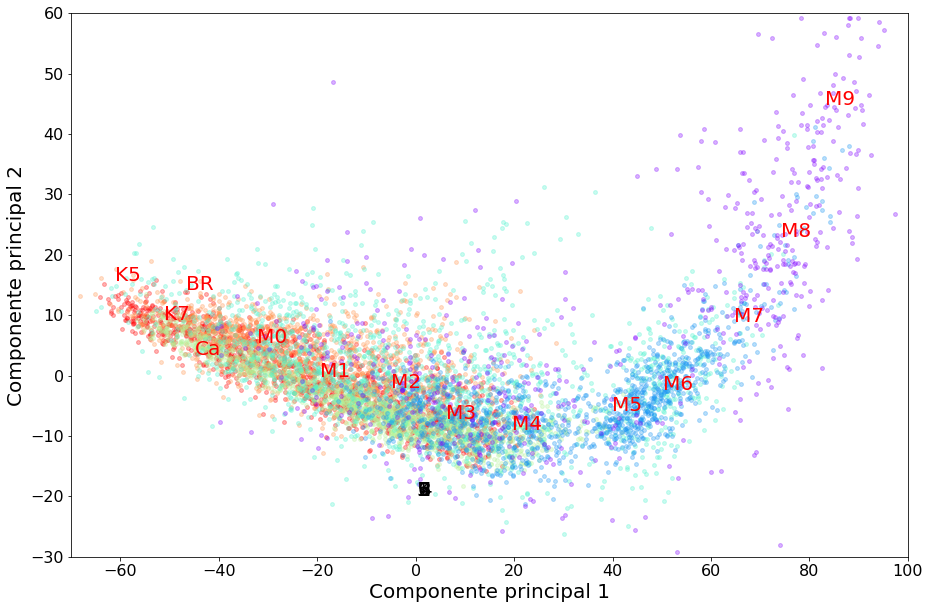

In [ ]:
comp = 0
comp_aux =1

colors = cm.rainbow(np.linspace(0, 1, len(unique)))[::-1]

fig, ax = plt.subplots(figsize=(15,10))

centroides = gmm.means_
#Si hemos escalado las características.
#centroides = sc_pca.inverse_transform(gmm.means_)

for color , cluster in zip(colors,unique):
 
  indices = df_enanas_pca_sin_out.gmm_grupos==cluster
  ax.scatter(datos_pca[indices,comp], datos_pca[indices,comp_aux] , s=15,color=color, alpha=0.3)
  #ax.text(centroides[cluster-1,comp]+2, centroides[cluster-1,comp_aux], cluster,size=20,c='black')
  ax.text(centroides[cluster-1,comp], -20, cluster,size=20,c='black') #cuando se usa solo 1 CP
#centroides

#ax.scatter(centroides[:,comp], centroides[:,comp_aux], c='blue',s=80,alpha=0.5)



#posición centro gravedad clases de metalicidad
for clase in df_clases_enanas.index:
  if clase not in ['T2','L9']:
    ax.text(df_clases_enanas.loc[clase][comp], df_clases_enanas.loc[clase][comp_aux], clase,size=20,c='red') 


ax.set_ylim(-30,60)
ax.set_xlim(-70,100)
#ax.set_ylim(-15,10)


#plt.title('Clusters y centroides')

ax.set_xlabel('Componente principal 1',size=20)
ax.set_ylabel('Componente principal '+str(comp_aux+1),size = 20)
ax.tick_params(labelsize=16)


In [ ]:
orden

array([-1,  3,  0,  4,  1,  2])

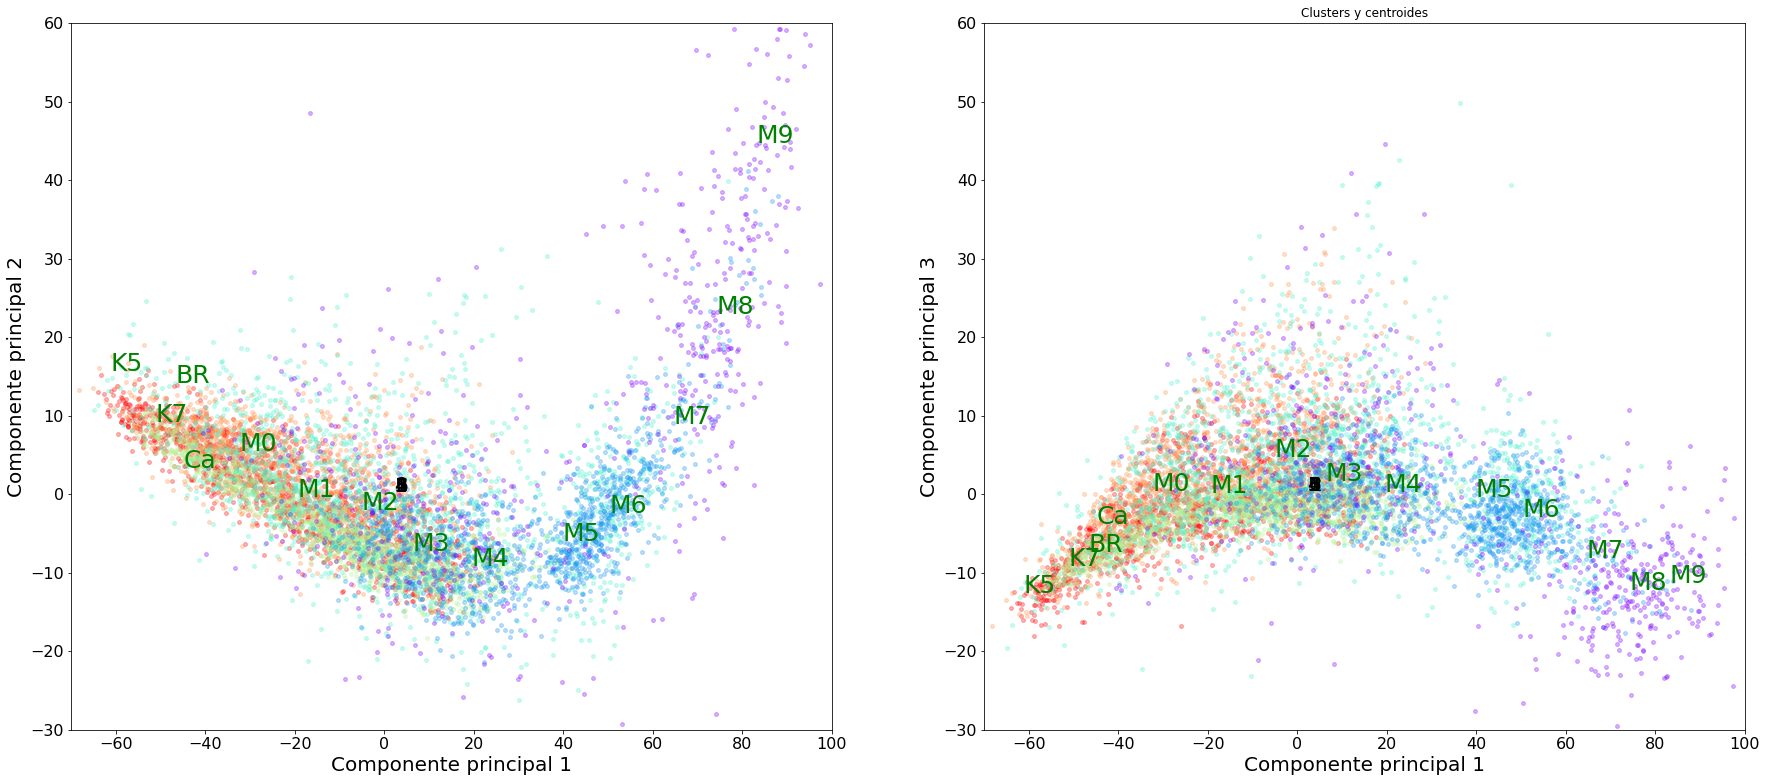

In [ ]:
comp = 0
comp2 = [1,2]

colors = cm.rainbow(np.linspace(0, 1, len(unique)))[::-1]

centroides = gmm.means_[orden]
#Si hemos escalado las características.
#centroides = sc_pca.inverse_transform(gmm.means__[orden])

fig, ax_ = plt.subplots(1,2,figsize=(30,13))

for i, comp_aux in enumerate(comp2):
  ax=ax_[i]

  for color , cluster in zip(colors,unique):
    indices = df_enanas_pca_sin_out.gmm_grupos==cluster
    ax.scatter(datos_pca[indices,comp], datos_pca[indices,comp_aux] , s=15,color=color, alpha=0.3)
    ax.text(centroides[cluster-1,comp]+2, centroides[cluster-1,comp_aux], cluster,size=20,c='black')
    #ax.text(centroides[cluster-1,comp], -20, cluster,size=20,c='black')

  #posición centro gravedad clases de metalicidad
  for clase in df_clases_enanas.index:
    if clase not in ['T2','L9']:
      ax.text(df_clases_enanas.loc[clase][comp], df_clases_enanas.loc[clase][comp_aux], clase,size=25,c='green') 


  ax.set_ylim(-30,60)
  ax.set_xlim(-70,100)
  #ax.set_ylim(-15,10)


  plt.title('Clusters y centroides')

  ax.set_xlabel('Componente principal 1',size=20)
  ax.set_ylabel('Componente principal '+str(comp_aux+1),size = 20)
  ax.tick_params(labelsize=16)





### Análisis resultado agrupamiento suave

Vemos que las clases se reparten bastante.

Podemos ver la matriz de frecuencia. 

In [ ]:
frecuencias = pd.crosstab(df_enanas_sin_out['gmm_grupos_suave'], df_enanas_sin_out['subclass']) 
frecuencias_subclase=frecuencias.copy()
frecuencias

**Analizamos el resultado para la clase de metalicidad.**

En frecuencias_metal tenemos las metalicidades por subclase observadas

In [ ]:
frecuencias_metal = pd.crosstab(df_enanas_sin_out['clase_metalicidad'],df_enanas_sin_out['subclass']) 
#frecuencias_metal.drop(columns=['L0','BR','Ca'],inplace=True)
#frecuencias_metal.reset_index(inplace=True)
frecuencias_metal

Calculamos para cada metalicidad la fracción por subclase

In [ ]:
frac_metal=frecuencias_metal.T.apply(lambda x: x/x.sum(),axis=1)
frac_metal.T

Calculamos por cada grupo el número de objetos por subclase esperado si la distribución fuera aleatoria. Para ello multiplicamos para cada cluster el número de enanas de cada subclase por  la fracción de cada metalicidad en la subclase y sumamos para cada metalicidad

In [ ]:
frecuencias_subclase.T

Calculamos la frecuencia esperada de cada metalicidad por grupo

In [ ]:
frec_cluster_metal = pd.DataFrame(data=np.dot(frac_metal.T.values,frecuencias_subclase.T.values),
                                  columns=frecuencias_subclase.index,
                                  index=frecuencias_metal.index)
frec_cluster_metal

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs = pd.crosstab(df_enanas_sin_out['clase_metalicidad'],df_enanas_sin_out['gmm_grupos_suave']) 
frec_cluster_metal_obs

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs = pd.crosstab(df_enanas_sin_out['clase_metalicidad'],df_enanas_sin_out['gmm_grupos']) 
frec_cluster_metal_obs

### Resultados

In [ ]:
#https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

MinMax scaler con 16 no ha funcionado mal del todo. Separa de manera gradual por clases.

StandarScaler 14 clases Separa peor, peor coeficiente silhouette. Pesado tampoco mejora mucho.
Pesado no funciona mejor

In [ ]:
pd.options.display.max_rows = 999

In [ ]:
df_pca_sin_out.groupby(by=['gmm_grupos','subclase']).size()

In [ ]:
df_pca_sin_out.groupby(by=['gmm_grupos','clase_metalicidad']).size()

## Mapas Cohonen

In [ ]:
!pip install MiniSom

In [ ]:
X=

In [ ]:
from minisom import MiniSom  
dim_red = [6,6]
som = MiniSom(x = dim_red[0], y = dim_red[1], input_len = datos.shape[1], sigma = 10.0, learning_rate = 0.5,neighborhood_function='gaussian')  
som.random_weights_init(datos)  
som.train_random(data = datos, num_iteration = 1000,verbose=True)  

In [ ]:
som.quantization_error(datos)

In [ ]:
cuantizacion=[]
rango = np.arange(3,15)
for i in rango:
  dim_red = [i,i]
  som = MiniSom(x = i, y = i, input_len = datos.shape[1], sigma = 10.0, learning_rate = 0.5,neighborhood_function='gaussian')  
  som.random_weights_init(datos)  
  som.train_random(data = datos, num_iteration = 1000)  
  cuantizacion.append(som.quantization_error(datos))
  #print(som.quantization_error(datos))

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,8))

ax2 = ax1.twinx()
ax1.plot(rango, cuantizacion, marker='o', label = 'distorsión')
#ax2.plot(rango, silhouettes, c='r',marker='o', label = 'coef. silueta')


ax1.set_xlabel('neuronas red',size=15)
ax1.set_ylabel('cuantización',size=15)
#ax2.set_ylabel('Coeficiente silueta',size=15)
#ax2.set_title('Silhouette y distorsion vs clusters K-means')


ax1.legend(loc='best',fontsize=12)
ax2.legend(loc='upper center',fontsize=12)

ax1.set_xticks(rango)
ax1.set_xticklabels(rango*rango, size=15)
ax1.tick_params(labelsize=15,labelrotation=90)
plt.xticks(np.arange(rango.min(), rango.max()+2))
plt.show()

In [ ]:
from pylab import bone, pcolor, colorbar, plot, show  
bone()  
pcolor(som.distance_map().T)  
colorbar()  

In [ ]:
som.distance_map() #distancia de cada neurona a las adjacentes a un distancia sigma

In [ ]:
som.get_weights().shape


In [ ]:
som.win_map(datos).keys()

In [ ]:
mappings = som.win_map(datos)  

In [ ]:
len(mappings)

In [ ]:
neuronas_gan =som.win_map(datos).keys()

In [ ]:
l = list(neuronas_gan)
l

In [ ]:
n_ganadores[l[0]]

In [ ]:
n_ganadores[(0, 0)]

In [ ]:
n_ganadores = np.empty((6, 6))
for i in coor_x:
  for j in coor_y:
    n_ganadores[i,j] = len(mappings[(i,j)])

In [ ]:
from pylab import text

coor_x = np.arange(0,10)
coor_y = np.arange(0,10)
plt.figure(figsize=(10,8))
bone()  
pcolor(som.distance_map().T)  
for i in coor_x:
    for j in coor_y:
        text(i+0.5, j+0.5, int(n_ganadores[i,j]),color='red')

colorbar()  

In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in datos]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates,dim_red) #Con esto obtenemos las clases

In [ ]:
cluster_index.shape

In [ ]:
cluster_index.max()

In [ ]:
winner_coordinates.shape

In [ ]:
som.winner(x)

 # Verificación resultados temperatura usando conjunto de prueba

## Carga segundo conjunto de enanas

In [ ]:
directorio = '../Espectros/datos_json/'
muestra_BD_2 = np.load(directorio+'muestra_EM_cat_West_5000_tratada_2.npz',allow_pickle=True)
muestra_BD_2.files


['flujos', 'long_onda', 'subclases', 'datos', 'columnas']

In [ ]:
flujos_BD_EM_2, long_onda_EM_2, subclases_EM_2, datos_EM_2, columnas_EM_2 = [muestra_BD_2[f] for f in muestra_BD_2.files]

In [ ]:
df_enanas_marrones_test = pd.DataFrame(data = datos_EM_2, columns = columnas_EM_2)
df_enanas_marrones_test.head(2)

PLATE-MJD-FIBER    SPECOBJID PLATEQUALITY extrapolado max_long_A  \
0   299-51671-244  -2030016512         good       False     9185.4   
1   300-51666-210  -2113902592         good       False     9185.4   

             Z        Z_ERR CLASS SUBCLASS outlier_info outrango_info SpT  \
0  0.000404729  5.73353e-05  STAR      M0V        False         False   0   
1 -0.000200711  9.64381e-05  STAR       M7         True         False   7   

  clase_metalicidad subclass subclass_c  
0                dM       M0         M0  
1                dM       M7         M7

In [ ]:
flujos_BD_EM_2.shape

(4822, 1600)

In [ ]:
long_onda_EM_2.shape

(1600,)

In [ ]:
del muestra_BD_2

## Creación de los datasets

### Dataframe con los datos.

Concanaremos los dos datasets. Habrá que revisar los atributos

In [ ]:
df_enanas_marrones_test.columns

Index(['PLATE-MJD-FIBER', 'SPECOBJID', 'PLATEQUALITY', 'extrapolado',
       'max_long_A', 'Z', 'Z_ERR', 'CLASS', 'SUBCLASS', 'outlier_info',
       'outrango_info', 'SpT', 'clase_metalicidad', 'subclass', 'subclass_c'],
      dtype='object')

Eliminamos los atributos que no interesan

In [ ]:
df_enanas_marrones_test

PLATE-MJD-FIBER    SPECOBJID PLATEQUALITY extrapolado max_long_A  \
0      299-51671-244  -2030016512         good       False     9185.4   
1      300-51666-210  -2113902592         good       False     9185.4   
2       303-51615-48   1325426688     marginal       False     9164.3   
3      305-51613-274   1291872256         good       False     9181.2   
4      305-51613-303   1291872256         good       False     9179.1   
...              ...          ...          ...         ...        ...   
4817  2955-54562-382   -771725312         good       False     9215.1   
4818  2955-54562-388   -771725312         good       False     9215.1   
4819  2955-54562-449   -771725312         good       False       9213   
4820  2955-54562-542   -771725312         good       False     9206.6   
4821  2955-54562-545   -771725312         good       False     9206.6   

                Z        Z_ERR CLASS SUBCLASS outlier_info outrango_info SpT  \
0     0.000404729  5.73353e-05  STAR      M0V        False         False   0   
1    -0.000200711  9.64381e-05  STAR       M7         True         False   7   
2    -4.78168e-05   1.0843e-05  STAR       M0        False         False   0   
3     9.92452e-05   9.5193e-06  STAR       M1        False         False   1   
4    -0.000148868  2.11082e-05  STAR       M3        False         False   3   
...           ...          ...   ...      ...          ...           ...  ..   
4817  -1.9118e-06  1.15972e-05  STAR       M2        False         False   2   
4818  8.52796e-05   6.2583e-05  STAR       M8        False         False   8   
4819 -4.35768e-05  1.94062e-05  STAR       M3        False         False   3   
4820 -7.05873e-05  3.31774e-05  STAR       M4        False         False   4   
4821 -0.000143151  2.85251e-05  STAR       M7        False         False   7   

     clase_metalicidad subclass subclass_c  
0                   dM       M0         M0  
1                   dM       M7         M7  
2                   dM       M0         M0  
3                   dM       M1         M1  
4                   dM       M3         M3  
...                ...      ...        ...  
4817                dM       M2         M2  
4818                dM       M8         M8  
4819                dM       M3         M3  
4820                dM       M4         M4  
4821                dM       M7         M7  

[4822 rows x 15 columns]

In [ ]:
eliminar = ['SpT']
df_dm_test = df_enanas_marrones_test.drop(columns=eliminar)
df_dm_test.columns

Index(['PLATE-MJD-FIBER', 'SPECOBJID', 'PLATEQUALITY', 'extrapolado',
       'max_long_A', 'Z', 'Z_ERR', 'CLASS', 'SUBCLASS', 'outlier_info',
       'outrango_info', 'clase_metalicidad', 'subclass', 'subclass_c'],
      dtype='object')

Concatenamos los datasets empezando por el de las subenanas.

In [ ]:
df_sdm.shape

(3003, 17)

In [ ]:
#df_enanas_test = df_dm_test.copy() #si no concatenamos y no usamos subenanas

In [ ]:
df_enanas_test = pd.concat([df_sdm.iloc[corte_sem_test:],df_dm_test],axis=0, ignore_index=True)
df_enanas_test
df_enanas_test.shape

(6323, 21)

In [ ]:
df_enanas_test.head(3)
#df_enanas_test.tail(3)

SPECOBJID             ra             dec sn_median_r         z  \
0  523704842057705472  '04:10:07.30'  '-04:12:42.56'        9.83  0.000481   
1  525802160336693248  '08:50:42.85'  '+00:09:16.35'        5.88   5.7e-05   
2  527023168183887872  '08:50:50.13'  '+01:56:17.78'       19.19  0.000193   

      zerr zwarning   class subclass PLATE-MJD-FIBER outlier_info  \
0  1.8e-05        0  'STAR'       M0   465-51910-587        False   
1  3.7e-05        0  'STAR'       M1    467-51901-25        False   
2  1.2e-05        0  'STAR'       K7   468-51912-371        False   

  outrango_info PLATEQUALITY extrapolado max_long_A clase_metalicidad  \
0         False     marginal       False     9210.9              esdM   
1         False         good       False     9204.5               sdM   
2         False     marginal       False     9208.7               sdM   

  subclass_c    Z Z_ERR CLASS SUBCLASS  
0         M4  NaN   NaN   NaN      NaN  
1         M1  NaN   NaN   NaN      NaN  
2         M0  NaN   NaN   NaN      NaN

### Espectros

Concatemos los flujos igualmente empezando por las subenanas.

In [ ]:
#flujos_BD_test = flujos_BD_EM_2.copy() #si no concatenamos de manera que no se usen subenanas

In [ ]:
flujos_BD_test =np.concatenate([flujos_BD_SE[corte_sem:],flujos_BD_EM_2],axis=0)


In [ ]:
flujos_BD_test.shape

(6323, 1600)

### Revisión valores duplicados

Podría darse el caso de que tuviéramos espectros en el catálogo de West que estén en el catálogo de Savche...
En ese caso tendríamos objetos duplicados en el catálogo West que habrá que eliminar

In [ ]:
print(f"valores duplicados {df_enanas_test.shape[0]-(df_enanas_test.drop_duplicates(subset=['PLATE-MJD-FIBER'])).shape[0]}")

valores duplicados 140


Vemos que hay 316 repetidos. 

Eliminamos los del catálogo West. Como las subenanas están primero eliminamos duplicados quedándonos con la primera ocurrencia. 

In [ ]:
print(f'número de objetos antes de eliminar {df_enanas_test.shape[0]}')
df_enanas_test.drop_duplicates(subset=['PLATE-MJD-FIBER'], keep = 'first', inplace=True)
print(f'número de objetos después de eliminar {df_enanas_test.shape[0]}')

número de objetos antes de eliminar 6323
número de objetos después de eliminar 6183


Eliminamos también los espectros correspondientes

In [ ]:
flujos_BD_test= flujos_BD_test[df_enanas_test.index]

In [ ]:
flujos_BD_test.shape[0]

6183

Reseteamos los índices de df_enanas_test para que coincidan con los de flujos_DB_test.

**Esto es IMPORTANTE**

In [ ]:
df_enanas_test.reset_index(drop=True, inplace=True)
df_enanas_test.tail(2)

SPECOBJID   ra  dec sn_median_r    z zerr zwarning class subclass  \
6181  -771725312  NaN  NaN         NaN  NaN  NaN      NaN   NaN       M4   
6182  -771725312  NaN  NaN         NaN  NaN  NaN      NaN   NaN       M7   

     PLATE-MJD-FIBER outlier_info outrango_info PLATEQUALITY extrapolado  \
6181  2955-54562-542        False         False         good       False   
6182  2955-54562-545        False         False         good       False   

     max_long_A clase_metalicidad subclass_c            Z        Z_ERR CLASS  \
6181     9206.6                dM         M4 -7.05873e-05  3.31774e-05  STAR   
6182     9206.6                dM         M7 -0.000143151  2.85251e-05  STAR   

     SUBCLASS  
6181       M4  
6182       M7

### Revisión valores para las subclases y clases de metalicidad

In [ ]:
df_enanas_test.subclass.value_counts()

M0    1199
M2     941
M3     850
K7     689
M1     629
M4     556
M6     506
M5     355
M7     202
M8     108
M9      77
K5      55
Ca       5
K3       4
ST       2
T2       1
L0       1
L9       1
BR       1
G5       1
Name: subclass, dtype: int64


Hacemos los mismo para metalicidad

In [ ]:
df_enanas_test.clase_metalicidad.value_counts()

dM      4693
sdM     1027
esdM     332
usdM     131
Name: clase_metalicidad, dtype: int64

En el caso de la clase de metalicidad no hay problema. 

Veamos la tabla cruzada.

In [ ]:
pd.crosstab(df_enanas_test.clase_metalicidad,df_enanas_test.subclass)

subclass           BR  Ca  G5  K3  K5   K7  L0  L9   M0   M1   M2   M3   M4  \
clase_metalicidad                                                             
dM                  0   3   1   4  54  658   0   1  631  479  593  713  490   
esdM                0   0   0   0   0    9   0   0  203   20   63   15   11   
sdM                 1   2   0   0   1   20   1   0  261  128  275  115   52   
usdM                0   0   0   0   0    2   0   0  104    2   10    7    3   

subclass            M5   M6   M7  M8  M9  ST  T2  
clase_metalicidad                                 
dM                 326  463  171  65  38   2   1  
esdM                 2    1    3   2   3   0   0  
sdM                 26   42   28  40  35   0   0  
usdM                 1    0    0   1   1   0   0

## Analisis PCA conjunto de test

Para aplicar PCA es necesario estandarizar los flujos para cada longitud de onda. 

In [ ]:
sc_em_test = StandardScaler()
e_flujos_em_test = sc_em_test.fit_transform(flujos_BD_test)
e_flujos_em_test.shape

(6183, 1600)

In [ ]:
estimator_em_test = PCA(n_components = 0.95)
X_pca_em_test = estimator_em_test.fit_transform(e_flujos_em_test)
varianza_explicada_em_test = estimator_em_test.explained_variance_ratio_

In [ ]:
datos_test_con_outliers = X_pca_em_test[:,:45]
datos_test_con_outliers.shape

(6183, 45)

In [ ]:
varianza_explicada_em_test.shape

(184,)

In [ ]:
varianza_explicada_em_test[:50]

array([0.69988797, 0.06652772, 0.03507134, 0.00676188, 0.00563345,
       0.00466971, 0.00399794, 0.00330877, 0.00289408, 0.00260064,
       0.00235925, 0.00199668, 0.00197612, 0.00188107, 0.00178588,
       0.00174274, 0.00164337, 0.00159482, 0.00156329, 0.00152171,
       0.00150621, 0.00143343, 0.00140795, 0.0013857 , 0.00137546,
       0.00134845, 0.00131868, 0.00129365, 0.00126991, 0.00125491,
       0.00120033, 0.0011805 , 0.00116022, 0.00113559, 0.00112294,
       0.00110104, 0.00109222, 0.00107008, 0.00106346, 0.00105396,
       0.00103293, 0.00101684, 0.0010137 , 0.00100159, 0.00097373,
       0.0009618 , 0.0009591 , 0.00093545, 0.00092392, 0.00092097])

In [ ]:
varianza_acumulada_em_test = np.cumsum(varianza_explicada_em)
varianza_acumulada_em_test[:50]

array([0.69598874, 0.76053697, 0.79358397, 0.80007433, 0.80641543,
       0.81094804, 0.81426626, 0.81752467, 0.82053709, 0.823435  ,
       0.82584967, 0.82797555, 0.82995832, 0.83189265, 0.83371993,
       0.83545428, 0.837176  , 0.83884319, 0.84045516, 0.84199359,
       0.84346641, 0.84490765, 0.84628223, 0.84764818, 0.84899444,
       0.85032379, 0.8516442 , 0.85292725, 0.85418534, 0.85541774,
       0.85662705, 0.85781271, 0.8589924 , 0.86015021, 0.86128623,
       0.86240163, 0.86350478, 0.86458593, 0.86565697, 0.86671357,
       0.8677447 , 0.86876891, 0.86977397, 0.87076369, 0.87174126,
       0.87271647, 0.87368269, 0.87463383, 0.87557423, 0.87649845])

In [ ]:
np.where(varianza_acumulada_em_test<0.85)[0].shape


(25,)

### Eliminación valores atípicos usando agregación jerárquica con enlace 'single'

#### Cálculo de la matriz de distancia

Calculamos la matriz de distancia con métrica euclídea. Lo haremos sobre las características seleccionadas.
 

El método anterior tiene algunos problemas. Es mejor usar los siguiente

In [ ]:
distancia = pdist(datos_test_con_outliers,metric ='euclidean') # genera una matriz plana con la parte superior triangular de la matriz de distancia. 
#Esta matriz plana es la entrada óptima para el algoritmo
matrizdistancia = squareform(distancia)

In [ ]:
distancia.shape

(19111653,)

#### Enlace "single"

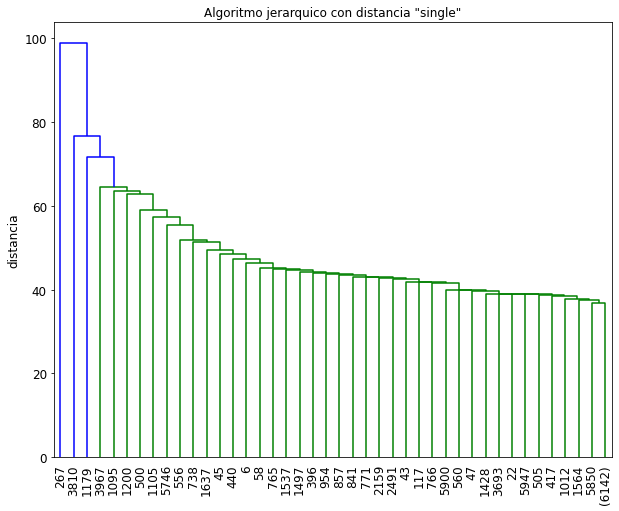

In [ ]:
clusters_s = cluster.hierarchy.linkage(distancia, method = 'single')
f, ax = plt.subplots(figsize=(10, 8))
cluster.hierarchy.dendrogram(clusters_s, p=40, truncate_mode='level' ,ax=ax)
ax.set_title('Algoritmo jerarquico con distancia "single"')
ax.set_ylabel('distancia',size=12)
ax.tick_params(labelsize=12)
plt.show()

#### Valores atípicos.

El enlace simple es util para detectar outliers. 

In [ ]:
n_cluster = []
#dist = np.arange(20,40,1) #PCA 10
dist = np.arange(40,90,1) #PCA 45
#dist = np.arange(55,100,1) #PCA 45 50% de enanas marrones
#dist = np.arange(0.5,2,0.1) #norm
for i in dist: 

  dic_cluster = collections.Counter(cluster.hierarchy.fcluster(clusters_s, i , criterion = 'distance'))
  n_cluster=n_cluster+[len(dic_cluster)]

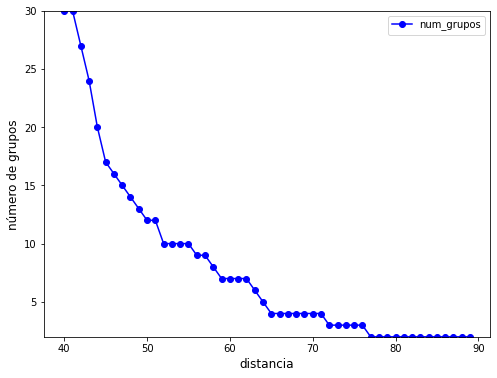

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(dist, n_cluster , marker='o',c='b', label='num_grupos')

ax.set_ylabel('número de grupos',size = 12)
ax.set_xlabel('distancia',size = 12)

ax.set_ylim(min(n_cluster),max(n_cluster))
ax.legend(loc='best')

#ax.set_title('Silhouette vs clusters para enlace "ward"')
plt.show()


Recuperamos las etiquetas.

In [ ]:
#dist = 1.1 #norm
#dist = 53 #PCA 45
#dist = 34 # std
dist = 52 # #PCA 45 50% de enanas marrones
etiquetas = cluster.hierarchy.fcluster(clusters_s, dist , criterion = 'distance')
etiquetas

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
collections.Counter(etiquetas)

Counter({1: 6174, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1})

Añadimos una columna al dataset. Serán outliers aquellos elementos que no pertenezcan a la clase 1. 

In [ ]:
df_enanas_test['hierarchy_outlier'] = etiquetas


Guardamos los índices de los valores atípicos

In [ ]:
indices_out_single_test = df_enanas_test['hierarchy_outlier']!=1
indices_out_single_test = df_enanas_test.index[indices_out_single_test]
indices_out_single_test

Int64Index([267, 500, 1095, 1105, 1179, 1200, 3810, 3967, 5746], dtype='int64')

In [ ]:
df_enanas_test.loc[indices_out_single_test]

SPECOBJID             ra             dec sn_median_r  \
267   1674266812394530816  '23:40:34.42'  '-00:13:51.68'        0.38   
500   2249628335816599552  '10:37:54.07'  '+36:53:32.86'        0.08   
1095  2246228645561526272  '12:10:16.43'  '+39:17:16.56'        0.21   
1105  2259709208863729664  '10:54:50.70'  '+37:14:34.06'        0.52   
1179  2553716422597437440  '08:13:28.16'  '+13:57:55.16'        0.32   
1200  2571591183566399488  '09:04:17.98'  '+21:05:24.46'         0.1   
3810           -318740480            NaN             NaN         NaN   
3967            285239296            NaN             NaN         NaN   
5746            889219072            NaN             NaN         NaN   

             z     zerr zwarning   class subclass PLATE-MJD-FIBER  \
267  -0.000124  4.8e-05        0  'STAR'       L0  1487-52964-195   
500    1.7e-05  6.8e-05        0  'STAR'       M9  1998-53433-292   
1095    -3e-06    6e-05        0  'STAR'       M8  1995-53415-212   
1105  -4.9e-05  5.7e-05        0  'STAR'       M8  2007-53474-102   
1179  -1.9e-05  3.7e-05        0  'STAR'       M9  2268-53682-638   
1200   3.2e-05  4.6e-05        0  'STAR'       M9  2284-53708-130   
3810       NaN      NaN      NaN     NaN       M9  1349-52797-523   
3967       NaN      NaN      NaN     NaN       M9  1369-53089-525   
5746       NaN      NaN      NaN     NaN       M9  1933-53381-490   

     outlier_info outrango_info PLATEQUALITY extrapolado max_long_A  \
267         False         False         good       False       9196   
500         False         False         good       False     9179.1   
1095        False         False         good       False     9183.3   
1105        False         False         good       False     9193.9   
1179        False         False         good       False       9213   
1200        False         False         good       False     9202.4   
3810         True         False     marginal       False     9206.6   
3967        False         False         good       False     9198.1   
5746        False         False         good       False     9210.9   

     clase_metalicidad subclass_c            Z        Z_ERR CLASS SUBCLASS  \
267                sdM         M6          NaN          NaN   NaN      NaN   
500               usdM         M8          NaN          NaN   NaN      NaN   
1095               sdM         M7          NaN          NaN   NaN      NaN   
1105               sdM         M7          NaN          NaN   NaN      NaN   
1179               sdM         M6          NaN          NaN   NaN      NaN   
1200               sdM         M7          NaN          NaN   NaN      NaN   
3810                dM         M9  0.000221314  0.000101075  STAR       M9   
3967                dM         M9  5.08998e-05  7.08781e-05  STAR       M9   
5746                dM         M8  2.81406e-05  4.19804e-05  STAR       M9   

      hierarchy_outlier  
267                  10  
500                   4  
1095                  6  
1105                  3  
1179                  8  
1200                  5  
3810                  9  
3967                  7  
5746                  2

##  Eliminar valores atípicos. 

Tenemos los siguientes valores atípicos calculados

In [ ]:
indices_out_single_test =[] #para pruebas sin quitar atipicos

In [ ]:
# 50% de subenanas
indices_out_single_test = [267, 500, 1095, 1105, 1179, 1200, 3810, 3967, 5746]

In [ ]:
#esto es con todo el subconjunto de subenanas
#indices_out_single_test = 


Se recalculan las etiquetas que nos indicará si es outlier. 0 si outlier

In [ ]:
list_single_etiquetas = [0 if x in indices_out_single else 1 for x in df_enanas_test.index]
indices_tipicos_test = np.asarray(list_single_etiquetas) ==1

Eliminamos los espectros atípicos de los dataset.

In [ ]:
print(f"total espectros: {len(list_single_etiquetas)}")
print(f"Espectros no atípicos: {indices_tipicos_test.sum()}")
df_enanas_test_sin_out=df_enanas_test[indices_tipicos_test] #datos enanas
df_enanas_test_sin_out.reset_index(drop=True, inplace=True)
indices_out_single_test

total espectros: 6183
Espectros no atípicos: 6172


[267, 500, 1095, 1105, 1179, 1200, 3810, 3967, 5746]

Codificamos las subclases y las clases de metalicidad con **LabelEncoder**. Vamos a tratar por separado de momento la subclase espectral y la clase de metalicidad.

In [ ]:

# Label encoding with sklearn's LabelEncoder
cod_clase_metalicidad_em_t = LabelEncoder()
cod_subclases_em_t = LabelEncoder()
cod_subclases_test = cod_subclases_em_t.fit_transform(df_enanas_test_sin_out['subclass'])
cod_metalicidad_test = cod_clase_metalicidad_em_t.fit_transform(df_enanas_test_sin_out['clase_metalicidad'])

In [ ]:
# reverse mapping
cod_subclases_em_t.inverse_transform(cod_subclases_test)

array(['M0', 'M1', 'K7', ..., 'M3', 'M4', 'M7'], dtype=object)

In [ ]:
cod_clase_metalicidad_em_t.inverse_transform(cod_metalicidad_test)

array(['esdM', 'sdM', 'sdM', ..., 'dM', 'dM', 'dM'], dtype=object)

## Analisis PCA conjunto de test sin valores atípicos

In [ ]:
flujos_BD_test.shape


(6183, 1600)

In [ ]:
sc_em_test = StandardScaler()
e_flujos_em_test_sin_out = sc_em_test.fit_transform(flujos_BD_test[indices_tipicos_test])
e_flujos_em_test_sin_out.shape

(6172, 1600)

In [ ]:
estimator_em_test = PCA(n_components = 0.95)
X_pca_em_test = estimator_em_test.fit_transform(e_flujos_em_test_sin_out)
varianza_explicada_em_test = estimator_em_test.explained_variance_ratio_

In [ ]:
'''
datos_test_con_outliers = X_pca_em_test[:,:45]
datos_test_con_outliers.shape
'''

'\ndatos_test_con_outliers = X_pca_em_test[:,:45]\ndatos_test_con_outliers.shape\n'

<br>
<br>

### Creación dataset con componentes PCA

Creeamos un dataset con las primeras componentes pca y las subclases y metalicidad. 

In [ ]:

n_comp_pca_t = 120

df_enanas_pca_test_sin_out = pd.DataFrame(data=X_pca_em_test[:,:n_comp_pca_t])
df_enanas_pca_test_sin_out['subclase']=df_enanas_test_sin_out.subclass
df_enanas_pca_test_sin_out['clase_metalicidad']=df_enanas_test_sin_out.clase_metalicidad
print(df_enanas_test.shape)
df_enanas_pca_test_sin_out.head(3)


(6183, 21)


0         1          2         3         4         5         6  \
0 -19.253015  4.195978  12.225765  3.424477  3.021014 -6.161478  7.503374   
1 -19.955509 -4.353534   1.622344  3.814149  1.591031  0.800984  0.067511   
2 -40.182679  4.356482  -4.642350  0.888345  0.399462  0.288696 -0.080518   

          7         8         9        10        11        12        13  \
0  0.212786 -0.436094 -3.235049  0.766411  2.207068 -1.335645 -1.200479   
1  3.521477  0.843592  0.507862  0.520237 -0.763112 -2.112116 -1.706286   
2  1.309479 -0.389150  0.339301 -1.097344 -0.086606 -1.657911  0.827786   

         14  ...       107       108       109       110       111       112  \
0 -0.978200  ...  0.070885  0.169844  0.850378  0.260265  1.004553 -0.382959   
1  0.799101  ...  1.002967  1.326910 -0.249836 -0.195219  0.968643 -3.233897   
2 -0.026137  ...  0.378264  0.148261  0.173770  1.061374 -0.311198  0.584670   

        113       114       115       116       117       118       119  \
0 -0.432697 -0.405457  0.389036 -0.083258 -0.164286  0.854558  0.175968   
1  2.005312  0.118443 -0.482130 -0.037960 -1.378756  0.394307 -0.699039   
2 -0.335003  0.551621 -0.457051  0.766619 -1.386983 -0.606272 -0.956715   

   subclase  clase_metalicidad  
0        M0               esdM  
1        M1                sdM  
2        K7                sdM  

[3 rows x 122 columns]

### Centroides  subclases

In [ ]:
df_clases_enanas_test = df_enanas_pca_test_sin_out.groupby('subclase').mean()
df_clases_enanas_test

0           1          2          3         4         5    \
subclase                                                                    
BR       -41.360898   11.968847  -4.890825   3.897236 -4.540689  5.598840   
Ca       -38.402404    2.929958  -1.776206   6.647177 -1.941358  6.928694   
G5       -48.855165   16.146054  -8.005866  -4.392687 -0.380825  0.201106   
K3       -51.401807   13.887634  -9.312310  -4.675723 -2.450985 -1.782257   
K5       -50.522593   13.588874  -6.607279  -1.562761 -1.460597  1.023109   
K7       -43.728231    7.508064  -5.535907   0.807174 -0.326843  0.636570   
L0        81.108184  112.090573  45.718895 -14.636011 -9.021903  6.535347   
L9       -24.370826   18.583947  15.151540 -16.041332 -3.382598 -3.445936   
M0       -28.856930    3.625284   1.245499   1.580780 -0.142213 -0.677754   
M1       -16.928608   -1.540004   1.102507  -0.008559  0.131329  0.349510   
M2        -3.280211   -2.958927   5.443297  -0.804970  0.396497 -0.693481   
M3         7.144423   -7.835671   2.182511  -1.336285  0.444236  0.508904   
M4        19.279137   -8.927210   0.726330  -1.356557  0.010688  1.050805   
M5        37.983725   -5.583691  -0.191413  -1.065310 -0.339041 -0.115254   
M6        48.860088   -2.197650  -3.026644   0.176058 -0.496400  0.093740   
M7        62.461696    8.515625  -8.122676   0.840632 -0.397539 -1.254352   
M8        71.939035   23.666226 -12.309991   1.747904  0.356015 -1.281595   
M9        82.781894   47.240873  -9.896671   3.425106  1.085036  1.125679   
ST       -46.909114   10.609352 -14.480863 -15.037653  5.037323 -2.176267   
T2       -47.552491   11.427959  -3.926599  -1.853368 -4.718522 -2.140488   

               6          7          8          9          10        11   \
subclase                                                                   
BR       -6.479831  -2.338472  -1.166560   0.318753  -0.279370  0.436413   
Ca        4.328659  -0.042941  -1.093340  -2.713681   1.285022  0.692547   
G5       -8.369989   0.745657  -0.257091  -1.265073   0.353227 -0.385246   
K3       -7.057471  -1.690196  -1.299594   0.338243   0.232751 -0.638625   
K5       -3.036078  -0.074190  -1.945612  -0.085842   0.037388 -0.525838   
K7       -0.731942  -0.174100  -1.579541   0.176669   0.125697 -0.042885   
L0       -1.311462  30.721536  20.144476  25.916668  27.652006 -9.801548   
L9       -3.647094  -1.555242   6.654142   2.371197   0.943162  0.150457   
M0        1.033666  -0.073125  -0.203946  -0.356989   0.037171  0.234470   
M1        0.088184  -0.010617   0.945314   0.390065  -0.120325 -0.166644   
M2        0.171132   0.188268   1.153699   0.182589  -0.263757 -0.011731   
M3       -0.477961   0.191057   1.200676   0.298684   0.013415 -0.182605   
M4       -0.818007   0.321641   0.261953  -0.025801   0.181807 -0.159849   
M5       -0.706593  -0.506979  -1.724458  -0.286202   0.084604  0.042430   
M6       -0.377117  -0.385900  -2.234815  -0.831639   0.074875  0.296034   
M7        0.853371  -0.517328  -1.717217   0.497374  -0.146360  0.731592   
M8        3.231394   0.886702   1.249296   0.959888   0.691427 -0.928165   
M9        0.459972   0.775256   6.914978  -0.453989  -0.907965 -0.843672   
ST       -3.943322   1.680296   3.956181  -3.103416   0.009715 -0.559680   
T2       -2.781601   0.726624  -1.061204  -0.888212  -1.674659 -0.337650   

               12        13         14   ...       105       106       107  \
subclase                                 ...                                 
BR        0.122361 -0.501452   0.566837  ...  4.337586  0.282393  0.638966   
Ca        0.599028  1.023829  -0.165512  ...  1.089094 -0.658195 -0.575296   
G5        0.244118 -0.621181   0.539335  ... -0.041155  0.227154  0.036796   
K3       -0.476515 -1.831203  -0.289488  ... -0.460976  0.377090  0.014904   
K5       -0.347796 -0.174162   0.782370  ... -0.060828 -0.042969  0.053462   
K7       -0.029950 -0.019246   0.017790  ... -0.013730 -0.040274  0.023972   
L0       -6.221951  1.82

In [ ]:
color_g = cm.get_cmap('gnuplot2',len(df_clases_enanas)+1)

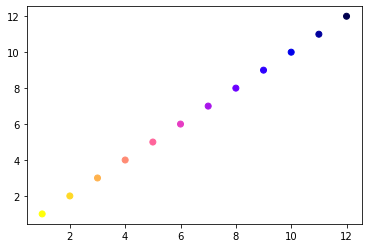

In [ ]:
x = np.arange(1,len(df_clases_enanas))
newcolors=color_g(x[::-1])
mapa_color=ListedColormap(newcolors)
plt.scatter(x,x,cmap= mapa_color, c=x)

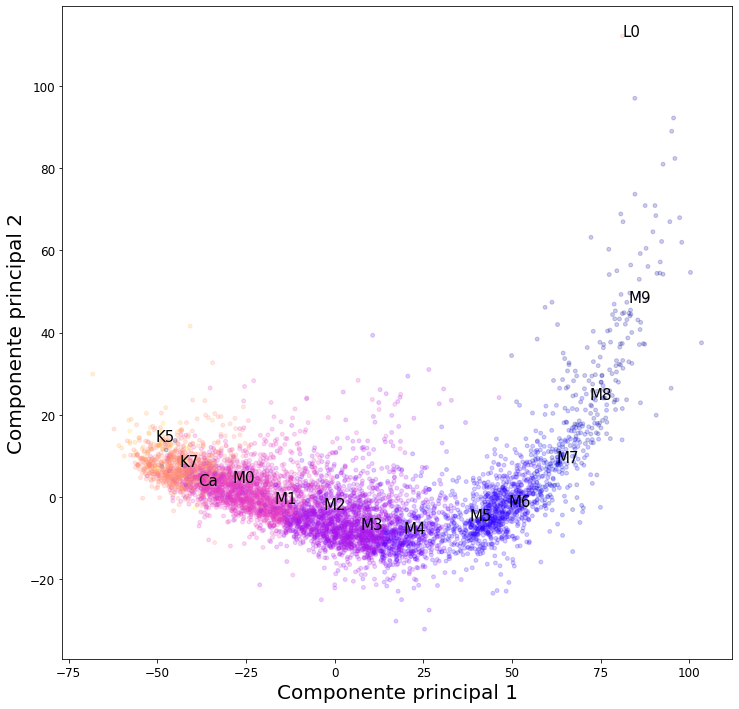

In [ ]:
comp =0
comp_aux =1
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(X_pca_em_test[:,comp], X_pca_em_test[:,comp_aux] , cmap=mapa_color,s=15,c=cod_subclases_test,alpha=0.2)

for clase in df_clases_enanas_test.index:
  if clase not in ['T2','L9','G5','BR','ST','K3']:
    ax.text(df_clases_enanas_test.loc[clase][comp], df_clases_enanas_test.loc[clase][comp_aux], clase,size=15,c='black') 

ax.set_xlabel('Componente principal '+str(comp+1),fontsize=20)
ax.set_ylabel('Componente principal '+str(comp_aux+1),fontsize=20)
#ax.set_xlim(-75,75)
#ax.set_ylim(-40,70)
#ax.set_ylim(-30,40)

ax.tick_params(labelsize=12)

plt.show()


### Centroides clases de metalicidad

In [ ]:
df_clase_m_enanas_test = df_enanas_pca_test_sin_out.groupby('clase_metalicidad').mean()
df_clase_m_enanas_test

0         1         2         3         4    \
clase_metalicidad                                                      
dM                  0.770943 -1.015343 -1.600695 -0.394855 -0.154732   
esdM              -13.956342  4.212711  7.994206  2.185044  0.357744   
sdM                 3.281684  2.635936  3.668257  0.599664  0.534197   
usdM              -18.094934  5.290115  8.732943  3.993253  0.489414   

                        5         6         7         8         9         10   \
clase_metalicidad                                                               
dM                 0.482473 -0.253389 -0.127381 -0.130485  0.046667 -0.173301   
esdM              -2.716764  1.812587  0.016990  0.301897 -1.014227  0.442413   
sdM               -0.949948  0.200504  0.523126  0.545134  0.277824  0.641941   
usdM              -3.072010  2.965636  0.451462 -0.324045 -1.285733  0.103875   

                        11        12        13        14   ...       105  \
clase_metalicidad                                          ...             
dM                 0.102754  0.123642 -0.100521 -0.073598  ... -0.025415   
esdM               0.024160 -0.420246  0.347097  0.043443  ... -0.200333   
sdM               -0.523973 -0.375942  0.270875  0.346407  ...  0.203395   
usdM               0.334013 -0.449678  0.622365 -0.167053  ... -0.168541   

                        106       107       108       109       110       111  \
clase_metalicidad                                                               
dM                 0.015808  0.037336 -0.009887 -0.005424  0.009260  0.002130   
esdM              -0.062758 -0.054397 -0.022039  0.139375 -0.018070  0.024327   
sdM               -0.057766 -0.166256  0.028773 -0.037180 -0.019024  0.009735   
usdM               0.040634  0.092333  0.185748  0.133498 -0.138378 -0.213125   

                        112       113       114       115       116       117  \
clase_metalicidad                                                               
dM                 0.014506 -0.011853  0.004100 -0.023755 -0.010933  0.010669   
esdM              -0.067073 -0.011976 -0.012947  0.108994  0.096292  0.025351   
sdM               -0.050237  0.048124 -0.013048  0.072825  0.029868 -0.078326   
usdM               0.039567  0.080380 -0.012872  0.010789 -0.082509  0.163401   

                        118       119  
clase_metalicidad                      
dM                -0.001963 -0.021405  
esdM               0.003395 -0.060232  
sdM                0.027630  0.144318  
usdM              -0.153119 -0.204507  

[4 rows x 120 columns]

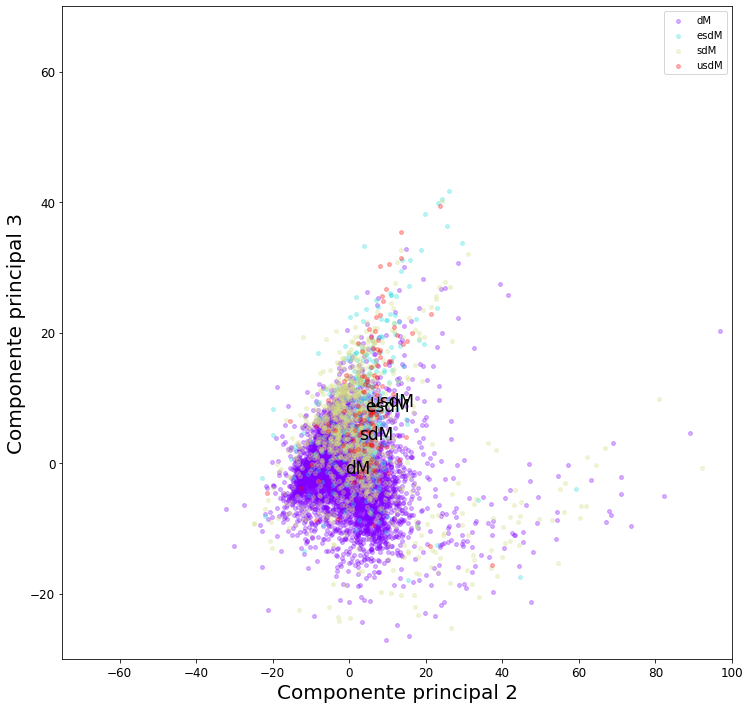

In [ ]:
comp =1
comp_aux =2
fig, ax = plt.subplots(figsize=(12,12))

colors = cm.rainbow(np.linspace(0, 1, len(df_clase_m_enanas.index)))

#['sdM', 'usdM', 'esdM', 'u', 'd']
lista_m = ['sdM', 'usdM', 'esdM', 'dM']
    
for color , clase in zip(colors,df_clase_m_enanas_test.index):
 
  indices = df_enanas_pca_test_sin_out.clase_metalicidad==clase
  #ax.scatter(X_pca_em_test[indices,comp], X_pca_em_test[indices,comp_aux] , label = clase, cmap='viridis',s=15,c= colores[indices]/5,alpha=0.4)
  if clase in lista_m:
    ax.text(df_clase_m_enanas_test.loc[clase][comp], df_clase_m_enanas_test.loc[clase][comp_aux], clase,size=17,c='black') 
    ax.scatter(X_pca_em_test[indices,comp], X_pca_em_test[indices,comp_aux] , label = clase, s=15,color=color, alpha=0.3)
ax.set_xlabel('Componente principal '+str(comp+1),fontsize=20)
ax.set_ylabel('Componente principal '+str(comp_aux+1),fontsize=20)
ax.set_xlim(-75,100)
ax.set_ylim(-30,70)
#ax.set_ylim(-30,40)

ax.tick_params(labelsize=12)
plt.legend()


Estas componentes no discriminan entre usdM, esdM y sdM ya que se superponen 

### Valores atípicos.

Analizamos si hay valores atípicos para cada componente principal de las seleccionadass.

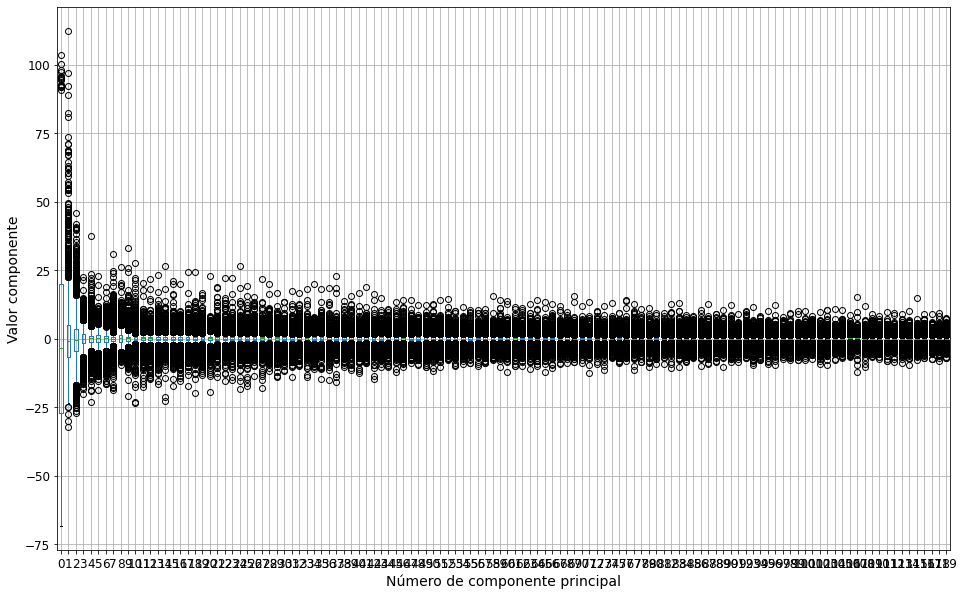

In [ ]:
ax = df_enanas_pca_test_sin_out.iloc[:,:n_comp_pca_t].boxplot(figsize=(16,10))
ax.set_xlabel('Número de componente principal',size=14)
ax.set_ylabel('Valor componente',size=14)
ax.tick_params(labelsize=12)

Si no eliminamos los valores atípicos tendremos problemas cuando normalicemos los parámetros. 

Creamos una función para identificar outliers.

In [ ]:
def obtener_outliers(dataframe, n = 3, verbose=True): # 
  '''
  : param: dataframe. El dataframe sobre cuyos valores se estimarán los outliers
  : param: n: margen para considerar un valor outlier
  : return: indices con valor true para las tuplas con outliers
  '''

  mediana = dataframe.median()
  cuartiles = dataframe.quantile([0.25 ,0.75])
  IQR = cuartiles.loc[0.75] - cuartiles.loc[0.25]
  inf = cuartiles.loc[0.25]-IQR*n
  sup = cuartiles.loc[0.25]+IQR*n

  if verbose:
    print('mediana: \n', mediana, '\n')
    print('cuartiles: \n',cuartiles)
    print('IRQ : \n', IQR)
    print('limite inferior para outlier: \n', inf)
    print('limite superior para outlier: \n', sup)
  #return dataframe[(dataframe > inf) & (dataframe < sup)], 
  return ((dataframe < inf) | (dataframe > sup)).any(axis=1)


Nos centramos en las componentes principales más relevantes. Esto se hace para no perder demasidos datos y para conservar información relevante en las componentes principales menos significativas ya que podrían tener información sobre la metalicidad.  

In [ ]:
indices_outliers_test = obtener_outliers(df_enanas_pca_test_sin_out.iloc[:,:n_comp_pca],3,verbose = False)
#indices_outliers

In [ ]:
print(f'número de tuplas con outliers {indices_outliers_test.sum()}')

número de tuplas con outliers 2722


#### Tratamiento valores atípicos

En vez de eliminar los datos añadiremos un atributo que nos indicará si es outlier o no.

In [ ]:
'''
No se usa porque no es util
df_enanas_test_sin_out.pca_outlier = indices_outliers
df_enanas_pca_test_sin_out.pca_outlier = indices_outliers
'''

'\nNo se usa porque no es util\ndf_enanas_test_sin_out.pca_outlier = indices_outliers\ndf_enanas_pca_test_sin_out.pca_outlier = indices_outliers\n'

## Preparación de las variables.

### Escalado de los datos.

In [ ]:
n_comp_pca_clustering_t = 50 #número de componentes que se usará para hacer clustering

data_test = df_enanas_pca_test_sin_out.drop(columns=['subclase','clase_metalicidad']).iloc[:,:n_comp_pca_clustering_t].values
datos_pca_test = df_enanas_pca_test_sin_out.drop(columns=['subclase','clase_metalicidad']).iloc[:,:n_comp_pca_t].values #guardamos las componentes PCA para representación. 
sc_pca_test = StandardScaler()
#sc_pca_test = MinMaxScaler()

sc_pca_test.fit(data_test)
#datos_test = sc_pca.transform(data_test) #aplicamos la transformación a todos los datos.
datos_test = data_test #probamos sin estandarizar



In [ ]:
datos_test.shape

(6172, 50)

In [ ]:
datos_test.max()

112.09057345577132

## K-MEANS

### Parametrization



En primer lugar vamos a establecer los parámetros que vamos a considerar por defecto

In [ ]:
# carga librerías

from sklearn.cluster import KMeans
from sklearn import metrics

# parameters
init = 'k-means++' # initialization method 

# to run 10 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 15

# maximum number of iterations for each single run
max_iter = 300 

# controls the tolerance with regard to the changes in the 
# within-cluster sum-squared-error to declare convergence

tol = 1e-04 

 # random seed. Fijamos la secuencia de números aleatorios.
random_state = 0

### Ejecución del Algoritmo

Utilizamos la primera componente componente principal sin escalar y k= 9 ya que es la paremetrización que se selección con el conjuntode origen.

In [ ]:
k = 9
km_EM_test = KMeans(k, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

y_km_EM_test = km_EM_test.fit_predict(datos_test[:,[0]]) #Usamos la primera componente PCA sin escalar.

In [ ]:
print(f"Coeficiente silueta {metrics.silhouette_score(datos_test[:,[0]], y_km_EM_test)}")

Coeficiente silueta 0.5320114002826793


In [ ]:
print(f"Coeficiente distorsion {km_EM_test.inertia_}")


Coeficiente distorsion 118483.06038717818


In [ ]:
etiquetas_clases = np.unique(y_km_EM_test)
etiquetas_clases

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [ ]:
unique, counts = np.unique(y_km_EM, return_counts=True)
dic_clases =dict(zip(unique, counts))
dic_clases

{0: 864, 1: 541, 2: 1146, 3: 405, 4: 733, 5: 1092, 6: 784, 7: 488, 8: 203}

Añadimos a los dataset las etiquetas. Sumamos uno para que el primer grupo sea el 1

In [ ]:

df_enanas_test_sin_out['clases_kmeans'] = y_km_EM_test+1
df_enanas_pca_test_sin_out['clases_kmeans'] = y_km_EM_test+1

### Análisis resultado

Distribución de subclases por grupos

In [ ]:
frecuencias = pd.crosstab(df_enanas_test_sin_out['clases_kmeans'], df_enanas_test_sin_out['subclass']) 
frecuencias_subclase = frecuencias.copy()
frecuencias.drop(columns=['G5','K3','L9','ST','T2','BR','Ca'],inplace=True)
#frecuencias.drop(columns=['G5','K3','L9','ST','T2','Ca'],inplace=True) #sin subenanas
frecuencias

subclass       K5   K7  L0   M0   M1   M2   M3   M4   M5   M6   M7  M8  M9
clases_kmeans                                                             
1               1  152   0  691   45   15    7    1    0    0    0   0   0
2               0    0   0    1    2   25  106  426   48    2    1   0   0
3               0    0   0    0    0    0    0    0    1  230  146  25   3
4               0    0   0   56  129  580  114   12    4    0    0   0   0
5               0    0   0    0    0    1    1   15  298  274    6   0   0
6               0    7   0  322  440   86   12    4    0    0    0   0   0
7              54  530   0  120    4    2    1    1    0    0    0   0   0
8               0    0   0    6    8  229  606   97    3    0    0   0   0
9               0    0   1    0    0    0    0    0    0    0   49  83  74

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs = pd.crosstab(df_enanas_test_sin_out['clases_kmeans'],df_enanas_test_sin_out['clase_metalicidad']) 
frec_cluster_metal_obs=frec_cluster_metal_obs[['dM','sdM','esdM','usdM']]
#frec_cluster_metal_obs=frec_cluster_metal_obs[['dM']]#sin subenanas
frec_cluster_metal_obs

clase_metalicidad   dM  sdM  esdM  usdM
clases_kmeans                          
1                  620  159    86    48
2                  486  106    15     4
3                  353   51     1     0
4                  615  197    65    18
5                  549   43     2     1
6                  567  161   105    40
7                  664   39    14     7
8                  716  188    34    11
9                  123   75     7     2

Ordenamos los índices -etiquetas grupo- por la posición de la subclase con mayor número de elementos para cada grupo y por la clase de metalicidad más numerosa en el cluster

In [ ]:
k=list(zip(frecuencias.index,np.argmax(frecuencias.values, axis=1),
           np.argmax(frec_cluster_metal_obs.values, axis=1)))
k.sort(key=lambda x: x[2])
k.sort(key=lambda x: x[1])
k

[(7, 1, 0),
 (1, 3, 0),
 (6, 4, 0),
 (4, 5, 0),
 (8, 6, 0),
 (2, 7, 0),
 (5, 8, 0),
 (3, 9, 0),
 (9, 11, 0)]

Extraemos los grupos ordenados según el criterio anterior

In [ ]:
grupos = [x[0] for x in k]
grupos

[7, 1, 6, 4, 8, 2, 5, 3, 9]

Se crea un diccionario para renombrar las clases

In [ ]:
new_grupos_test = dict(zip(grupos, np.arange(1,len(grupos)+1))) 
orden_test = np.asarray(list(new_grupos_test))-1
new_grupos_test
#orden

{1: 2, 2: 6, 3: 8, 4: 4, 5: 7, 6: 3, 7: 1, 8: 5, 9: 9}

In [ ]:
orden_test

array([6, 0, 5, 3, 7, 1, 4, 2, 8])

In [ ]:
df_enanas_test_sin_out['clases_kmeans'].replace(new_grupos_test,inplace=True)
df_enanas_pca_test_sin_out['clases_kmeans'].replace(new_grupos_test,inplace=True)

In [ ]:
pd.crosstab(df_enanas_test_sin_out['clases_kmeans'], df_enanas_test_sin_out['subclass']) 

subclass       BR  Ca  G5  K3  K5   K7  L0  L9   M0   M1   M2   M3   M4   M5  \
clases_kmeans                                                                  
1               1   3   1   4  54  530   0   0  120    4    2    1    1    0   
2               0   1   0   0   1  152   0   0  691   45   15    7    1    0   
3               0   1   0   0   0    7   0   1  322  440   86   12    4    0   
4               0   0   0   0   0    0   0   0   56  129  580  114   12    4   
5               0   0   0   0   0    0   0   0    6    8  229  606   97    3   
6               0   0   0   0   0    0   0   0    1    2   25  106  426   48   
7               0   0   0   0   0    0   0   0    0    0    1    1   15  298   
8               0   0   0   0   0    0   0   0    0    0    0    0    0    1   
9               0   0   0   0   0    0   1   0    0    0    0    0    0    0   

subclass        M6   M7  M8  M9  ST  T2  
clases_kmeans                            
1                0    0   0   0   2   1  
2                0    0   0   0   0   0  
3                0    0   0   0   0   0  
4                0    0   0   0   0   0  
5                0    0   0   0   0   0  
6                2    1   0   0   0   0  
7              274    6   0   0   0   0  
8              230  146  25   3   0   0  
9                0   49  83  74   0   0

#### Calculamos para cada grupo los espectro esperados por metalicidad.

En frecuencias_metal tenemos las metalicidades por subclase observadas

In [ ]:
frecuencias_metal = pd.crosstab(df_enanas_test_sin_out['clase_metalicidad'],df_enanas_test_sin_out['subclass']) 
#frecuencias_metal.drop(columns=['L0','BR','Ca'],inplace=True)
#frecuencias_metal.reset_index(inplace=True)
frecuencias_metal

subclass           BR  Ca  G5  K3  K5   K7  L0  L9   M0   M1   M2   M3   M4  \
clase_metalicidad                                                             
dM                  0   3   1   4  54  658   0   1  631  479  593  713  490   
esdM                0   0   0   0   0    9   0   0  201   20   62   15   11   
sdM                 1   2   0   0   1   20   1   0  260  127  273  112   52   
usdM                0   0   0   0   0    2   0   0  104    2   10    7    3   

subclass            M5   M6   M7  M8  M9  ST  T2  
clase_metalicidad                                 
dM                 326  463  171  65  38   2   1  
esdM                 2    1    3   2   3   0   0  
sdM                 25   42   28  40  35   0   0  
usdM                 1    0    0   1   1   0   0

Calculamos para cada metalicidad la fracción por subclase

In [ ]:
frac_metal=frecuencias_metal.T.apply(lambda x: x/x.sum(),axis=1)
frac_metal.T

subclass            BR   Ca   G5   K3        K5        K7   L0   L9        M0  \
clase_metalicidad                                                               
dM                 0.0  0.6  1.0  1.0  0.981818  0.955007  0.0  1.0  0.527592   
esdM               0.0  0.0  0.0  0.0  0.000000  0.013062  0.0  0.0  0.168060   
sdM                1.0  0.4  0.0  0.0  0.018182  0.029028  1.0  0.0  0.217391   
usdM               0.0  0.0  0.0  0.0  0.000000  0.002903  0.0  0.0  0.086957   

subclass                 M1        M2        M3        M4        M5        M6  \
clase_metalicidad                                                               
dM                 0.762739  0.632196  0.841795  0.881295  0.920904  0.915020   
esdM               0.031847  0.066098  0.017710  0.019784  0.005650  0.001976   
sdM                0.202229  0.291045  0.132231  0.093525  0.070621  0.083004   
usdM               0.003185  0.010661  0.008264  0.005396  0.002825  0.000000   

subclass                 M7        M8        M9   ST   T2  
clase_metalicidad                                          
dM                 0.846535  0.601852  0.493506  1.0  1.0  
esdM               0.014851  0.018519  0.038961  0.0  0.0  
sdM                0.138614  0.370370  0.454545  0.0  0.0  
usdM               0.000000  0.009259  0.012987  0.0  0.0

Calculamos por cada grupo el número de objetos por subclase esperado si la distribución fuera aleatoria. Para ello multiplicamos para cada cluster el número de enanas de cada subclase por  la fracción de cada metalicidad en la subclase y sumamos para cada metalicidad

#### Tabla ordenada de composición de cada clúster. Subclases y clase de metalicidad

In [ ]:
frecuencias = pd.crosstab(df_enanas_test_sin_out['clases_kmeans'], df_enanas_test_sin_out['subclass']) 
frecuencias_subclase = frecuencias.copy()
frecuencias.drop(columns=['G5','K3','L9','ST','T2','BR','Ca'],inplace=True)

frec_cluster_metal = pd.DataFrame(data=np.dot(frac_metal.T.values,frecuencias_subclase.T.values),
                                  columns=frecuencias_subclase.index,
                                  index=frecuencias_metal.index).astype(int).T
frec_cluster_metal = frec_cluster_metal[['dM','sdM','esdM','usdM']]
frec_cluster_metal.rename(columns= lambda x: 'f_'+x, inplace=True)

frec_cluster_metal_obs = pd.crosstab(df_enanas_test_sin_out['clases_kmeans'],df_enanas_test_sin_out['clase_metalicidad']) 
frec_cluster_metal_obs=frec_cluster_metal_obs[['dM','sdM','esdM','usdM']]
df_distribucion = pd.concat([frecuencias,frec_cluster_metal_obs,frec_cluster_metal],axis=1)
df_distribucion


K5   K7  L0   M0   M1   M2   M3   M4   M5   M6   M7  M8  M9  \
clases_kmeans                                                                
1              54  530   0  120    4    2    1    1    0    0    0   0   0   
2               1  152   0  691   45   15    7    1    0    0    0   0   0   
3               0    7   0  322  440   86   12    4    0    0    0   0   0   
4               0    0   0   56  129  580  114   12    4    0    0   0   0   
5               0    0   0    6    8  229  606   97    3    0    0   0   0   
6               0    0   0    1    2   25  106  426   48    2    1   0   0   
7               0    0   0    0    0    1    1   15  298  274    6   0   0   
8               0    0   0    0    0    0    0    0    1  230  146  25   3   
9               0    0   1    0    0    0    0    0    0    0   49  83  74   

                dM  sdM  esdM  usdM  f_dM  f_sdM  f_esdM  f_usdM  
clases_kmeans                                                     
1              664   39    14     7   638     46      27      12  
2              620  159    86    48   561    169     120      60  
3              567  161   105    40   581    186      74      30  
4              615  197    65    18   604    223      54      12  
5              716  188    34    11   752    158      29       8  
6              486  106    15     4   529     65      12       3  
7              549   43     2     1   544     46       2       0  
8              353   51     1     0   351     50       3       0  
9              123   75     7     2   127     72       5       1

###### Entropía

In [ ]:
from scipy.stats import entropy
columns = ['dM','sdM','esdM','usdM']
columns_f = ['f_'+x for x in columns]
n_subclases = len(set(df_distribucion.columns)-set(columns)-set(columns_f))
entropia_subclases = entropy(df_distribucion.drop(columns=columns+columns_f).values)#.sum()/n_subclases
entropia_grupos = entropy(df_distribucion.drop(columns=columns+columns_f).values.T)

In [ ]:
print(f"entropia grupos {entropia_grupos.sum()/len(df_distribucion.index)}")
print(f"entropia subclases {entropia_subclases.sum()/len(set(df_distribucion.columns)-set(columns+columns_f))}")


entropia grupos 0.9415134692904967
entropia subclases 0.6112164020603206


In [ ]:
entropy(df_distribucion[columns].values.T).sum()

5.990637035117831

In [ ]:
np.nan_to_num(entropy(df_distribucion[columns_f].values.T), nan=0).sum()

5.8844295739404

#### Representación gráfica

In [ ]:
unique, counts = np.unique(df_enanas_pca_test_sin_out['clases_kmeans'], return_counts=True)
unique

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

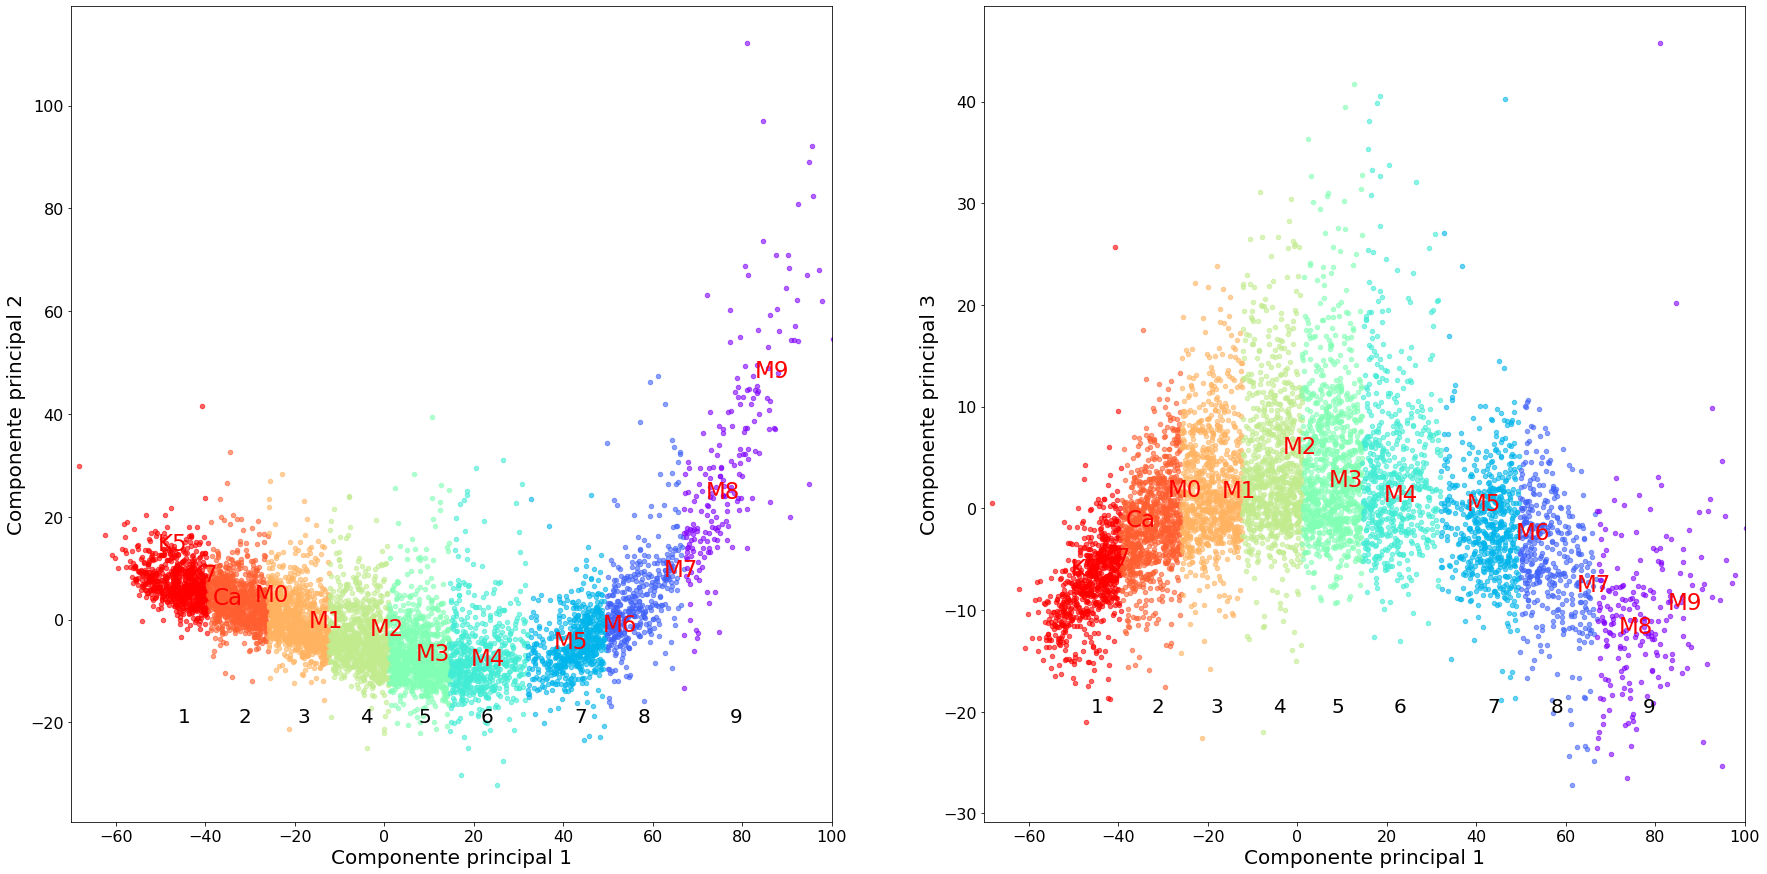

In [ ]:
comp = 0
comp2 = [1,2]

colors = cm.rainbow(np.linspace(0, 1, len(unique)))[::-1]

centroides = km_EM_test.cluster_centers_[orden_test]
#Si hemos escalado las características.
#centroides = sc_pca.inverse_transform(km_EM.cluster_centers_[orden])

fig, ax_ = plt.subplots(1,2,figsize=(30,15))

for i, comp_aux in enumerate(comp2):

  ax=ax_[i]
  for color , cluster in zip(colors,unique-1):

    indices = df_enanas_pca_test_sin_out.clases_kmeans==cluster+1 #Hemos incrementado en 1 la clase en el dataset
    ax.scatter(datos_pca_test[indices,comp], datos_pca_test[indices,comp_aux] , s=20,color=color, alpha=0.6)
    #ax.text(centroides[cluster,comp]-4, centroides[cluster,comp_aux], cluster+1,size=20,c='black')#sumamos 1
    ax.text(centroides[cluster,comp], -20, cluster+1,size=20,c='black') #si solo se usa una componente principal



  for clase in df_clases_enanas.index:
    if clase not in ['T2','L9']:
      ax.text(df_clases_enanas_test.loc[clase][comp], df_clases_enanas_test.loc[clase][comp_aux], clase,size=23,c='red') 

  ax.set_xlim(-70,100)
  #ax.set_ylim(-30,70)
  #ax.set_ylim(-30,40)

  ax.set_xlabel('Componente principal 1',size=20)
  ax.set_ylabel('Componente principal '+str(comp_aux+1),size = 20)
  ax.tick_params(labelsize=16)
#plt.title('Clusters y centroides')


## Predicción clases sobre conjunto de test

Usando la agregacion obtenida con K-means sobre el conjunto inicial predecimos las clases sobre el de test

### Proyección espectros conjunto de test sobre las PCA del conjunto original

Primero estandarizamos con la parametrización del conjunto inicial

In [ ]:
e_flujos_em_test_p = sc_em.transform(flujos_BD_test[indices_tipicos_test]) #estandarización
X_pca_em_test_p = estimator_em.transform(e_flujos_em_test_p) #proyección sobre PCA conjunto original

### Predicción de la clase

Como solo usamos la primera componente sin escalar podemos predecir la clase 

In [ ]:
datos_p = X_pca_em_test_p[:,[0]]
datos_p.shape

(6172, 1)

In [ ]:
etiquetas_predichas = km_EM.predict(datos_p)

In [ ]:
#pd.crosstab(df_enanas_sin_out_test['clases_kmeans'], df_enanas_sin_out_test['subclass']) 

In [ ]:
df_enanas_test_sin_out['clases_predichas'] = etiquetas_predichas+1
df_enanas_pca_test_sin_out['clases_predichas'] = etiquetas_predichas+1

In [ ]:
df_enanas_test_sin_out['clases_predichas'].replace(new_grupos,inplace=True)
df_enanas_pca_test_sin_out['clases_predichas'].replace(new_grupos,inplace=True)

In [ ]:
new_grupos

In [ ]:
pd.crosstab(df_enanas_test_sin_out['clases_kmeans'], df_enanas_test_sin_out['clases_predichas'])

### Evaluación resultado

In [ ]:
print(f"precisión = {(df_enanas_test_sin_out['clases_kmeans']==df_enanas_test_sin_out['clases_predichas']).sum()/df_enanas_test_sin_out.shape[0]}")

#### Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, verbose = False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if verbose:
          print(cm.shape)
          print("Normalized confusion matrix")
    else:
        if verbose:
          print('Confusion matrix, without normalization')

    #print(cm)

    #COMIENZA EL GRÁFICO
    fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
  
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
            )
    
    ax.set_ylabel('Clases obtenidas mediante clústering', size = 15 )
    ax.set_xlabel('Clases predichas con K-means', size = 15 )

    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor",size=15)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor",size=15)

    

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black") #va es vertical aligment
    fig.tight_layout()
    return ax

In [ ]:
plot_confusion_matrix(df_enanas_test_sin_out['clases_kmeans'], df_enanas_test_sin_out['clases_predichas'], normalize=True,
                      title=' ',cmap = cm.YlOrRd)

# Clasificación por metalicidad

Seleccionamos la técnica que se ha usado para el agrupamiento. 
El dataset debe tener las etiquetas del clúster. 

In [ ]:
grupo_tecnica = 'clases_kmeans'
#grupo_tecnica = 'hierarchy_ward'

## Clasificación usando PCA

Usaremos la clasificación para temperatura para separar en grupos.

Creamos nuevos datos con más componentes para aplicar E-M. No es necesario escalar.

In [ ]:
df_enanas_sin_out.columns

Index(['SPECOBJID', 'ra', 'dec', 'sn_median_r', 'z', 'zerr', 'zwarning',
       'class', 'subclass', 'PLATE-MJD-FIBER', 'outlier_info', 'outrango_info',
       'PLATEQUALITY', 'extrapolado', 'max_long_A', 'clase_metalicidad',
       'subclass_c', 'clases_kmeans'],
      dtype='object')

In [ ]:
df_enanas_sin_out.shape

(7634, 18)

Se puede separar por clúster obtenidos por k-means o el algoritmo jerárquico

In [ ]:
grupo_tecnica = 'clases_kmeans'
#grupo_tecnica = 'hierarchy_ward'


#clase = [1,2,3,4,5,6,7,8,9] #clases de temperatura
#clase = [7,8,9]
clase = [1,2,3,4,5,6]
clase = df_enanas_pca_sin_out[grupo_tecnica].unique() # no se separa por clústers
indices_clase = df_enanas_sin_out[grupo_tecnica].isin(clase)
indices_clase.sum()

6256


**Se pueden recalcular nuevas PCA por cada subconjunto de grupos o mantener las originales**

#### Recálculo de nuevas PCA por subconjunto de clústeres

In [ ]:
sc_em_grupo = StandardScaler()
e_flujos_em_sin_out_grupo = sc_em_grupo.fit_transform(flujos_BD[indices_tipicos][indices_clase]) #indices típicos eran los índices que no eran outliers
e_flujos_em_sin_out_grupo.shape

(7634, 1600)

In [ ]:
estimator_em_grupo = PCA(n_components = 0.96)
X_pca_em_grupo = estimator_em_grupo.fit_transform(e_flujos_em_sin_out_grupo)
varianza_explicada_em= estimator_em_grupo.explained_variance_ratio_
varianza_explicada_em[:10]

In [ ]:
varianza_acumulada_em = np.cumsum(varianza_explicada_em)
varianza_acumulada_em[:50]

In [ ]:
np.where(varianza_acumulada_em<0.90)[0].shape


In [ ]:
n_comp_pca_m_i = 0
n_comp_pca_m = 140
data_m = X_pca_em_grupo[:,n_comp_pca_m_i:n_comp_pca_m]

#sc_pca = MinMaxScaler()
sc_pca = StandardScaler()
#datos_m = sc_pca.fit_transform(data_m) #aplicamos la transformación a todos los datos.
datos_m = data_m #probamos sin estandarizar

datos_m = datos_m[indices_clase] # hay que quedarse únicamente con las de los clústeres selecionados

#### Se mantienen las PCA calculadas para todo el dataset

In [ ]:
n_comp_pca_m_i = 0
n_comp_pca_m = 130
data_m = X_pca_em[:,n_comp_pca_m_i:n_comp_pca_m]

#sc_pca = MinMaxScaler()
sc_pca = StandardScaler()
#datos_m = sc_pca.fit_transform(data_m) #aplicamos la transformación a todos los datos.
datos_m = data_m #probamos sin estandarizar

datos_m = datos_m[indices_clase] # hay que quedarse únicamente con las de los clústeres selecionados

#### Modificación datasets

In [ ]:
datos_clase=datos_m
datos_m_clase=datos_pca[indices_clase]
df_m_clase=df_enanas_pca_sin_out[indices_clase] #estas PC son las originales y distintas a las de datos_m si hemos recalculado las PCA por grupos
df_enanas_clase=df_enanas_sin_out[indices_clase]
df_m_clase.reset_index(drop=True, inplace=True)
df_enanas_clase.reset_index(drop=True, inplace=True)
df_m_clase.shape

(6256, 243)

## Analisis con ADL

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Se puede seleccionar las subenanas o todas ls enanas

In [ ]:
#indice_subenanas = df_enanas_sin_out.clase_metalicidad!='dM'
indice_subenanas = df_enanas_sin_out.clase_metalicidad!=None

indice_subenanas.sum()

6256

In [ ]:
lda = LDA()
#e_flujos_em_sin_out ya está estadarizada
lda.fit(e_flujos_em_sin_out[indice_subenanas], df_enanas_sin_out.clase_metalicidad.loc[indice_subenanas])
X_lda_em = lda.transform(e_flujos_em_sin_out)


In [ ]:
e_flujos_em_sin_out.shape

(6256, 1600)

In [ ]:
lda.explained_variance_ratio_


array([0.87530727, 0.08230126, 0.04239147])

In [ ]:
componentes=[0,1,2]
#componentes=[0,1]
datos_m = X_lda_em[:,componentes] 

In [ ]:
df_enanas_sin_out[grupo_tecnica].unique()

array([9, 6, 1, 5, 8, 7, 3, 4, 2], dtype=int32)

Podemos seleccionar subconjuntos o hacerlo sobre el total de los datos

In [ ]:
df_enanas_sin_out

SPECOBJID             ra             dec sn_median_r  \
0      309697273216919552  '10:42:51.28'  '+00:04:22.23'        0.64   
1      309715140280870912  '10:43:20.47'  '+01:04:39.41'       10.18   
2      312010645648205824  '11:02:47.93'  '+00:30:39.59'        0.37   
3      315338862379427840  '11:15:54.18'  '+00:10:35.44'        8.68   
4      316414459662854144  '11:27:53.83'  '-00:51:39.48'       28.26   
...                   ...            ...             ...         ...   
6251  3348441243397941248  '17:24:12.37'  '+30:59:17.40'        5.76   
6252  3348445916322359296  '17:25:18.64'  '+30:14:11.91'       14.46   
6253  3348467356799100928  '17:22:39.51'  '+30:30:38.38'        3.74   
6254  3348534152130488320  '17:18:24.95'  '+32:14:31.07'         1.6   
6255  3348583355275831296  '17:23:28.71'  '+31:12:07.32'       10.28   

             z     zerr zwarning   class subclass PLATE-MJD-FIBER  \
0      3.9e-05  4.6e-05        0  'STAR'       M8   275-51910-272   
1     0.000567  2.3e-05        0  'STAR'       M2   275-51910-337   
2     -3.5e-05  2.8e-05        0  'STAR'       M8   277-51908-496   
3     -3.2e-05    3e-05        0  'STAR'       M2   280-51612-316   
4     0.000387    1e-05        0  'STAR'       M0   281-51614-133   
...        ...      ...      ...     ...      ...             ...   
6251  -8.5e-05    4e-05        0  'STAR'       M1   2974-54592-54   
6252 -0.000197  1.3e-05        0  'STAR'       K7   2974-54592-71   
6253  -4.8e-05  2.9e-05        0  'STAR'       M4  2974-54592-149   
6254  -3.7e-05  1.9e-05        0  'STAR'       M7  2974-54592-392   
6255 -0.000115  1.8e-05        0  'STAR'       M0  2974-54592-571   

     outlier_info outrango_info PLATEQUALITY extrapolado max_long_A  \
0           False         False         good       False     9187.6   
1           False         False         good       False     9215.1   
2           False         False         good       False     9215.1   
3           False         False         good       False     9185.4   
4           False         False         good       False     9191.8   
...           ...           ...          ...         ...        ...   
6251        False         False         good       False     9193.9   
6252        False         False         good       False     9191.8   
6253        False         False         good       False     9181.2   
6254        False         False         good       False     9215.1   
6255        False         False         good       False     9208.7   

     clase_metalicidad subclass_c  clases_kmeans  
0                  sdM         M4              9  
1                  sdM         M4              6  
2                  sdM         M8              9  
3                  sdM         M1              1  
4                 usdM         M2              5  
...                ...        ...            ...  
6251                dM         M2              1  
6252                dM         M0              8  
6253                dM         M5              7  
6254                dM         M8              4  
6255                dM         M0              5  

[6256 rows x 18 columns]

In [ ]:
#clase = [1,2,3,4,5,6]
#clase = [2,5,8,12]
clase = df_enanas_sin_out[grupo_tecnica].unique()
indices_clase = df_enanas_sin_out[grupo_tecnica].isin(clase)

In [ ]:
#Los outliers de los dataframe se han quitado antes
datos_clase=datos_m[indices_clase]
datos_m_clase=datos_pca[indices_clase]
df_m_clase=df_enanas_pca_sin_out[indices_clase]
df_enanas_clase=df_enanas_sin_out[indices_clase]
df_m_clase.reset_index(drop=True, inplace=True)
df_enanas_clase.reset_index(drop=True, inplace=True)
df_m_clase.shape

(6256, 243)

Creamos un dataset con los centroides ADL por clase de metalicidad

In [ ]:
df_enanas_adl = pd.DataFrame(data=datos_clase)
df_enanas_adl['clase_metalicidad']=df_enanas_clase.clase_metalicidad
df_enanas_adl

0         1         2 clase_metalicidad
0     13.208885  3.861177  2.003614               sdM
1     11.830158  1.767722  2.797119               sdM
2     12.134763  1.696451  0.118639               sdM
3     13.184789  4.171206  1.530195               sdM
4     10.646196 -8.989883  5.952243              usdM
...         ...       ...       ...               ...
6251  -4.184066 -0.509888 -1.352862                dM
6252  -1.578566  0.909372  0.145997                dM
6253  -3.023553  0.298101 -1.571904                dM
6254  -4.612960 -0.477088  0.145965                dM
6255  -5.109266  0.078063  0.075896                dM

[6256 rows x 4 columns]

### Representación gráfica

In [ ]:
df_centoides_m_adl = df_enanas_adl.groupby('clase_metalicidad').mean()
df_centoides_m_adl

0         1         2
clase_metalicidad                               
dM                 -3.796329 -0.019280 -0.003958
esdM               12.573033 -6.181292 -3.795054
sdM                12.005159  2.730410  0.224556
usdM               12.397800 -8.228747  9.481679

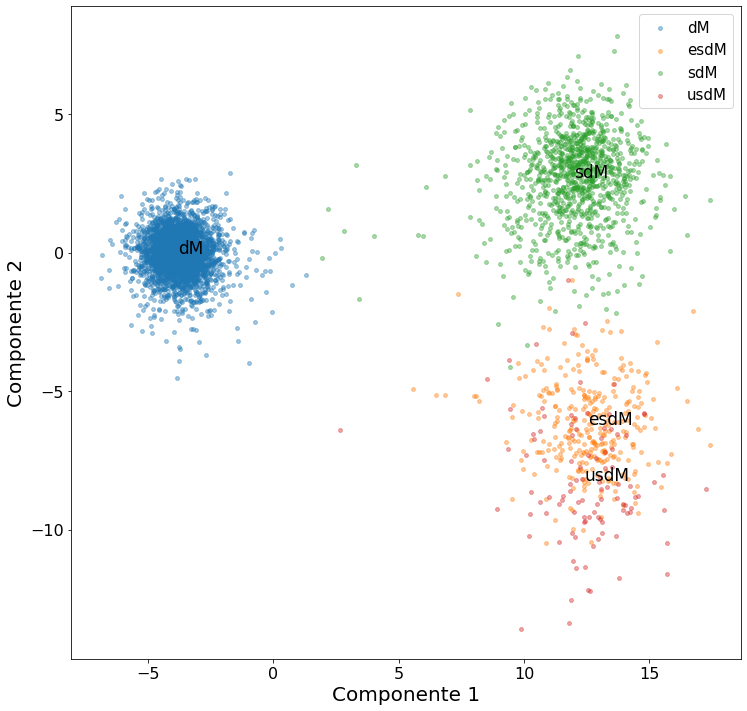

In [ ]:
comp =0
comp_aux =1
fig, ax = plt.subplots(figsize=(12,12))

colors = cm.rainbow(np.linspace(0, 1, len(df_clase_m_enanas.index)))

#['sdM', 'usdM', 'esdM', 'u', 'd']
lista_m = ['sdM', 'usdM', 'esdM', 'dM']
    
for color , clase in zip(colors,df_clase_m_enanas.index):
 
  indices = df_enanas_clase.clase_metalicidad==clase
  ax.scatter(datos_m[indices,comp], datos_m[indices,comp_aux] , label = clase, cmap='viridis',s=15,alpha=0.4)
  if clase in lista_m:
    ax.text(df_centoides_m_adl.loc[clase][comp], df_centoides_m_adl.loc[clase][comp_aux], clase,size=17,c='black')
   

ax.set_xlabel('Componente ' +str(comp+1),size=20)
ax.set_ylabel('Componente '+str(comp_aux+1),size = 20)
ax.tick_params(labelsize=16)

#ax.set_xlim(-7.5,10)
#ax.set_ylim(-10,10)
#ax.set_ylim(-15, 10)


plt.legend(fontsize=15)



##Expectación-Maximización

### Parametrización

In [ ]:
from sklearn.mixture import GaussianMixture

Utilizamos BIC para determinar el tipo de covarianza y el número de componentes.

#### Búsqueda del número de componentes principales y parámetros de mmg

Primero se necesita la matriz de frecuencias por tipo espectral

Se calculan para cada grupo los espectro esperados por metalicidad.

En frecuencias_metal tenemos las metalicidades por subclase observadas

In [ ]:
frecuencias_metal = pd.crosstab(df_enanas_clase['clase_metalicidad'],df_enanas_clase['subclass']) 
#frecuencias_metal.drop(columns=['BR','Ca'],inplace=True)
#frecuencias_metal.reset_index(inplace=True)
frecuencias_metal

subclass           BR  Ca  K5   K7   M0   M1   M2   M3   M4   M5   M6   M7  \
clase_metalicidad                                                            
dM                  0   1   8  370  565  455  814  913  594  306  415  124   
esdM                0   0   0   18  353   54  140   34   25    4    5    7   
sdM                 1   4   1   39  441  271  573  264  118   73   97   60   
usdM                0   0   0    3  180    7   25   10    5    1    0    0   

subclass           M8  M9  
clase_metalicidad          
dM                 62  29  
esdM                5   6  
sdM                86  64  
usdM                3   1

Calculamos para cada metalicidad la fracción por subclase

In [ ]:
frac_metal=frecuencias_metal.T.apply(lambda x: x/x.sum(),axis=1)
frac_metal.T

subclass            BR   Ca        K5        K7        M0        M1        M2  \
clase_metalicidad                                                               
dM                 0.0  0.2  0.888889  0.860465  0.367122  0.578145  0.524485   
esdM               0.0  0.0  0.000000  0.041860  0.229370  0.068615  0.090206   
sdM                1.0  0.8  0.111111  0.090698  0.286550  0.344346  0.369201   
usdM               0.0  0.0  0.000000  0.006977  0.116959  0.008895  0.016108   

subclass                 M3        M4        M5        M6        M7        M8  \
clase_metalicidad                                                               
dM                 0.747748  0.800539  0.796875  0.802708  0.649215  0.397436   
esdM               0.027846  0.033693  0.010417  0.009671  0.036649  0.032051   
sdM                0.216216  0.159030  0.190104  0.187621  0.314136  0.551282   
usdM               0.008190  0.006739  0.002604  0.000000  0.000000  0.019231   

subclass             M9  
clase_metalicidad        
dM                 0.29  
esdM               0.06  
sdM                0.64  
usdM               0.01

Ejecutamos la busqueda de la mejor entropía de metalicidad. 
Para distinto números de componentes  principales se busca el mejor bic y se calcula la entropía para la metalicidad del mismo

In [ ]:
from scipy.stats import entropy

n_comp_pca_m_i = 10
n_comp_pca_m = 60
paso = 10
comp_inicial = 1
num_compo_prinpal =[]
num_grupos=[]
mejor_bic =[]
mejor_varianza=[]
entropia_esperada =[]
entropia_observada =[]

for n_comp_pal in np.arange(n_comp_pca_m_i, n_comp_pca_m, paso):
  lowest_bic = np.infty
  cv_types = ['spherical', 'tied', 'diag', 'full']
  n_components_range = range(3,10)
  for cv_type in cv_types:
      for k in n_components_range:
          gmm_t = GaussianMixture(n_components=k, covariance_type=cv_type, random_state = 0, n_init= 10, init_params='kmeans')
          gmm_t.fit(datos_clase[:,comp_inicial:n_comp_pal])

          bic=gmm_t.bic(datos_clase[:,comp_inicial:n_comp_pal]) #bayesian information criteria. Mejor cuanto más bajo. Penaliza la complejidad
          if bic < lowest_bic:
              lowest_bic = bic
              best_cv = cv_type
              best_k = k
  print ("Criterio BIC: Mejor valor K", best_k, "Mejor tipo de Covarianza", best_cv)

  num_compo_prinpal.append(n_comp_pal)
  num_grupos.append(best_k)
  mejor_bic.append(lowest_bic)
  mejor_varianza.append(best_cv)
  #ejecutamos para el mejor y calculamos indicador de entropía

  gmm_best = GaussianMixture(n_components=best_k, covariance_type=best_cv, random_state = 0, n_init= 10, init_params='kmeans')
  gmm_best.fit(datos_clase[:,:n_comp_pal])
  etiquetas_best = gmm_t.fit_predict(datos_clase[:,:n_comp_pal])
  df_enanas_clase['gmm_grupos_t']=etiquetas_best
  #calculo % pérdida de entropía

  frecuencias_t = pd.crosstab(df_enanas_clase['gmm_grupos_t'], df_enanas_clase['subclass']) 
  frec_cluster_m = np.dot(frac_metal.T.values,frecuencias_t.T.values).astype(int).T
  frec_cluster_m_obs = pd.crosstab(df_enanas_clase['gmm_grupos_t'],df_enanas_clase['clase_metalicidad']) 
  entropia_esperada.append((np.nan_to_num(entropy(frec_cluster_m,axis=1),nan=0)).sum())
  entropia_observada.append((np.nan_to_num(entropy(frec_cluster_m_obs.T),nan=0)).sum())





Criterio BIC: Mejor valor K 9 Mejor tipo de Covarianza full
Criterio BIC: Mejor valor K 9 Mejor tipo de Covarianza full
Criterio BIC: Mejor valor K 8 Mejor tipo de Covarianza full
Criterio BIC: Mejor valor K 6 Mejor tipo de Covarianza full
Criterio BIC: Mejor valor K 6 Mejor tipo de Covarianza full


In [ ]:
n_comp_pca_m_i = 10
n_comp_pca_m = 120
paso = 10
num_compo_prinpal_1 = np.arange(n_comp_pca_m_i+1, n_comp_pca_m, paso)

In [ ]:
num_compo_prinpal_1[4]

51

In [ ]:
num_grupos = [9,9,8,7,6,6,9,9,9,9]

In [ ]:
mejor_bic = [364355.09645804274,
 568975.2940702629,
 759012.4309269219,
 937486.0556971675,
 1105853.568645551,
 1264400.10160379,
 1405420.0109506573,
 1539428.7626689512,
 1658933.6455274583,
 1774765.4107212962,
 1883414.3367867265]

In [ ]:
entropia_esperada = [8.054232035159774,
 8.234000693461809,
 8.195968822204255,
 8.329840528941393,
 8.398628562420123,
 8.415480629656003,
 8.330280072699892,
 8.513272029980978,
 8.435810080326991,
 8.37738754783428,
 8.35242246575862]

In [ ]:
entropia_observada = [4.762904782828748,
 4.342828687864506,
 4.996481814329808,
 5.0943898762364554,
 4.855461758779371,
 6.095181958206524,
 4.649414716086855,
 5.8753221508647515,
 5.919888296270963,
 5.5949575854224,
 5.390209055550556]

In [ ]:
entropia_esperada = [8.054232035159774,
 8.234000693461809,
 8.195968822204255,
 8.329840528941393,
 8.398628562420123,
 8.415480629656003,
 8.330280072699892,
 8.513272029980978,
 8.435810080326991,
 8.37738754783428,
 8.35242246575862]

In [ ]:
entropia_observada

[4.786966525838744,
 4.374841525837343,
 4.36582303944952,
 5.8882347657905925,
 4.955123591554177]

In [ ]:
entropia_esperada

[8.029390379702088,
 8.236961015546356,
 8.255021539594747,
 8.296203045173549,
 8.4673717197839]

In [ ]:
ratio_entropia = np.asarray(entropia_observada)/np.asarray(entropia_esperada)

In [ ]:
ratio_entropia


array([0.59618057, 0.53112325, 0.52886876, 0.70975056, 0.58520209])

In [ ]:
'''
[0.5913543 , 0.52742632, 0.60962675, 0.61158312, 0.57812555,
       0.7242821 , 0.55813426, 0.69013678, 0.70175694, 0.66786424,
       0.64534679])

In [ ]:
mejor_ratio = np.where(ratio_entropia==ratio_entropia.min())[0][0]
print(f"mejor ratio {ratio_entropia.min()}")
mejor_ratio

mejor ratio 0.5288687641224308


2

In [ ]:
num_compo_prinpal[mejor_ratio]

30

In [ ]:
num_grupos[mejor_ratio]

8

In [ ]:
num_compo_prinpal

[10, 20, 30, 40, 50]

In [ ]:
 mejor_varianza[mejor_ratio]

'full'

#### Búsqueda solo de parámetros con representación gráfica

In [ ]:
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
lowest_bic = np.infty
lowest_aic = np.infty
bic = []
aic=[]

cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(2,12)
for cv_type in cv_types:
    for k in n_components_range:
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type, random_state = 0, n_init= 10, init_params='kmeans')
        gmm.fit(datos_clase)
        bic.append(gmm.bic(datos_clase)) #bayesian information criteria. Mejor cuanto más bajo. Penaliza la complejidad
        aic.append(gmm.aic(datos_clase)) #bayesian information criteria. Mejor cuanto más bajo. Penaliza la complejidad
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_cv = cv_type
            best_k = k
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_cv_aic = cv_type
            best_k_aic = k
            
print ("Criterio BIC: Mejor valor K", best_k, "Mejor tipo de Covarianza", best_cv)
print ("Criterio AIC: Mejor valor K", best_k_aic, "Mejor tipo de Covarianza", best_cv_aic)

Criterio BIC: Mejor valor K 9 Mejor tipo de Covarianza spherical
Criterio AIC: Mejor valor K 9 Mejor tipo de Covarianza full


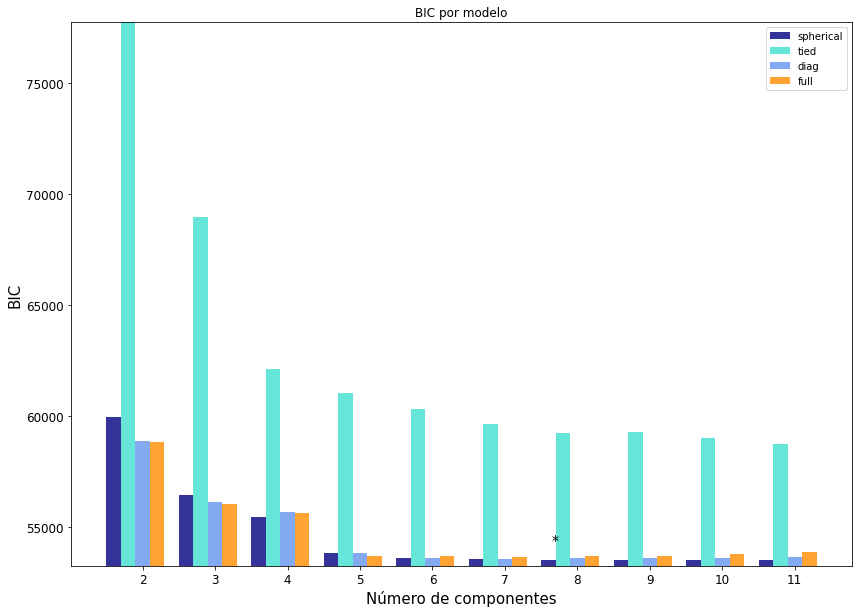

In [ ]:
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
import itertools

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(14, 10))

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color, alpha=0.8))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC por modelo')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
#plt.ylim(0.98e6,1.05e6)
#plt.ylim(40000,70000)
#plt.ylim(-1.7e6,-1.45e6) #normalizadas
plt.ylabel('BIC',size=15)
plt.xlabel('Número de componentes',size=15)
plt.gca().tick_params(labelsize=12)
plt.legend([b[0] for b in bars], cv_types,fontsize=10)

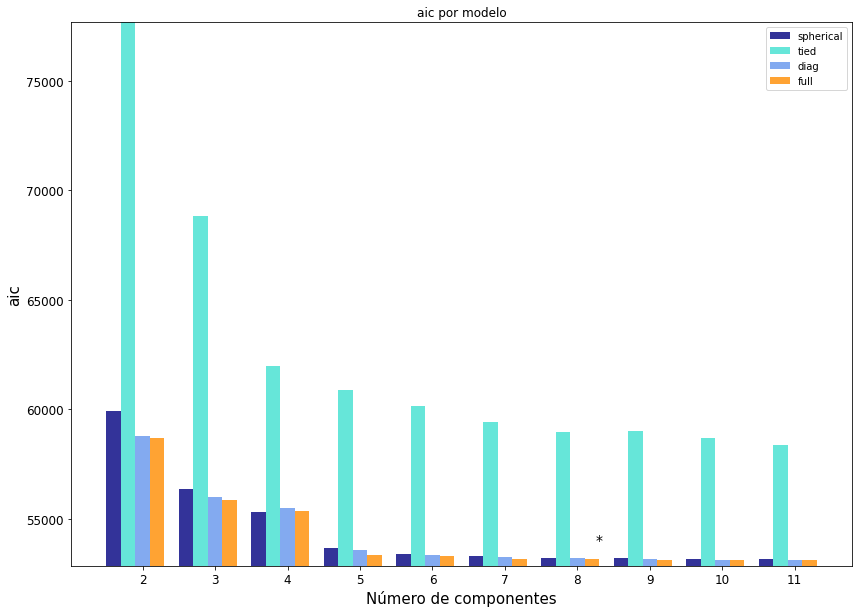

In [ ]:
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
import itertools

aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the aic scores
plt.figure(figsize=(14, 10))

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color, alpha=0.8))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('aic por modelo')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
#plt.ylim(0.875e6,0.98e6)
#plt.ylim(4.0e5,5.5e5) #estandarizadas
#plt.ylim(-1.76e6,-1.5e6) #normalizadas

plt.ylabel('aic',size=15)
plt.xlabel('Número de componentes',size=15)
plt.gca().tick_params(labelsize=12)
plt.legend([b[0] for b in bars], cv_types,fontsize=10)

Vemos que full es el mejor.

### Ejecución del algoritmo

In [ ]:
k=6
max_componente = 50
min_componente = 0
cv_type='full'
gmm_m = GaussianMixture(n_components=k, covariance_type=cv_type, n_init= 10, random_state = 0, init_params='kmeans')
etiquetas = gmm_m.fit_predict(datos_clase[:,min_componente:max_componente])

Podemos ver que ha convergido

In [ ]:
gmm_m.converged_


True

In [ ]:
gmm_m.weights_

array([0.09258243, 0.14853727, 0.0853822 , 0.12969968, 0.10762157,
       0.11486013, 0.08913978, 0.17012449, 0.06205244])

In [ ]:
df_m_clase['gmm_grupos_m']=etiquetas
df_enanas_clase['gmm_grupos_m']=etiquetas

In [ ]:
unique, counts = np.unique(etiquetas, return_counts=True)
dict(zip(unique, counts))

{0: 886, 1: 1228, 2: 1115, 3: 1227, 4: 650, 5: 426, 6: 1103, 7: 999}

### Análisis resultado agrupamiento duro

In [ ]:
unique, counts = np.unique(df_m_clase['gmm_grupos_m'], return_counts=True)
dict(zip(unique,counts))

{0: 984, 1: 494, 2: 1447, 3: 1416, 4: 1057, 5: 858}

In [ ]:
frecuencias = pd.crosstab(df_enanas_clase['gmm_grupos_m'], df_enanas_clase['subclass']) 
frecuencias_subclase=frecuencias.copy()
frecuencias

subclass      Ca  K5   K7   M0   M1   M2   M3   M4   M5   M6   M7  M8  M9
gmm_grupos_m                                                             
0              3   5   51  247  148  233  154   60   42   40    1   0   0
1              0   0    0   31   15   68   53   59   30   33   56  85  64
2              0   0  117  218  171  375  351  198   17    0    0   0   0
3              0   0  126  211  162  236  289  183  120   87    2   0   0
4              0   0    0    2   28   84  168  176  146  316  103  31   3
5              0   3  108  295  123  239   84    6    0    0    0   0   0

**Analizamos el resultado para la clase de metalicidad.**

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs = pd.crosstab(df_enanas_clase['gmm_grupos_m'],df_enanas_clase['clase_metalicidad']) 
frec_cluster_metal_obs

clase_metalicidad    dM  esdM  sdM  usdM
gmm_grupos_m                            
0                   239   165  540    40
1                   171    65  235    23
2                  1447     0    0     0
3                  1415     0    1     0
4                  1052     0    5     0
5                   443    88  286    41

## K-MEANS

### Parametrization



En primer lugar vamos a establecer los parámetros que vamos a considerar por defecto

In [ ]:
# carga librerías

from sklearn.cluster import KMeans
from sklearn import metrics

# parameters
init = 'k-means++' # initialization method 

# to run 10 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 15

# maximum number of iterations for each single run
max_iter = 300 

# controls the tolerance with regard to the changes in the 
# within-cluster sum-squared-error to declare convergence

tol = 1e-04 

 # random seed. Fijamos la secuencia de números aleatorios.
random_state = 0

#### Búsqueda de parámetros

Vamos a elegir K dependiendo de los valores que tome el clustering en cuanto a Distorsión (SSE) y Silhouette desde k = 5 a k = 40


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []

max_rango = 10
min_rango = 2
rango = range(min_rango,max_rango)
for i in rango:
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    etiquetas = km.fit_predict(datos_clase)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(datos_clase, etiquetas))

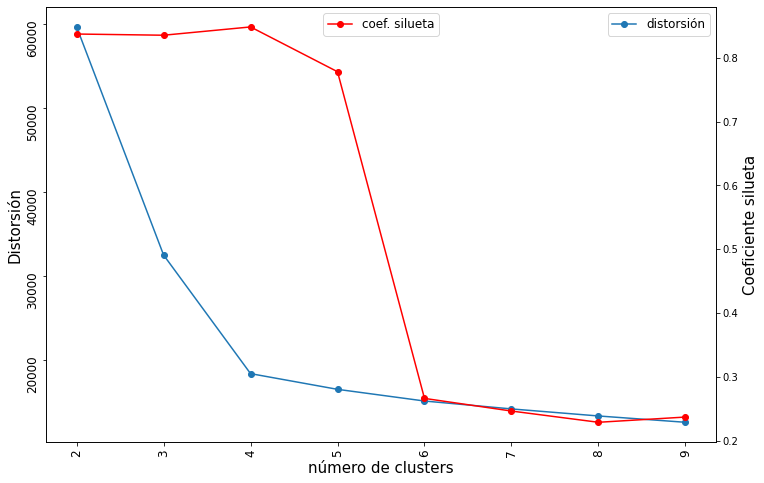

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,8))

ax2 = ax1.twinx()
ax1.plot(rango, distortions, marker='o', label = 'distorsión')
ax2.plot(rango, silhouettes, c='r',marker='o', label = 'coef. silueta')


ax1.set_xlabel('número de clusters',size=15)
ax1.set_ylabel('Distorsión',size=15)
ax2.set_ylabel('Coeficiente silueta',size=15)
#ax2.set_title('Silhouette y distorsion vs clusters K-means')


ax1.legend(loc='best',fontsize=12)
ax2.legend(loc='upper center',fontsize=12)

ax1.tick_params(labelsize=12,labelrotation=90)
plt.xticks(np.arange(min_rango, max_rango))
plt.show()

El silohouette cuanto más cerca de 1 mejor. La distorsión cuanto menor menor. Luego hay que coger un punto intermedio. Es la interpretación de los grupos lo que nos dará la bondad de la decisión.



Inspeccionamos el diagrama silueta para distintos k

In [ ]:
set(etiquetas)

4
5
6
7


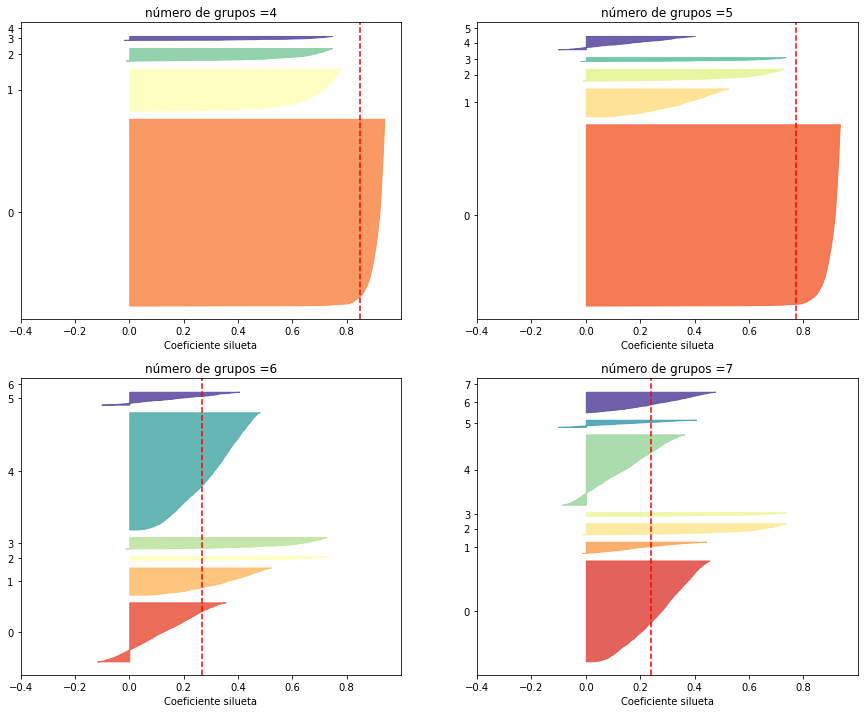

In [ ]:
from sklearn.metrics import silhouette_samples #Nos devuelve el coeficiente silueta de cada muestra
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(15, 12))

for j, k in enumerate([4,5,6,7]): 

    plt.subplot(2, 2, j+1)

    km = KMeans(k, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    etiquetas = km.fit_predict(datos_clase)
    silhouette_coefficients = silhouette_samples(datos_clase, etiquetas)
    n_clusters_ = len(set(etiquetas))
    print(n_clusters_)
    padding = datos.shape[0] // 30
    pos = padding
    ticks = []
    for i in range(n_clusters_+1):
        coeffs = silhouette_coefficients[etiquetas == i]
        coeffs.sort()

        color = mpl.cm.Spectral((i+1) / n_clusters_)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.9)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(0,n_clusters_+1)))
    if k in (0, 2):
        plt.ylabel("Grupo")
    
    plt.gca().set_xticks([-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8])
    #if k in (2, 3):
      #plt.gca().set_xticks([-1,-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel("Coeficiente silueta")
    #else:
        #plt.tick_params(labelbottom=False)
    plt.xlim(-0.4,1)
    plt.axvline(x=metrics.silhouette_score(datos_clase, etiquetas), color="red", linestyle="--")
    plt.title(f"número de grupos ={k}", fontsize=12)

#save_fig("silhouette_analysis_plot")
plt.show()


### Ejecución del Algoritmo

In [ ]:
datos_clase.shape

(6256, 3)

In [ ]:
k = 4


km_EM_m= KMeans(k, init, n_init = iterations , 
                max_iter= max_iter, tol = tol, random_state = random_state)

y_km_EM_m = km_EM_m.fit_predict(datos_clase)

In [ ]:
km_EM_m

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
print(f"Coeficiente silueta {metrics.silhouette_score(datos_clase, y_km_EM_m)}")

Coeficiente silueta 0.8485366232383751


In [ ]:
etiquetas_clases = np.unique(y_km_EM_m)
etiquetas_clases

array([0, 1, 2, 3], dtype=int32)

In [ ]:
unique, counts = np.unique(y_km_EM_m, return_counts=True)
dic_clases =dict(zip(unique, counts))
dic_clases

{0: 4773, 1: 1062, 2: 320, 3: 101}

Añadimos a los dataset las etiquetas. Sumamos uno para que el primer grupo sea el 1

In [ ]:
df_m_clase['clases_kmeans_m']=y_km_EM_m+1
df_enanas_clase['clases_kmeans_m']=y_km_EM_m+1


In [ ]:
datos_pca.shape

(6256, 240)

### Análisis resultado

In [ ]:
unique_1, counts = np.unique(df_m_clase['clases_kmeans_m'], return_counts=True)
dict(zip(unique_1,counts))

{1: 4774, 2: 1070, 3: 323, 4: 101}

In [ ]:
frecuencias = pd.crosstab(df_enanas_clase['clases_kmeans_m'], df_enanas_clase['subclass']) 
frecuencias_subclase=frecuencias.copy()
frecuencias

subclass         Ca  K5   K7   M0   M1   M2   M3   M4   M5   M6   M7  M8  M9
clases_kmeans_m                                                             
1                 1   8  374  602  465  846  928  600  306  417  127  65  35
2                 2   0   18  179  143  295  149   66   47   55   32  49  35
3                 0   0    9  150   34   79   19   14    2    4    4   4   4
4                 0   0    1   73    5   15    3    2    0    0    0   2   0

**Analizamos el resultado para la clase de metalicidad.**

En frecuencias_metal tenemos las metalicidades por subclase observadas

In [ ]:
frecuencias_metal = pd.crosstab(df_enanas_clase['clase_metalicidad'],df_enanas_clase['subclass']) 
#frecuencias_metal.drop(columns=['L0','BR','Ca'],inplace=True)
#frecuencias_metal.reset_index(inplace=True)
frecuencias_metal

subclass           Ca  K5   K7   M0   M1   M2   M3   M4   M5   M6   M7  M8  M9
clase_metalicidad                                                             
dM                  1   8  373  598  465  845  928  600  306  417  127  65  35
esdM                0   0    9  150   34   77   19   14    2    4    4   4   4
sdM                 2   0   19  180  143  298  149   66   47   55   32  49  35
usdM                0   0    1   76    5   15    3    2    0    0    0   2   0

Calculamos para cada metalicidad la fracción por subclase

In [ ]:
frac_metal=frecuencias_metal.T.apply(lambda x: x/x.sum(),axis=1)
frac_metal.T

subclass                 Ca   K5        K7        M0        M1        M2  \
clase_metalicidad                                                          
dM                 0.333333  1.0  0.927861  0.595618  0.718702  0.684211   
esdM               0.000000  0.0  0.022388  0.149402  0.052550  0.062348   
sdM                0.666667  0.0  0.047264  0.179283  0.221020  0.241296   
usdM               0.000000  0.0  0.002488  0.075697  0.007728  0.012146   

subclass                 M3        M4        M5        M6        M7        M8  \
clase_metalicidad                                                               
dM                 0.844404  0.879765  0.861972  0.876050  0.779141  0.541667   
esdM               0.017288  0.020528  0.005634  0.008403  0.024540  0.033333   
sdM                0.135578  0.096774  0.132394  0.115546  0.196319  0.408333   
usdM               0.002730  0.002933  0.000000  0.000000  0.000000  0.016667   

subclass                 M9  
clase_metalicidad            
dM                 0.472973  
esdM               0.054054  
sdM                0.472973  
usdM               0.000000

Calculamos por cada grupo el número de objetos por subclase esperado si la distribución fuera aleatoria. Para ello multiplicamos para cada cluster el número de enanas de cada subclase por  la fracción de cada metalicidad en la subclase y sumamos para cada metalicidad

Calculamos la frecuencia esperada de cada metalicidad por grupo

In [ ]:
pd.set_option("display.max_columns",50)

In [ ]:
frec_cluster_metal = pd.DataFrame(data=np.dot(frac_metal.T.values,frecuencias_subclase.T.values),
                                  columns=frecuencias_subclase.index,
                                  index=frecuencias_metal.index)
frec_cluster_metal.astype(int).T

clase_metalicidad    dM  esdM  sdM  usdM
clases_kmeans_m                         
1                  3718   216  773    65
2                   769    62  219    19
3                   216    30   62    12
4                    63    12   19     5

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs = pd.crosstab(df_enanas_clase['clase_metalicidad'],df_enanas_clase['clases_kmeans_m']) 
frec_cluster_metal_obs

clases_kmeans_m       1     2    3    4
clase_metalicidad                      
dM                 4768     0    0    0
esdM                  0     5  316    0
sdM                   6  1064    5    0
usdM                  0     1    2  101

 # Verificación resultados metalicidad  usando el dataset de test.

Usamos el data set de prueba creado con anterioridad

## Componentes PCA ya creadas.

In [ ]:

datos_m_test = datos_test #estos datos ya están escalados

Los camibos de nombres se hace para reutilizar código

In [ ]:
datos_clase_test=datos_m_test
datos_m_clase_test=datos_pca_test
df_m_clase_test=df_enanas_pca_test_sin_out
df_enanas_clase_test=df_enanas_test_sin_out
#df_m_clase_test.reset_index(drop=True, inplace=True)
#df_enanas_clase_test.reset_index(drop=True, inplace=True)
df_m_clase.shape


(6256, 244)

## Componentes ADL del conjunto de test

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Estandarizamos los flujos de test

Seleccionamos subconjunto  de las subenanas. 


In [ ]:
#indice_subenanas = df_enanas.clase_metalicidad!='dM'
indice_subenanas_test = df_enanas_test_sin_out.clase_metalicidad!=None #seleccionamos también las enanas

indice_subenanas_test.sum()

6172

In [ ]:
lda_test = LDA()
#e_flujos_em_test ya está estadarizada
lda_test.fit(e_flujos_em_test_sin_out[indice_subenanas_test], df_enanas_test_sin_out.clase_metalicidad[indice_subenanas_test])
X_lda_em_test = lda_test.transform(e_flujos_em_test_sin_out)


In [ ]:
e_flujos_em_test_sin_out[indice_subenanas_test].max()

18.65169544411747

In [ ]:
lda_test.explained_variance_ratio_


array([0.82567997, 0.1177303 , 0.05658973])

In [ ]:
indices_out_single_test

[267, 500, 1095, 1105, 1179, 1200, 3810, 3967, 5746]

In [ ]:
componentes=[0,1,2]
datos_m_test = X_lda_em_test[:,componentes] 

Los cambios de nombres son para reutilizar lo ya hecho

In [ ]:
datos_clase_test=datos_m_test
datos_m_clase_test=datos_pca_test
df_m_clase_test=df_enanas_pca_test_sin_out
df_enanas_clase_test=df_enanas_test_sin_out
df_m_clase_test.reset_index(drop=True, inplace=True)
df_enanas_clase_test.reset_index(drop=True, inplace=True)
df_m_clase.shape


(6256, 243)

In [ ]:
df_enanas_adl_test = pd.DataFrame(data=datos_clase_test)
df_enanas_adl_test['clase_metalicidad']=df_enanas_clase_test.clase_metalicidad
df_enanas_adl_test


0         1         2 clase_metalicidad
0     10.847057 -8.051769 -3.133702              esdM
1     10.725153  3.670177  1.674054               sdM
2      9.346392  0.832711  0.214380               sdM
3      8.264542  2.465150 -1.091851               sdM
4      9.299287 -5.871318 -5.547533              esdM
...         ...       ...       ...               ...
6167  -3.192235 -0.532417 -0.498500                dM
6168  -3.241831  0.030578 -0.265053                dM
6169  -2.869259 -0.371201 -0.107455                dM
6170  -2.935522 -0.695298 -0.034265                dM
6171  -4.332002 -0.778405  1.482384                dM

[6172 rows x 4 columns]

### Representación gráfica

In [ ]:
df_centoides_m_adl_test = df_enanas_adl_test.groupby('clase_metalicidad').mean()
df_centoides_m_adl_test

0         1         2
clase_metalicidad                               
dM                 -3.012563 -0.034357 -0.003373
esdM               10.007544 -4.630553 -4.232562
sdM                 9.336100  2.795579  0.509552
usdM               10.167856 -8.885532  6.787092

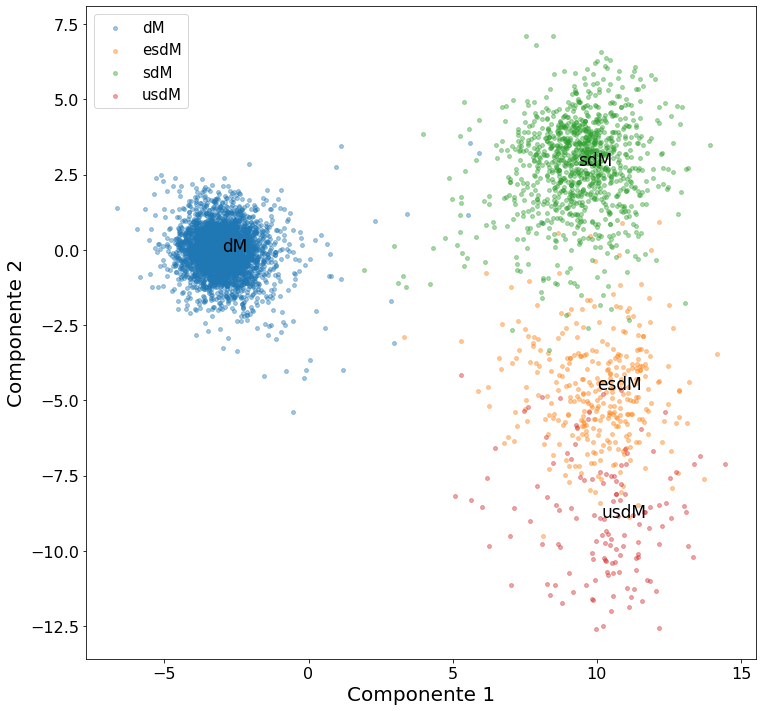

In [ ]:
comp =0
comp_aux =1
fig, ax = plt.subplots(figsize=(12,12))

colors = cm.rainbow(np.linspace(0, 1, len(df_clase_m_enanas.index)))

#['sdM', 'usdM', 'esdM', 'u', 'd']
lista_m = ['sdM', 'usdM', 'esdM', 'dM']
    
for color , clase in zip(colors,df_clase_m_enanas_test.index):
 
  indices = df_enanas_clase_test.clase_metalicidad==clase
  ax.scatter(datos_m_test[indices,comp], datos_m_test[indices,comp_aux] , label = clase, cmap='viridis',s=15,alpha=0.4)
  if clase in lista_m:
    ax.text(df_centoides_m_adl_test.loc[clase][comp], df_centoides_m_adl_test.loc[clase][comp_aux], clase,size=17,c='black')
   

ax.set_xlabel('Componente ' +str(comp+1),size=20)
ax.set_ylabel('Componente '+str(comp_aux+1),size = 20)
ax.tick_params(labelsize=16)

#ax.set_xlim(-7.5,10)
#ax.set_ylim(-10,10)
#ax.set_ylim(-15, 10)


plt.legend(fontsize=15)



##Expectación-Maximización sobre conjunto de prueba

### Parametrización

In [ ]:
from sklearn.mixture import GaussianMixture

### Ejecución del algoritmo

In [ ]:
k=6
cv_type='full'
gmm_m_test = GaussianMixture(n_components=k, covariance_type=cv_type, n_init= 10, random_state = 0, init_params='kmeans')
etiquetas = gmm_m_test.fit_predict(datos_clase_test)

In [ ]:
gmm_m_test.weights_

array([0.18682349, 0.20534404, 0.1905683 , 0.17826732, 0.1787374 ,
       0.06025946])

In [ ]:
df_m_clase_test['gmm_grupos_m']=etiquetas
df_enanas_clase_test['gmm_grupos_m']=etiquetas

### Análisis resultado agrupamiento duro

In [ ]:
unique, counts = np.unique(df_m_clase['gmm_grupos_m'], return_counts=True)
dict(zip(unique,counts))

{0: 984, 1: 494, 2: 1447, 3: 1416, 4: 1057, 5: 858}

In [ ]:
frecuencias = pd.crosstab(df_enanas_clase_test['gmm_grupos_m'], df_enanas_clase_test['subclass']) 
frecuencias_subclase=frecuencias.copy()
frecuencias

subclass      BR  Ca  G5  K3  K5   K7  L0  L9   M0   M1   M2   M3   M4   M5  \
gmm_grupos_m                                                                  
0              0   0   0   0   0    0   0   0    0    3   84  197  188  207   
1              0   0   1   1  20  235   0   0  440  171  212  142   44    1   
2              0   0   0   0   0  190   0   0  185  162  203  230  152   48   
3              1   1   0   3   9   62   0   0  165   84  188  167  133   86   
4              0   4   0   0  24  199   0   0  382  198  217   72    6    0   
5              0   0   0   0   2    3   1   1   24   10   34   39   33   12   

subclass       M6   M7  M8  M9  ST  T2  
gmm_grupos_m                            
0             323  124  23   9   0   0  
1               0    0   0   0   1   0  
2               7    0   0   0   0   0  
3             162   33   0   0   1   1  
4               0    0   0   0   0   0  
5              14   45  85  68   0   0

**Analizamos el resultado para la clase de metalicidad.**

Calculamos la frecuencia esperada de cada metalicidad por grupo

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs_t = pd.crosstab(df_enanas_clase_test['gmm_grupos_m'],df_enanas_clase_test['clase_metalicidad']) 
frec_cluster_metal_obs_t

clase_metalicidad    dM  esdM  sdM  usdM
gmm_grupos_m                            
0                  1156     0    2     0
1                   916    81  242    29
2                  1177     0    0     0
3                   629   103  317    47
4                   657   106  298    41
5                   158    39  160    14

In [ ]:
#df_=frec_cluster_metal_obs_t.reindex(columns=['dM','sdM','esdM','usdM'])
df_= frec_cluster_metal_obs_t
indices = [np.argmax(x) for x in df_.values]
list_indices = list(zip(np.arange(0,len(indices)), indices))
list_indices.sort(key=lambda x: x[1])
list_indices= [x[0]for x in list_indices]
dict_indices = dict(zip(list_indices,np.arange(0,len(indices))))
dict_indices

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
df_enanas_clase_test['gmm_grupos_m'].replace(dict_indices, inplace=True)

## Clustering K-MEANS sobre el conjunto de test

### Parametrization



En primer lugar vamos a establecer los parámetros que vamos a considerar por defecto

In [ ]:
# carga librerías

from sklearn.cluster import KMeans
from sklearn import metrics

# parameters
init = 'k-means++' # initialization method 

# to run 10 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 15

# maximum number of iterations for each single run
max_iter = 300 

# controls the tolerance with regard to the changes in the 
# within-cluster sum-squared-error to declare convergence

tol = 1e-04 

 # random seed. Fijamos la secuencia de números aleatorios.
random_state = 0

#### Búsqueda de parámetros

Vamos a elegir K dependiendo de los valores que tome el clustering en cuanto a Distorsión (SSE) y Silhouette desde k = 5 a k = 40


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []

max_rango = 10
min_rango = 2
rango = range(min_rango,max_rango)
for i in rango:
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    etiquetas = km.fit_predict(datos_clase_test)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(datos_clase_test, etiquetas))

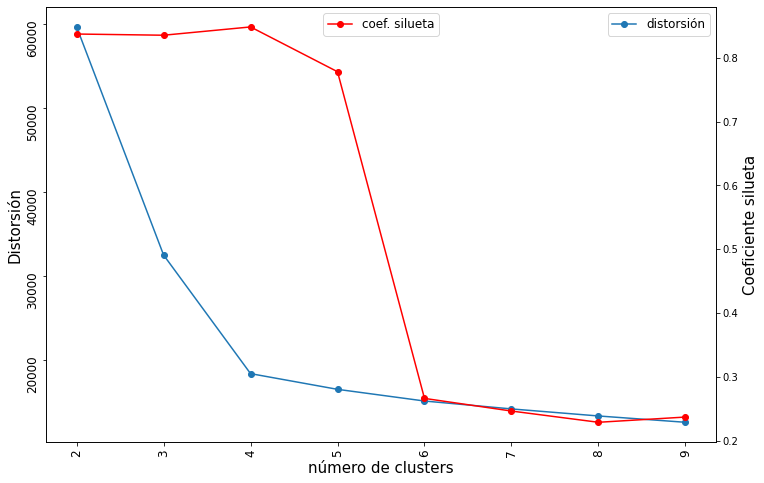

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,8))

ax2 = ax1.twinx()
ax1.plot(rango, distortions, marker='o', label = 'distorsión')
ax2.plot(rango, silhouettes, c='r',marker='o', label = 'coef. silueta')


ax1.set_xlabel('número de clusters',size=15)
ax1.set_ylabel('Distorsión',size=15)
ax2.set_ylabel('Coeficiente silueta',size=15)
#ax2.set_title('Silhouette y distorsion vs clusters K-means')


ax1.legend(loc='best',fontsize=12)
ax2.legend(loc='upper center',fontsize=12)

ax1.tick_params(labelsize=12,labelrotation=90)
plt.xticks(np.arange(min_rango, max_rango))
plt.show()

El silohouette cuanto más cerca de 1 mejor. La distorsión cuanto menor menor. Luego hay que coger un punto intermedio. Es la interpretación de los grupos lo que nos dará la bondad de la decisión.



Inspeccionamos el diagrama silueta para distintos k

In [ ]:
set(etiquetas)

<br>
<br>

### Ejecución del Algoritmo

In [ ]:
k = 4

km_EM_m_test= KMeans(k, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

y_km_EM_m_test = km_EM_m_test.fit_predict(datos_clase_test)

In [ ]:
print(f"Coeficiente silueta {metrics.silhouette_score(datos_clase_test, y_km_EM_m_test)}")

Coeficiente silueta 0.8210636541212325


In [ ]:
etiquetas_clases_test = np.unique(y_km_EM_m_test)
etiquetas_clases_test

array([0, 1, 2, 3], dtype=int32)

In [ ]:
unique, counts = np.unique(y_km_EM_m_test, return_counts=True)
dic_clases_test =dict(zip(unique, counts))
dic_clases_test

{0: 4694, 1: 326, 2: 1023, 3: 129}

Añadimos a los dataset las etiquetas. Sumamos uno para que el primer grupo sea el 1

In [ ]:
df_m_clase_test['clases_kmeans_m']=y_km_EM_m_test+1
df_enanas_clase_test['clases_kmeans_m']=y_km_EM_m_test+1


Añadimos a los dataset las etiquetas. Sumamos uno para que el primer grupo sea el 1

### Análisis resultado

In [ ]:
frecuencias = pd.crosstab(df_enanas_clase_test['clases_kmeans_m'], df_enanas_clase_test['subclass']) 
frecuencias_subclase=frecuencias.copy()
frecuencias

subclass         BR  Ca  G5  K3  K5   K7  L0  L9   M0   M1   M2   M3   M4  \
clases_kmeans_m                                                             
1                 0   0   0   0   0    7   0   0  203   20   60   14   11   
2                 1   2   0   0   1   22   1   0  259  128  274  113   52   
3                 0   3   1   4  54  658   0   1  632  478  594  713  490   
4                 0   0   0   0   0    2   0   0  102    2   10    7    3   

subclass          M5   M6   M7  M8  M9  ST  T2  
clases_kmeans_m                                 
1                  2    1    3   2   3   0   0  
2                 25   42   28  40  35   0   0  
3                326  463  171  65  38   2   1  
4                  1    0    0   1   1   0   0

**Analizamos el resultado para la clase de metalicidad.**

En frecuencias_metal tenemos las metalicidades por subclase observadas

In [ ]:
frecuencias_metal = pd.crosstab(df_enanas_clase_test['clase_metalicidad'],df_enanas_clase_test['subclass']) 
#frecuencias_metal.drop(columns=['L0','BR','Ca'],inplace=True)
#frecuencias_metal.reset_index(inplace=True)
frecuencias_metal

subclass           BR  Ca  G5  K3  K5   K7  L0  L9   M0   M1   M2   M3   M4  \
clase_metalicidad                                                             
dM                  0   3   1   4  54  658   0   1  631  479  593  713  490   
esdM                0   0   0   0   0    9   0   0  201   20   62   15   11   
sdM                 1   2   0   0   1   20   1   0  260  127  273  112   52   
usdM                0   0   0   0   0    2   0   0  104    2   10    7    3   

subclass            M5   M6   M7  M8  M9  ST  T2  
clase_metalicidad                                 
dM                 326  463  171  65  38   2   1  
esdM                 2    1    3   2   3   0   0  
sdM                 25   42   28  40  35   0   0  
usdM                 1    0    0   1   1   0   0

Calculamos para cada metalicidad la fracción por subclase

In [ ]:
frac_metal=frecuencias_metal.T.apply(lambda x: x/x.sum(),axis=1)
frac_metal.T

subclass            BR   Ca   G5   K3        K5        K7   L0   L9        M0  \
clase_metalicidad                                                               
dM                 0.0  0.6  1.0  1.0  0.981818  0.955007  0.0  1.0  0.527592   
esdM               0.0  0.0  0.0  0.0  0.000000  0.013062  0.0  0.0  0.168060   
sdM                1.0  0.4  0.0  0.0  0.018182  0.029028  1.0  0.0  0.217391   
usdM               0.0  0.0  0.0  0.0  0.000000  0.002903  0.0  0.0  0.086957   

subclass                 M1        M2        M3        M4        M5        M6  \
clase_metalicidad                                                               
dM                 0.762739  0.632196  0.841795  0.881295  0.920904  0.915020   
esdM               0.031847  0.066098  0.017710  0.019784  0.005650  0.001976   
sdM                0.202229  0.291045  0.132231  0.093525  0.070621  0.083004   
usdM               0.003185  0.010661  0.008264  0.005396  0.002825  0.000000   

subclass                 M7        M8        M9   ST   T2  
clase_metalicidad                                          
dM                 0.846535  0.601852  0.493506  1.0  1.0  
esdM               0.014851  0.018519  0.038961  0.0  0.0  
sdM                0.138614  0.370370  0.454545  0.0  0.0  
usdM               0.000000  0.009259  0.012987  0.0  0.0

Calculamos por cada grupo el número de objetos por subclase esperado si la distribución fuera aleatoria. Para ello multiplicamos para cada cluster el número de enanas de cada subclase por  la fracción de cada metalicidad en la subclase y sumamos para cada metalicidad

Calculamos la frecuencia esperada de cada metalicidad por grupo

In [ ]:
pd.set_option("display.max_columns",50)

In [ ]:
frec_cluster_metal = pd.DataFrame(data=np.dot(frac_metal.T.values,frecuencias_subclase.T.values),
                                  columns=frecuencias_subclase.index,
                                  index=frecuencias_metal.index)
frec_cluster_metal.astype(int).T

clase_metalicidad    dM  esdM  sdM  usdM
clases_kmeans_m                         
1                   196    39   71    18
2                   698    71  225    28
3                  3724   199  694    75
4                    74    18   27     9

In [ ]:
# clases de metalicidad observadas por clúster
frec_cluster_metal_obs_t = pd.crosstab(df_enanas_clase_test['clase_metalicidad'],df_enanas_clase_test['clases_kmeans_m']) 
frec_cluster_metal_obs_t

clases_kmeans_m       1    2     3    4
clase_metalicidad                      
dM                 4688    0     5    0
esdM                  1  318    10    0
sdM                   5    5  1008    1
usdM                  0    3     0  128

Cambiamos etiquetas de k-means para que coincidan con la clase de metalicidad mayoritaria

In [ ]:
#df_=frec_cluster_metal_obs_t.reindex(columns=['dM','sdM','esdM','usdM'])
df_= frec_cluster_metal_obs_t
indices = [np.argmax(x) for x in df_.values]
list_indices = list(zip(np.arange(0,len(indices)), indices))
list_indices.sort(key=lambda x: x[1])
list_indices= [x[0]for x in list_indices]
dict_indices = dict(zip(list_indices,np.arange(0,len(indices))))
dict_indices

{0: 0, 1: 1, 2: 2, 3: 3}

In [ ]:
df_enanas_clase_test['clases_kmeans_m'].replace(dict_indices,inplace=True)

## Predicción clases sobre conjunto de test

### Proyección espectros conjunto de test sobre las PCA del conjunto original

Primero estandarizamos con la parametrización del conjunto inicial y luego se proyects sobre las PCA.

In [ ]:
e_flujos_em_test_p = sc_em.transform(flujos_BD_test[indices_tipicos_test]) #estandarización
X_pca_em_test_p = estimator_em.transform(e_flujos_em_test_p) #proyección sobre PCA conjunto original

In [ ]:
datos_p = X_pca_em_test_p[:,:datos_clase_test.shape[1]]
datos_p.shape

(6172, 50)

### Proyección espectros conjunto de test sobre las componentes ADL del conjunto original

Usando la agregacion obtenida con K-means sobre el conjunto inicial predecimos las clases sobre el de test

Primero estandarizamos con la parametrización del conjunto inicial

In [ ]:
e_flujos_em_test_p = sc_em.transform(flujos_BD_test[indices_tipicos_test]) #estandarización
X_ADL_em_test_p = lda.transform(e_flujos_em_test_p) #proyección sobre ADL conjunto original


In [ ]:
datos_p = X_ADL_em_test_p
datos_p.shape

(6172, 3)

In [ ]:
e_flujos_em_test_p.max()

19.333434091316114

In [ ]:
X_ADL_em_test_p.max()

66.55761768127105

#### Representación gráfica

In [ ]:
df_proyeccion_adl_test = pd.DataFrame(data=datos_p)
df_proyeccion_adl_test['clase_metalicidad']=df_enanas_clase_test.clase_metalicidad
df_proyeccion_adl_test


0         1         2 clase_metalicidad
0      8.928269 -3.856817  2.335918              esdM
1     -0.442546 -4.292265  1.818772               sdM
2     15.853650  1.595072 -1.007195               sdM
3      8.900173 -4.261184  2.102147               sdM
4      9.964102 -7.509894 -0.857864              esdM
...         ...       ...       ...               ...
6167  -4.287468 -0.024053 -0.154236                dM
6168  -4.231328  0.428870 -0.365328                dM
6169  -2.924353  0.090556  0.337139                dM
6170  -3.527350 -1.032999 -0.716660                dM
6171  -3.957071 -1.323238  2.228238                dM

[6172 rows x 4 columns]

In [ ]:
df_centoides_m_adl_proyeccion = df_proyeccion_adl_test.groupby('clase_metalicidad').mean()
df_centoides_m_adl_proyeccion

0         1         2
clase_metalicidad                               
dM                 -3.665335  0.055531 -0.038241
esdM               11.728142 -2.340858  0.818481
sdM                11.068569  0.735795  0.147070
usdM               11.218012 -5.489765  1.833358

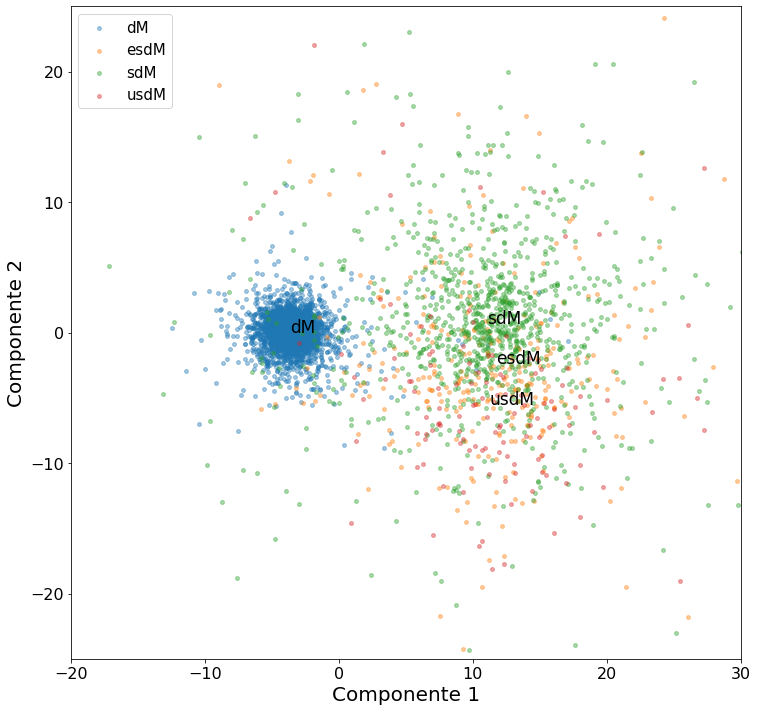

In [ ]:
comp =0
comp_aux =1
fig, ax = plt.subplots(figsize=(12,12))

colors = cm.rainbow(np.linspace(0, 1, len(df_centoides_m_adl_proyeccion.index)))

#['sdM', 'usdM', 'esdM', 'u', 'd']
lista_m = ['sdM', 'usdM', 'esdM', 'dM']
    
for color , clase in zip(colors,df_centoides_m_adl_proyeccion.index):
 
  indices = df_enanas_clase_test.clase_metalicidad==clase
  ax.scatter(datos_p[indices,comp], datos_p[indices,comp_aux] , label = clase, cmap='viridis',s=15,alpha=0.4)
  if clase in lista_m:
    ax.text(df_centoides_m_adl_proyeccion.loc[clase][comp], df_centoides_m_adl_proyeccion.loc[clase][comp_aux], clase,size=17,c='black')
   

ax.set_xlabel('Componente ' +str(comp+1),size=20)
ax.set_ylabel('Componente '+str(comp_aux+1),size = 20)
ax.tick_params(labelsize=16)

ax.set_xlim(-20,30)
ax.set_ylim(-25,25)
#ax.set_ylim(-15, 10)


plt.legend(fontsize=15)



### Predicción de la clase con GMM

In [ ]:
etiquetas_predichas_m =gmm_m.predict(datos_p)

In [ ]:
etiquetas_prueba = gmm_m.predict(datos_clase[:,min_componente:max_componente])

In [ ]:
df_enanas_clase['gmm_grupos_m_prueba']=etiquetas_prueba

In [ ]:
pd.crosstab(df_enanas_clase['gmm_grupos_m_prueba'], df_enanas_clase['clase_metalicidad']) 

clase_metalicidad      dM  esdM  sdM  usdM
gmm_grupos_m_prueba                       
0                     239   165  540    40
1                     171    65  235    23
2                    1447     0    0     0
3                    1415     0    1     0
4                    1052     0    5     0
5                     443    88  286    41

In [ ]:
df_enanas_test_sin_out['gmm_clases_predichas_m'] = etiquetas_predichas_m
df_enanas_pca_test_sin_out['gmm_clases_predichas_m'] = etiquetas_predichas_m

In [ ]:
df_prediccion = pd.crosstab(df_enanas_test_sin_out['gmm_grupos_m'], df_enanas_test_sin_out['gmm_clases_predichas_m']) 
df_prediccion

In [ ]:
pd.crosstab(df_enanas_test_sin_out['cod_metalicidad'], df_enanas_test_sin_out['gmm_clases_predichas_m']).T

cod_metalicidad            1    2    3   4
gmm_clases_predichas_m                    
0                       1207    1    7   0
1                       1109    0    6   0
2                        971    0    0   0
3                        560  149  405  65
4                        634  140  409  49
5                        212   39  192  17

Se reorganizan las etiquetas

In [ ]:

df_= df_prediccion
indices = [np.argmax(x) for x in df_.values.T]
list_indices = list(zip(np.arange(0,len(indices)), indices))
list_indices.sort(key=lambda x: x[1])
list_indices= [x[0]for x in list_indices]
dict_indices = dict(zip(list_indices,np.arange(0,len(indices))))
dict_indices

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
#dict_indices[3] = 3
#dict_indices[2] = 2
dict_indices[4] = 3
dict_indices[3] = 4

In [ ]:
df_enanas_test_sin_out['gmm_clases_predichas_m'].replace(dict_indices,inplace=True)
df_enanas_pca_test_sin_out['gmm_clases_predichas_m'].replace(dict_indices,inplace=True)

In [ ]:
df_prediccion = pd.crosstab(df_enanas_test_sin_out['gmm_grupos_m'], df_enanas_test_sin_out['gmm_clases_predichas_m'])
df_prediccion

gmm_clases_predichas_m    0    1    2    3    4    5
gmm_grupos_m                                        
0                       853  229    0    0   76    0
1                         0  669    7    0  592    0
2                         0  208  964    0    5    0
3                       241    0    0  751    0  104
4                       114    9    0  420  559    0
5                         7    0    0    8    0  356

#### Evaluación resultado

In [ ]:
print(f"precisión = {(df_enanas_test_sin_out['gmm_grupos_m']==df_enanas_test_sin_out['gmm_clases_predichas_m']).sum()/df_enanas_test_sin_out.shape[0]}")

precisión = 0.6727154893065457


##### Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix_2(y_true, y_pred, normalize=False, title=None, label_x = None, label_y=None, verbose = False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if verbose:
          print(cm.shape)
          print("Normalized confusion matrix")
    else:
        if verbose:
          print('Confusion matrix, without normalization')

    #print(cm)

    #COMIENZA EL GRÁFICO
    fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
  
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
            )
    
    ax.set_ylabel(label_y, size = 15 )
    ax.set_xlabel(label_x, size = 15 )

    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor",size=15)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor",size=15)

    

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black") #va es vertical aligment
    fig.tight_layout()
    return ax

Para comparar usando la matriz de confusión el el ersultado de la predicción con las etiquites de metalicidad  creamos una nueva columna con labelencoder

In [ ]:
label_y = 'clases de metalicidad',

In [ ]:
cod_clase_metalicidad = LabelEncoder()
df_enanas_test_sin_out['cod_metalicidad']=cod_clase_metalicidad.fit_transform(df_enanas_test_sin_out.clase_metalicidad)+1

In [ ]:
cod_clase_metalicidad.inverse_transform([0,1,2,3])

array(['dM', 'esdM', 'sdM', 'usdM'], dtype=object)

AxesImage(108,72;669.6x434.88)


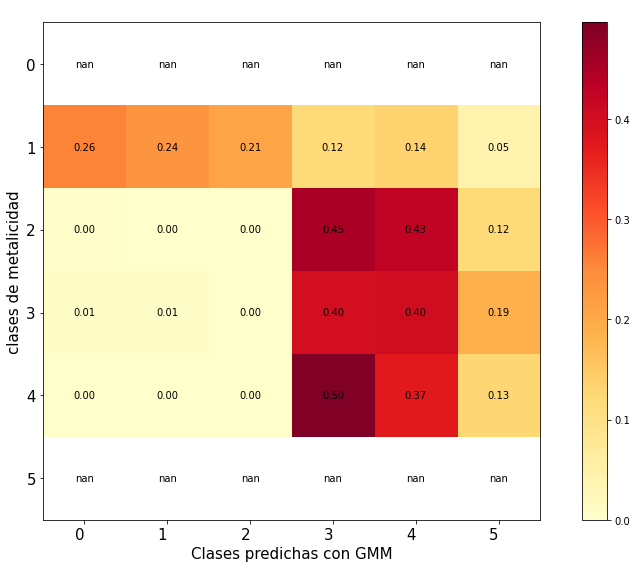

In [ ]:
plot_confusion_matrix_2(df_enanas_test_sin_out['cod_metalicidad'], df_enanas_test_sin_out['gmm_clases_predichas_m'], normalize=True,
                      label_x='Clases predichas con GMM', label_y = 'clases de metalicidad',title=' ',cmap = cm.YlOrRd)

Comparación entre clusteríng y predicción

AxesImage(108,72;669.6x434.88)


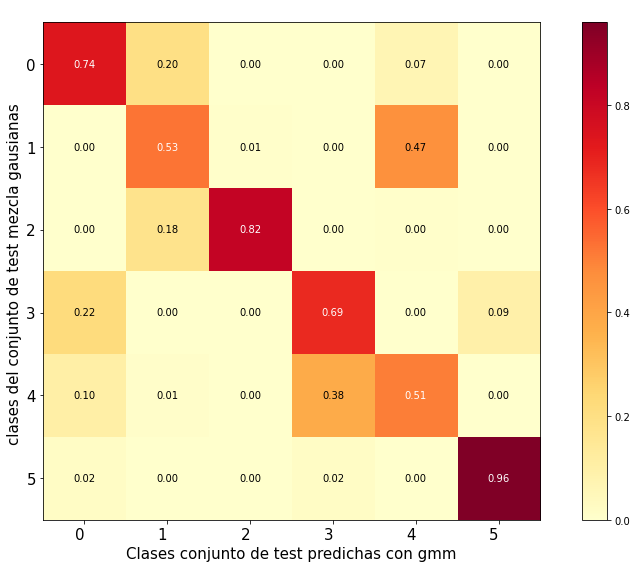

In [ ]:
plot_confusion_matrix_2(df_enanas_test_sin_out['gmm_grupos_m'], df_enanas_test_sin_out['gmm_clases_predichas_m'], normalize=True,
                      label_x = 'Clases conjunto de test predichas con gmm', label_y = 'clases del conjunto de test mezcla gausianas ', title=' ',cmap = cm.YlOrRd)

### Predicción de la clase con K-means

In [ ]:
etiquetas_predichas_m = km_EM_m.predict(datos_p)

In [ ]:
pd.crosstab(df_enanas_test_sin_out['clases_kmeans_m'], df_enanas_test_sin_out['clase_metalicidad']) 

clase_metalicidad    dM  esdM   sdM  usdM
clases_kmeans_m                          
1                  4688     1     5     0
2                     0   318     5     3
3                     5    10  1008     0
4                     0     0     1   128

In [ ]:
df_enanas_test_sin_out['clases_predichas_m'] = etiquetas_predichas_m+1
df_enanas_pca_test_sin_out['clases_predichas_m'] = etiquetas_predichas_m+1

In [ ]:
df_prediccion=pd.crosstab(df_enanas_test_sin_out['clases_kmeans_m'], df_enanas_test_sin_out['clases_predichas_m']) 
df_prediccion

clases_predichas_m     1    2    3   4
clases_kmeans_m                       
1                   4684    6    3   1
2                     34  121  112  59
3                     99  650  192  82
4                     10   24   55  40

In [ ]:
dict_indices={2:3,3:2}

In [ ]:
df_enanas_test_sin_out['clases_predichas_m'].replace(dict_indices,inplace=True)
df_enanas_pca_test_sin_out['clases_predichas_m'].replace(dict_indices,inplace=True)

In [ ]:
pd.crosstab(df_enanas_test_sin_out['clases_kmeans_m'], df_enanas_test_sin_out['clases_predichas_m'])

clases_predichas_m     1    2    3   4
clases_kmeans_m                       
1                   4684    3    6   1
2                     34  112  121  59
3                     99  192  650  82
4                     10   55   24  40

#### Evaluación resultado

In [ ]:
print(f"precisión = {(df_enanas_test_sin_out['clases_kmeans_m']==df_enanas_test_sin_out['clases_predichas_m']).sum()/df_enanas_test_sin_out.shape[0]}")

precisión = 0.888852883992223


##### Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix_2(y_true, y_pred, normalize=False, title=None, label_y=None, verbose = False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if verbose:
          print(cm.shape)
          print("Normalized confusion matrix")
    else:
        if verbose:
          print('Confusion matrix, without normalization')

    #print(cm)

    #COMIENZA EL GRÁFICO
    fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
  
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
            )
    
    ax.set_ylabel(label_y, size = 15 )
    ax.set_xlabel('Clases predichas con K-means', size = 15 )

    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor",size=15)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor",size=15)

    

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black") #va es vertical aligment
    fig.tight_layout()
    return ax

Para comparar usando la matriz de confusión el el ersultado de la predicción con las etiquites de metalicidad  creamos una nueva columna con labelencoder

Comparación entre clusteríng y predicción

AxesImage(108,72;669.6x434.88)


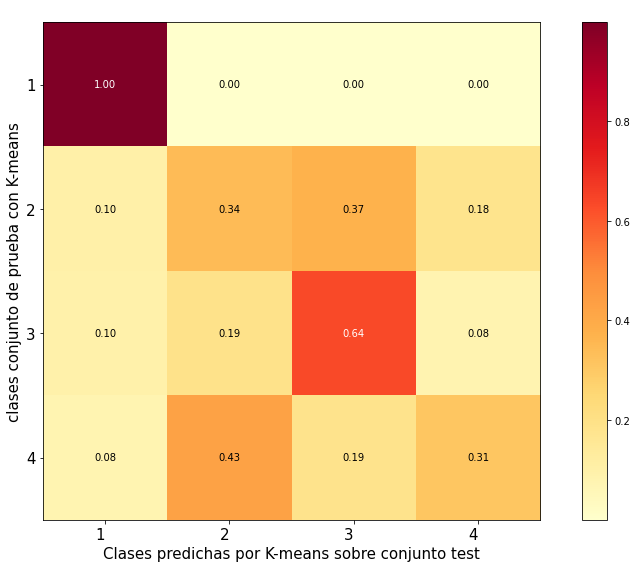

In [ ]:
plot_confusion_matrix_2(df_enanas_test_sin_out['clases_kmeans_m'], df_enanas_test_sin_out['clases_predichas_m'], normalize=True,
                      label_x='Clases predichas por K-means sobre conjunto test', label_y = 'clases conjunto de prueba con K-means', title=' ',cmap = cm.YlOrRd)

#FIN